# Telegram Wrapped
## A telegram-chat visual analysis
This notebook guides you in analyzing your private one-to-one chats.

Specify the CSV path

The notebook also contains a sentiment/emotion-analysis, which has been implemented for the italian language.

In [60]:
chat_path = 'gabibboost.csv'

Libraries import

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

import string
import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize

import networkx as nx
import math

import gensim
from gensim import corpora, models

from feel_it import EmotionClassifier, SentimentClassifier

First, we read the chat CSV

In [62]:
chat = pd.read_csv(chat_path)

### Number of messages per day
We convert the _day_ column to a datetime and determine the message count

In [63]:
chat['day'] = pd.to_datetime(chat['day'])
messages_per_day = chat.groupby('day')['msg_id'].count()

However the chat might have gaps: therefore, we fill in this gaps adding "0 messages" entries

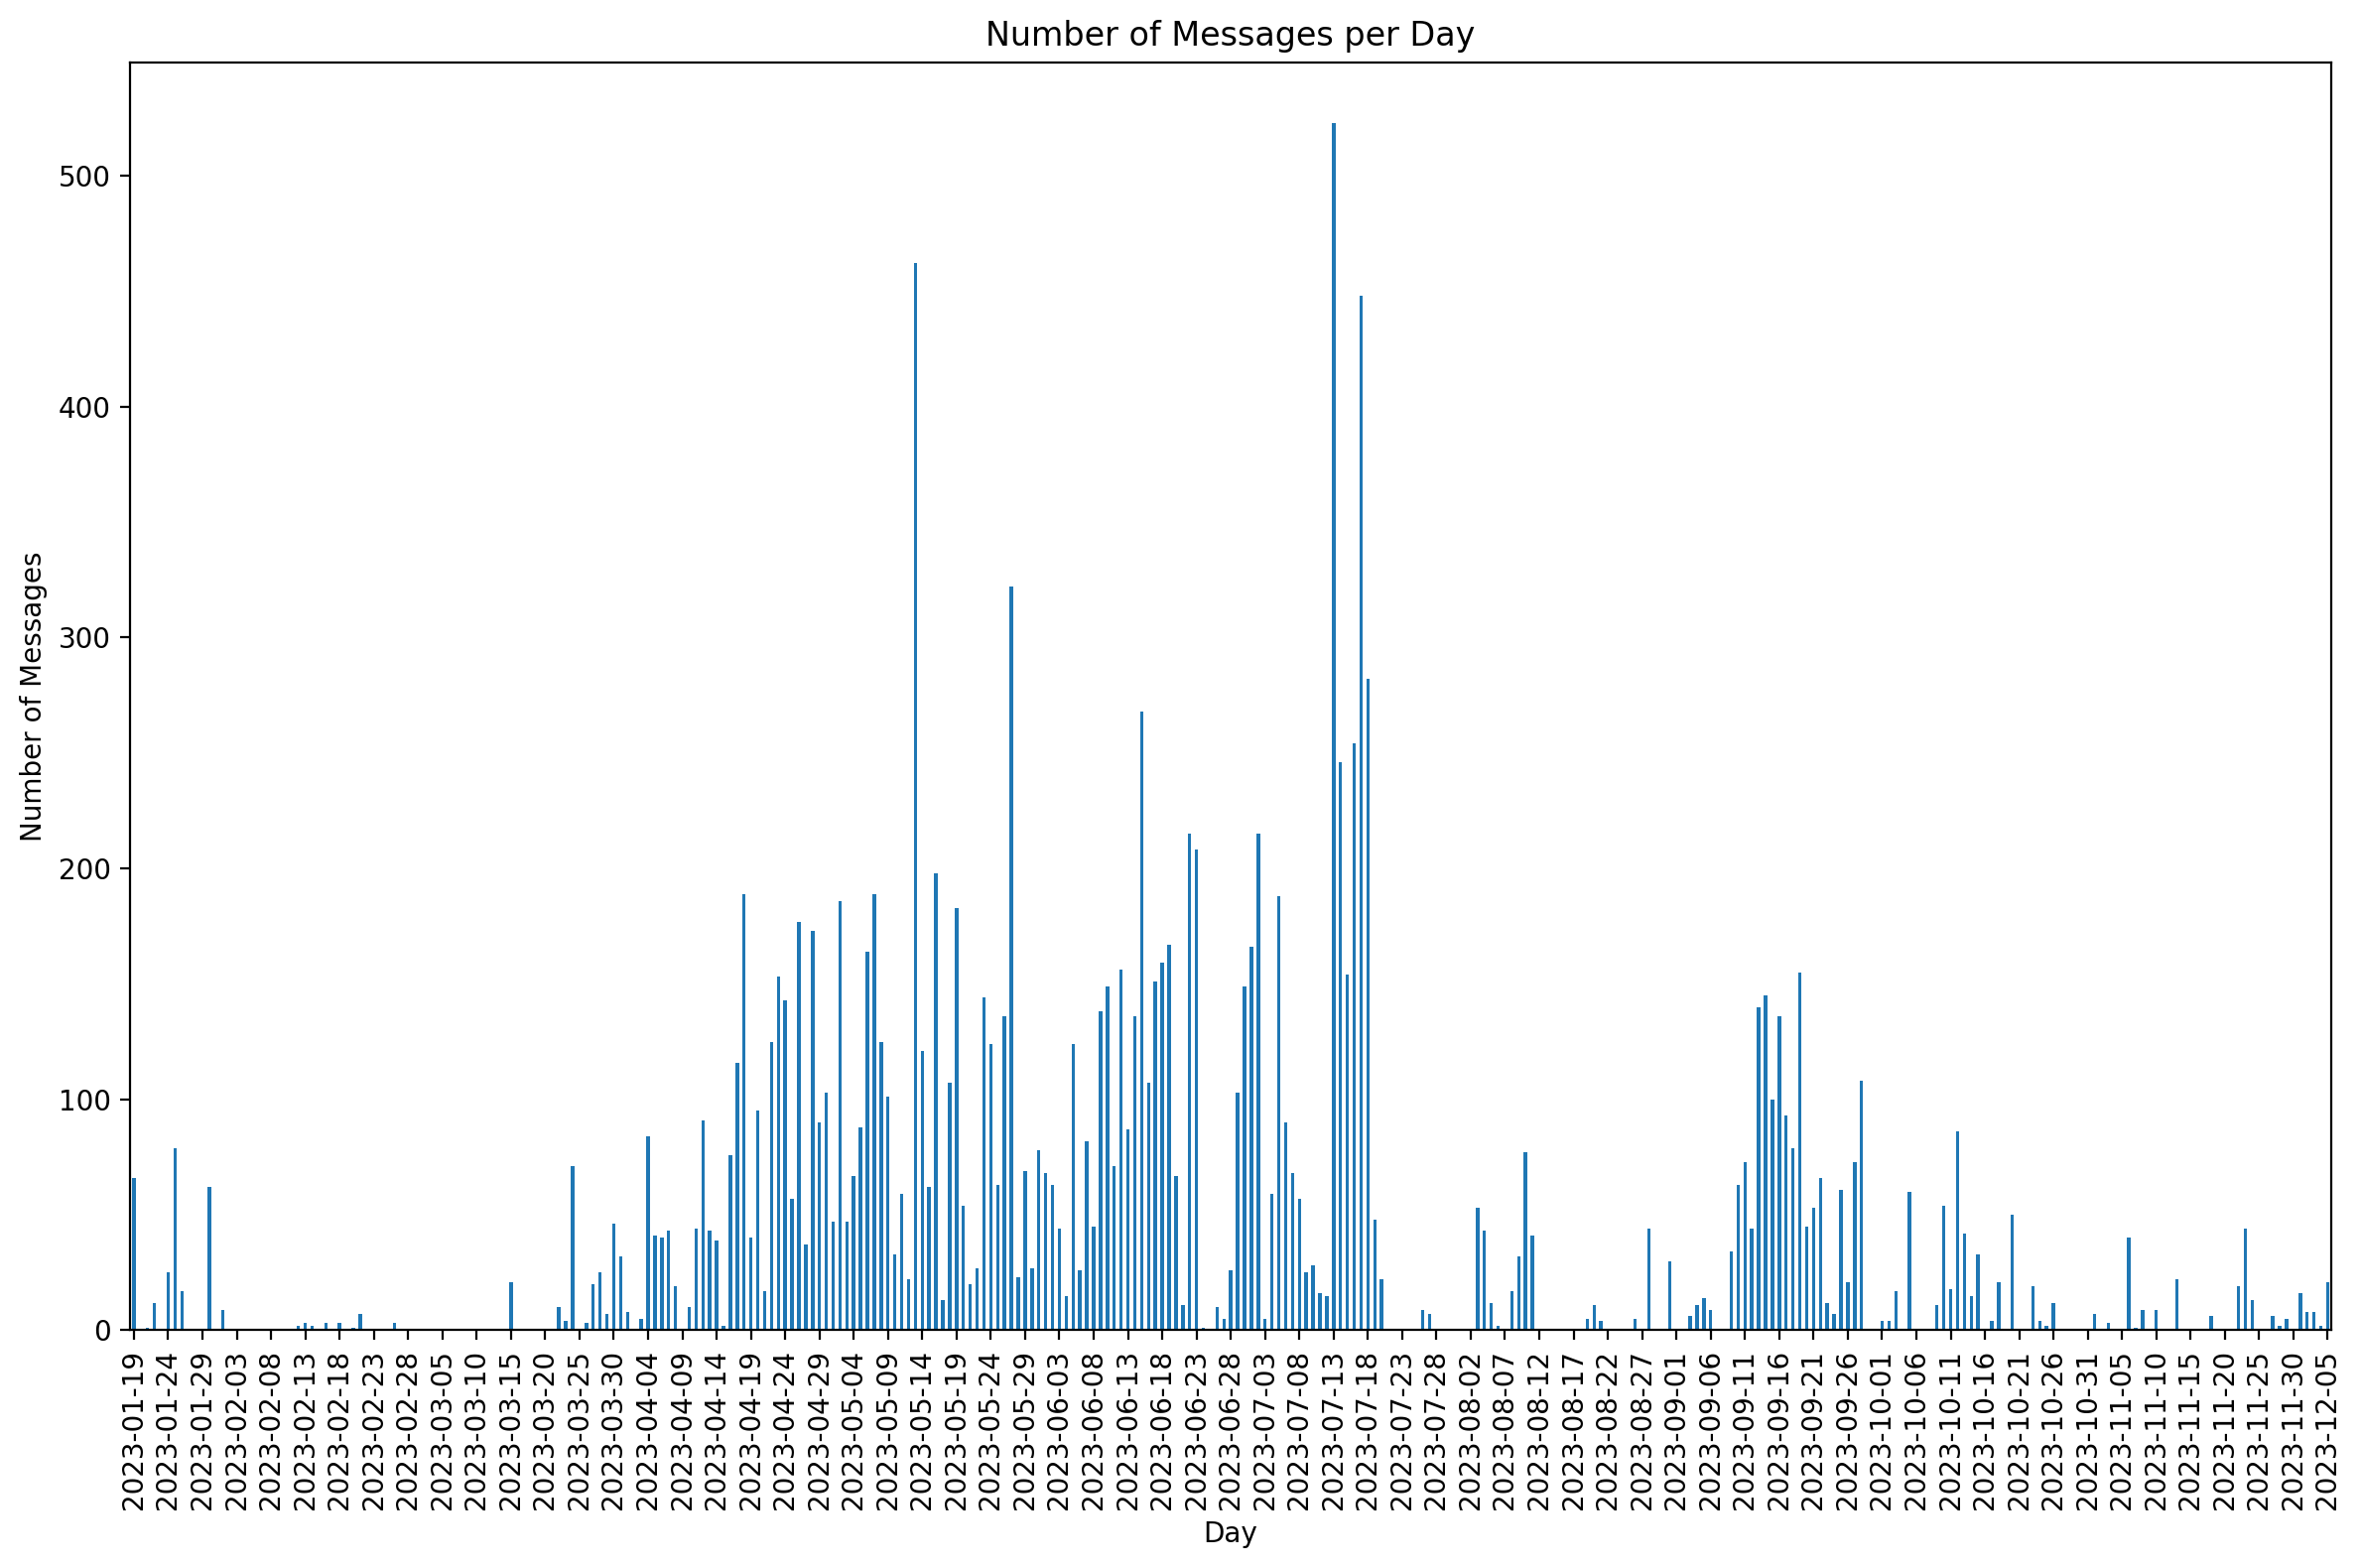

In [64]:
date_range = pd.date_range(start=chat['day'].min(), end=chat['day'].max())

messages_per_day = messages_per_day.reindex(date_range, fill_value=0)

plt.figure(figsize=(12, 8), dpi=200)
messages_per_day.plot(kind='bar')

plt.xlabel('Day')
plt.ylabel('Number of Messages')
plt.title('Number of Messages per Day')

date_labels = messages_per_day.index.strftime('%Y-%m-%d')
plt.xticks(range(0, len(messages_per_day), 5), date_labels[::5], rotation=90)

plt.tight_layout()
plt.show()

Then we do the same for every account

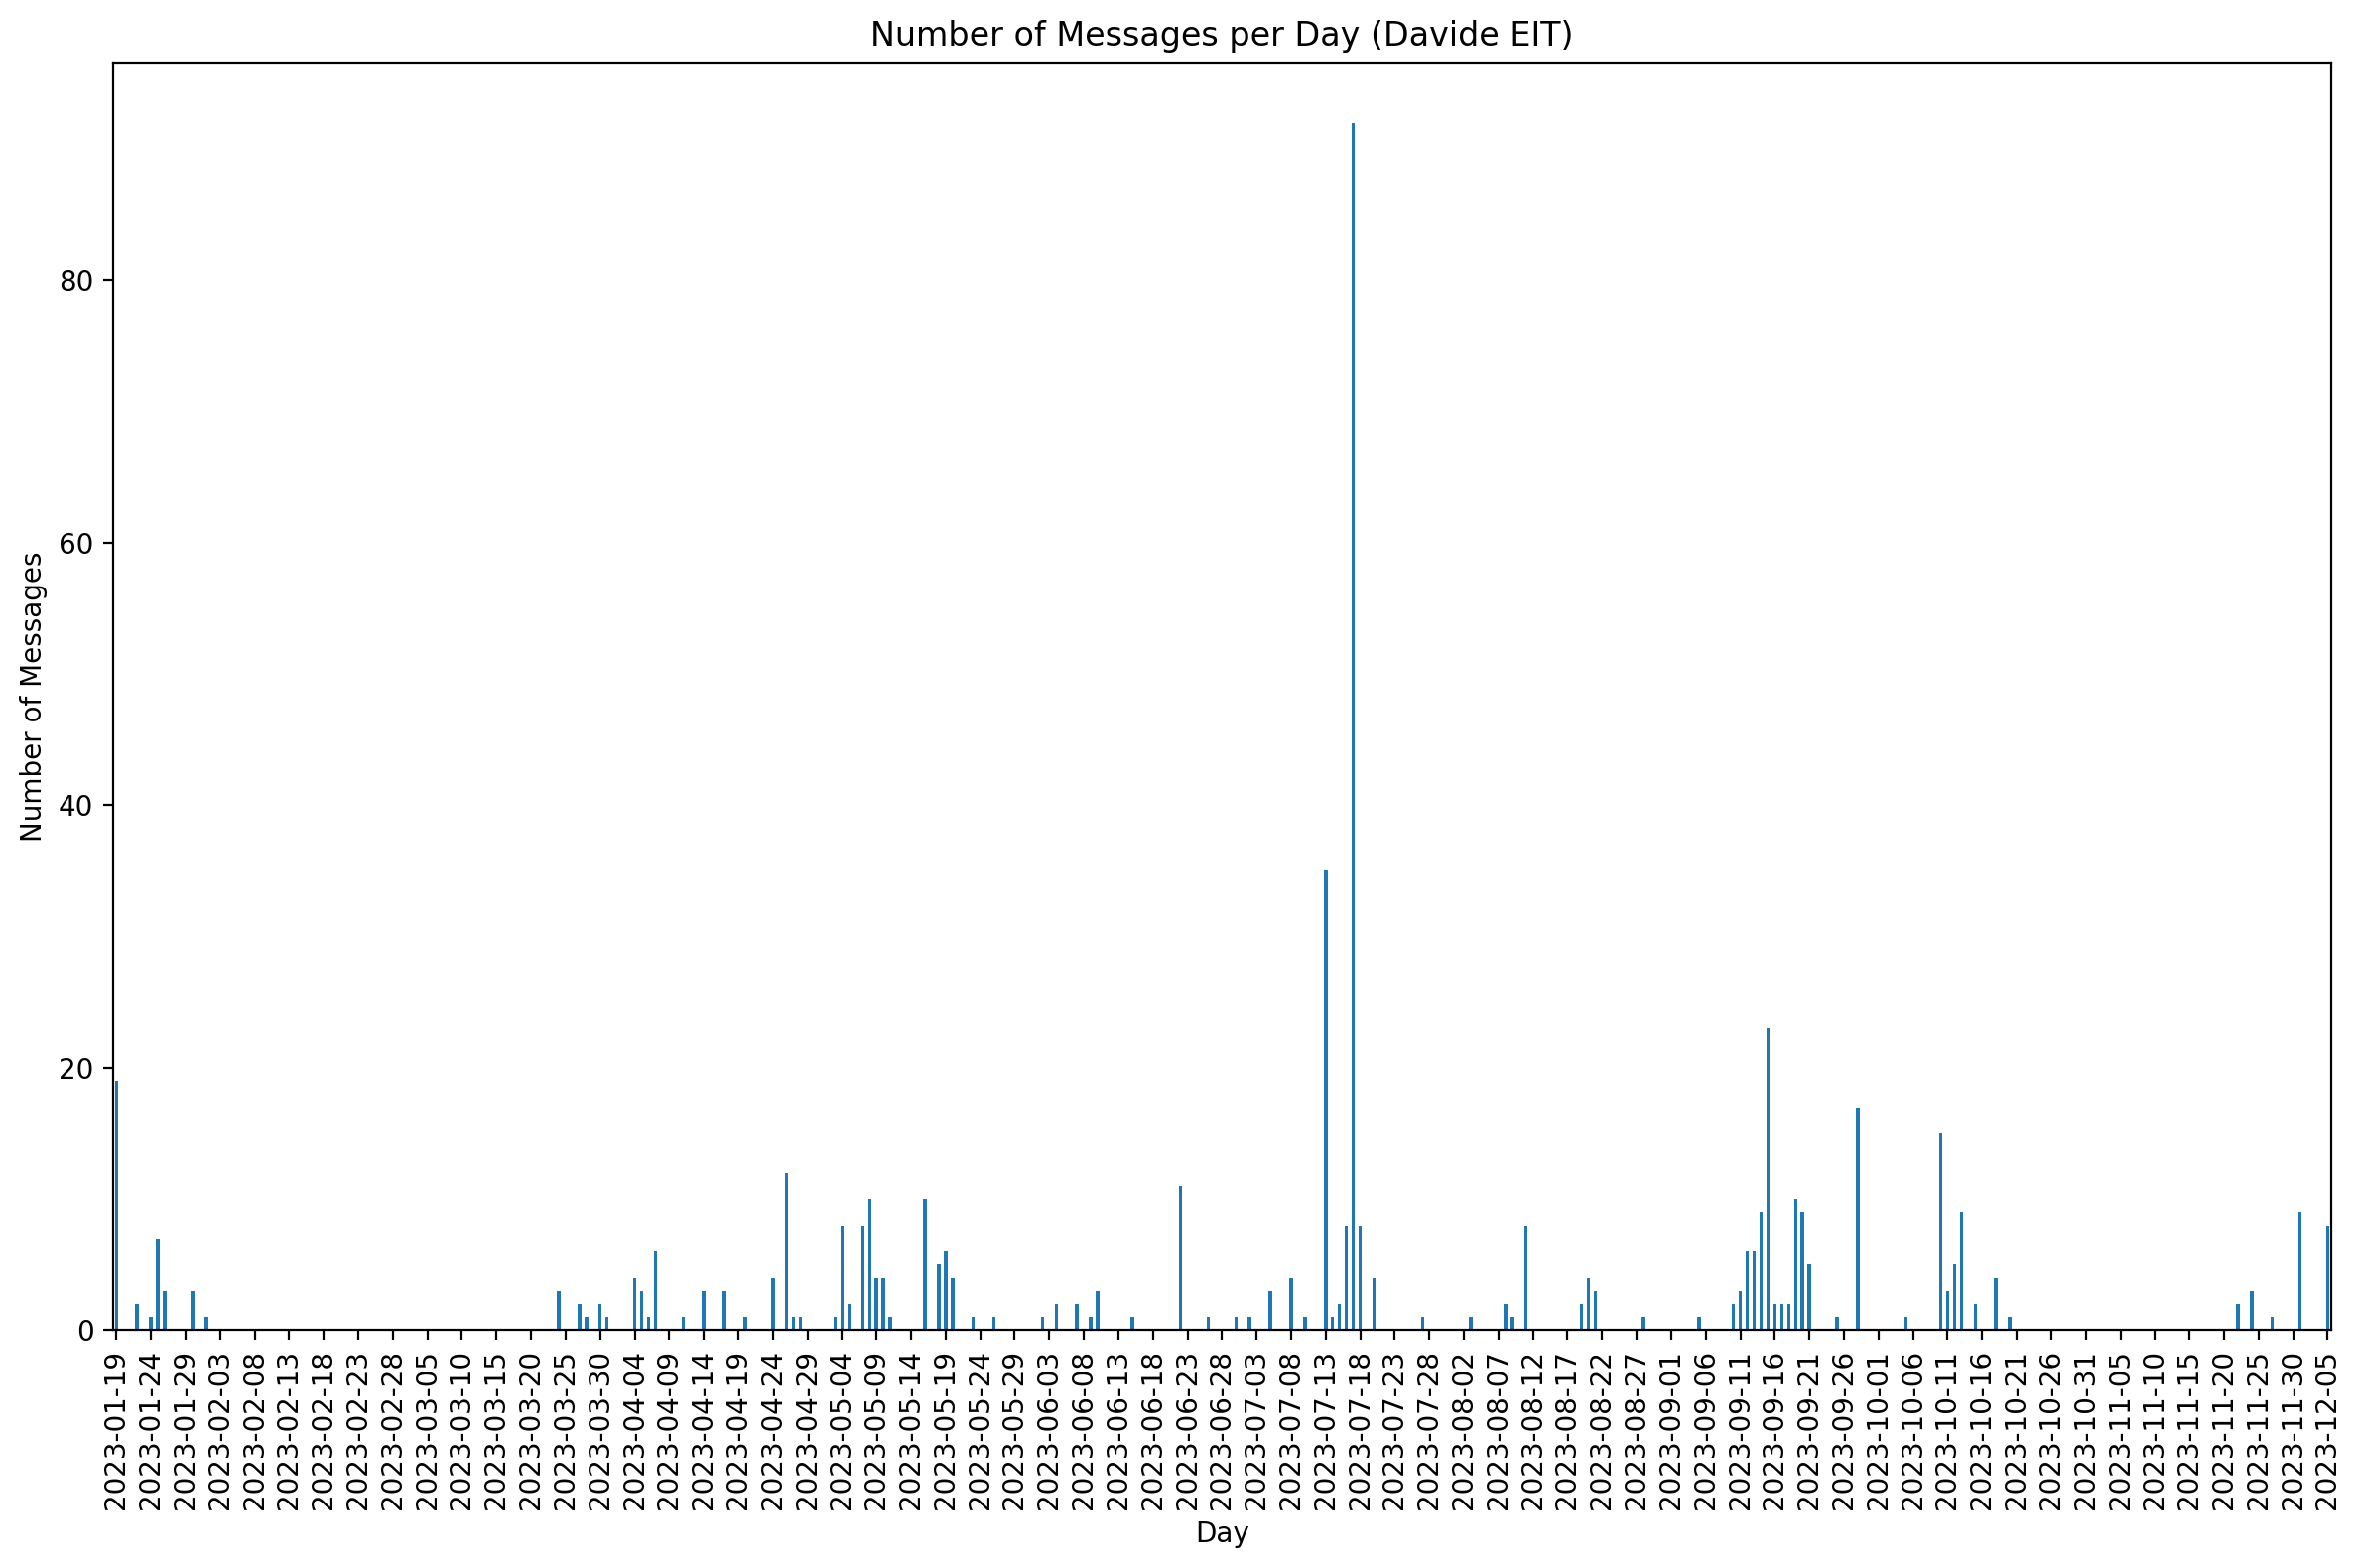

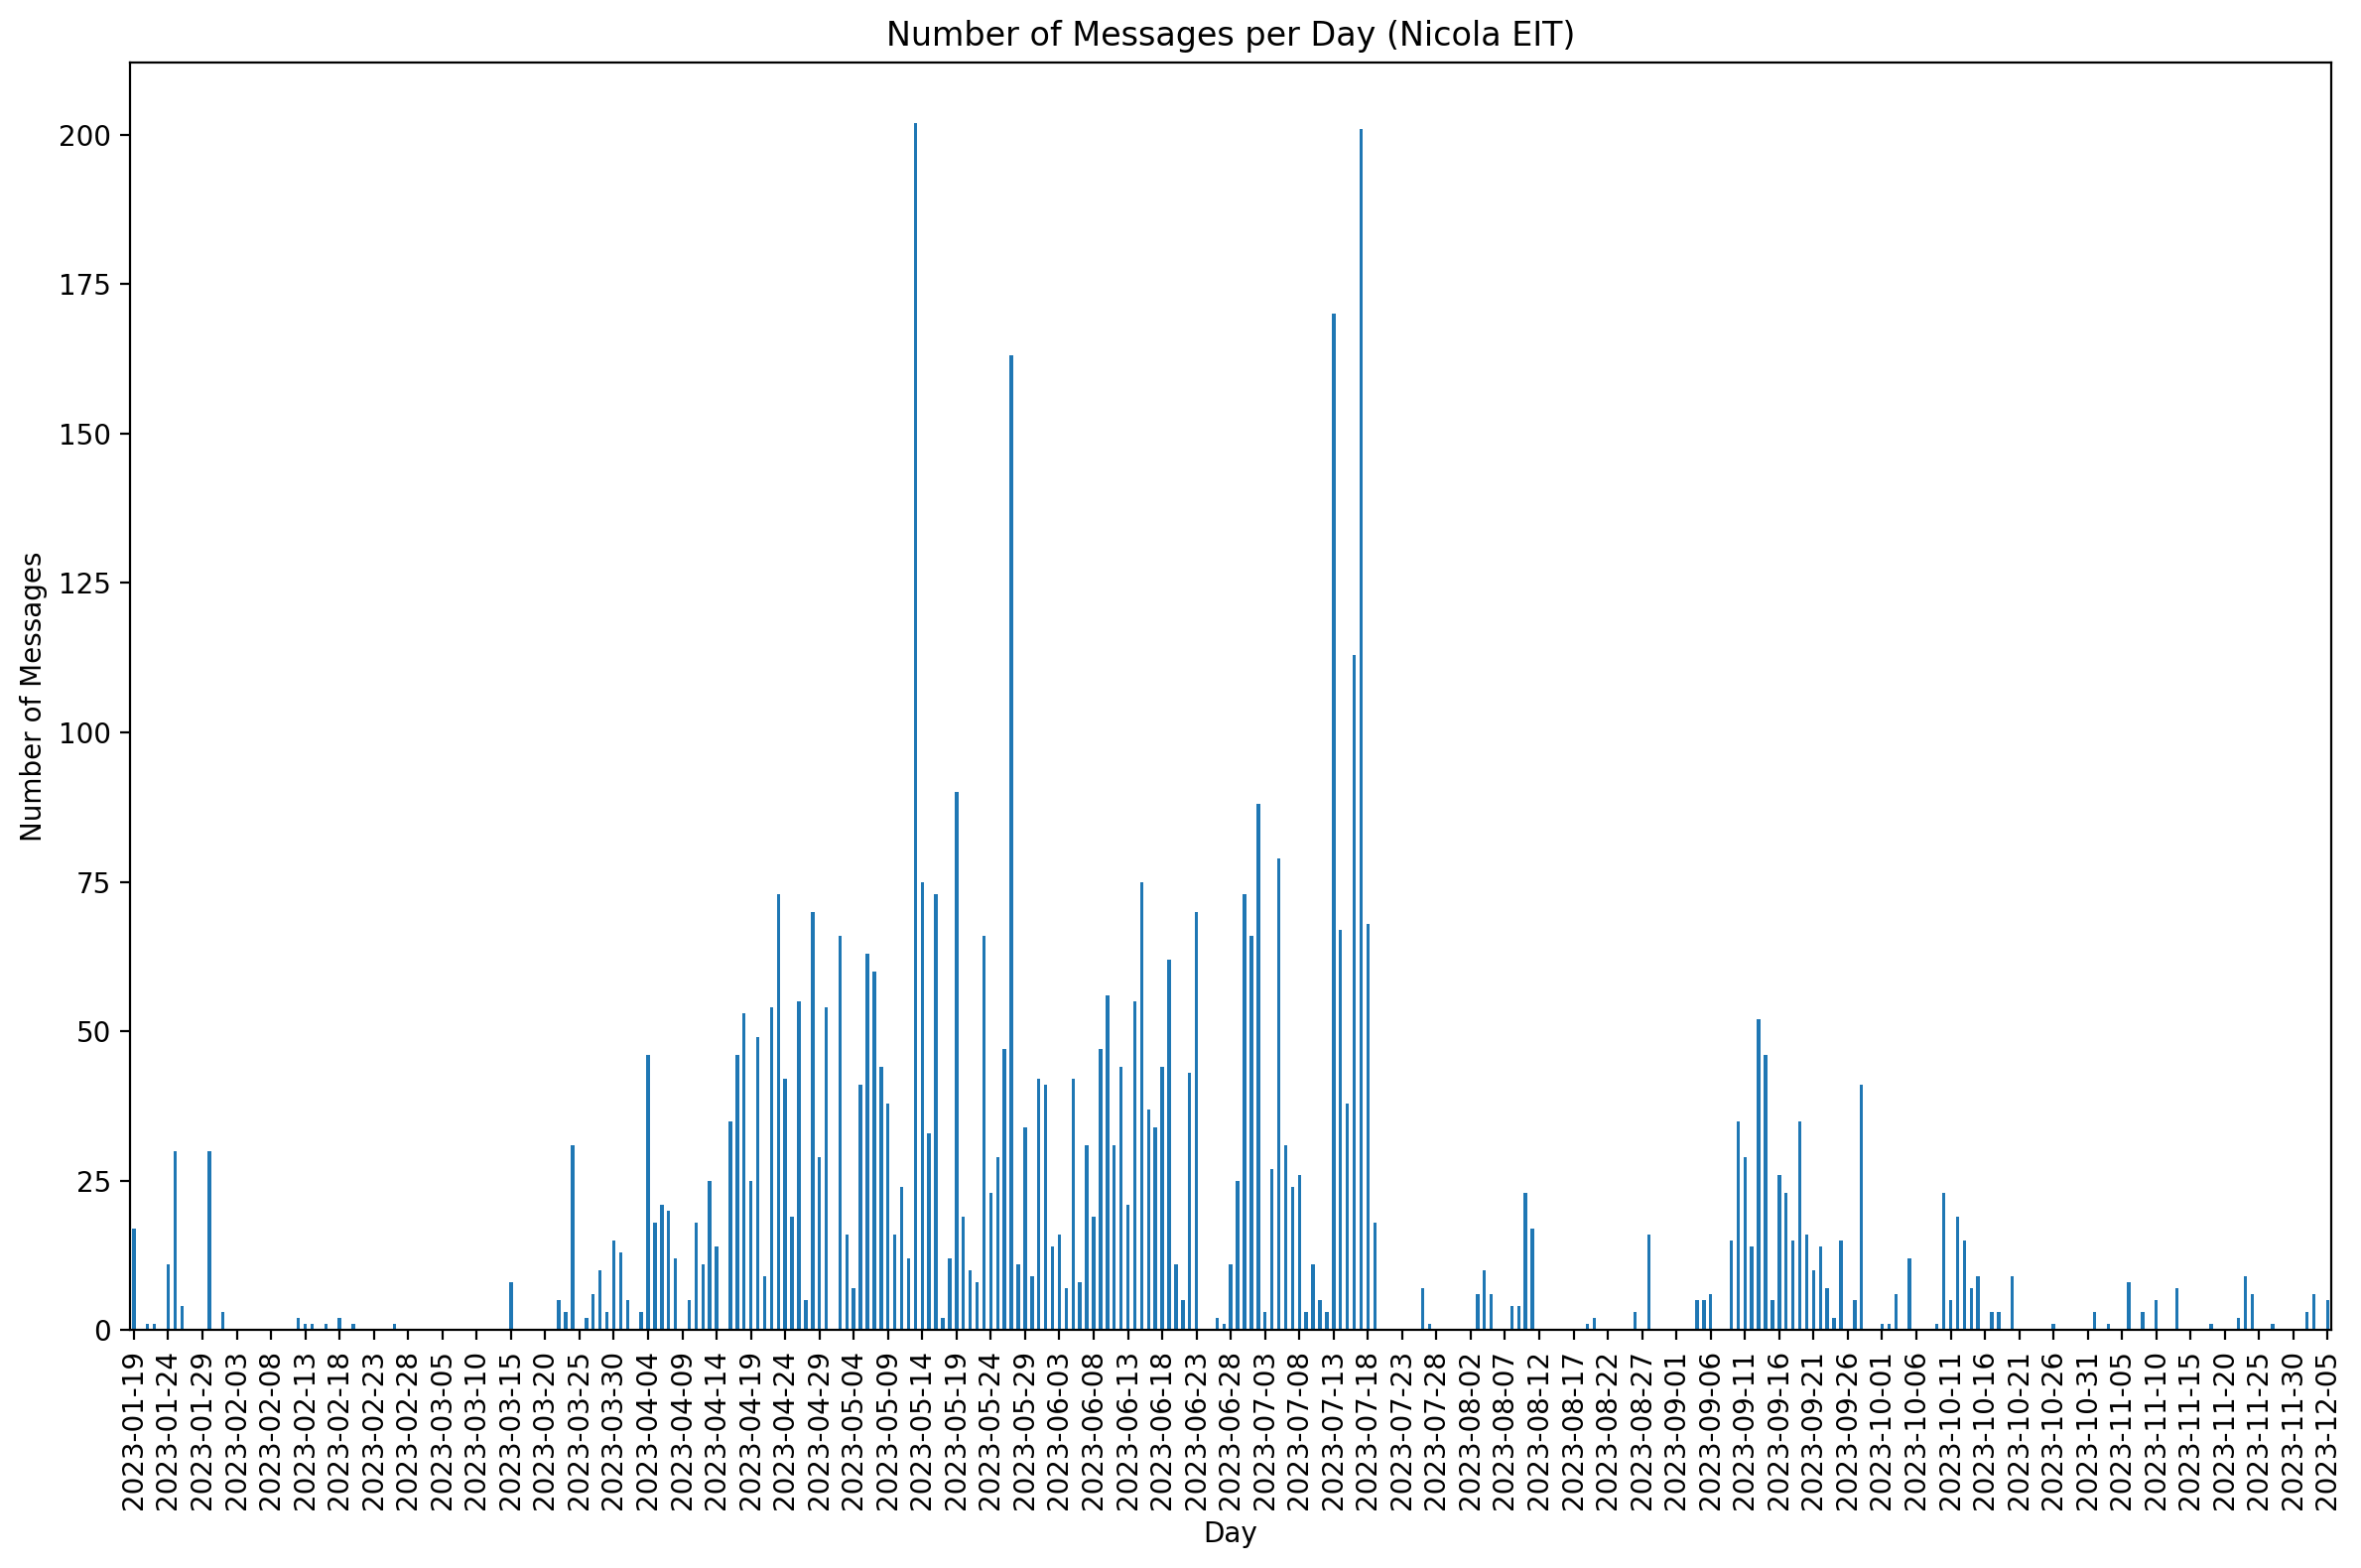

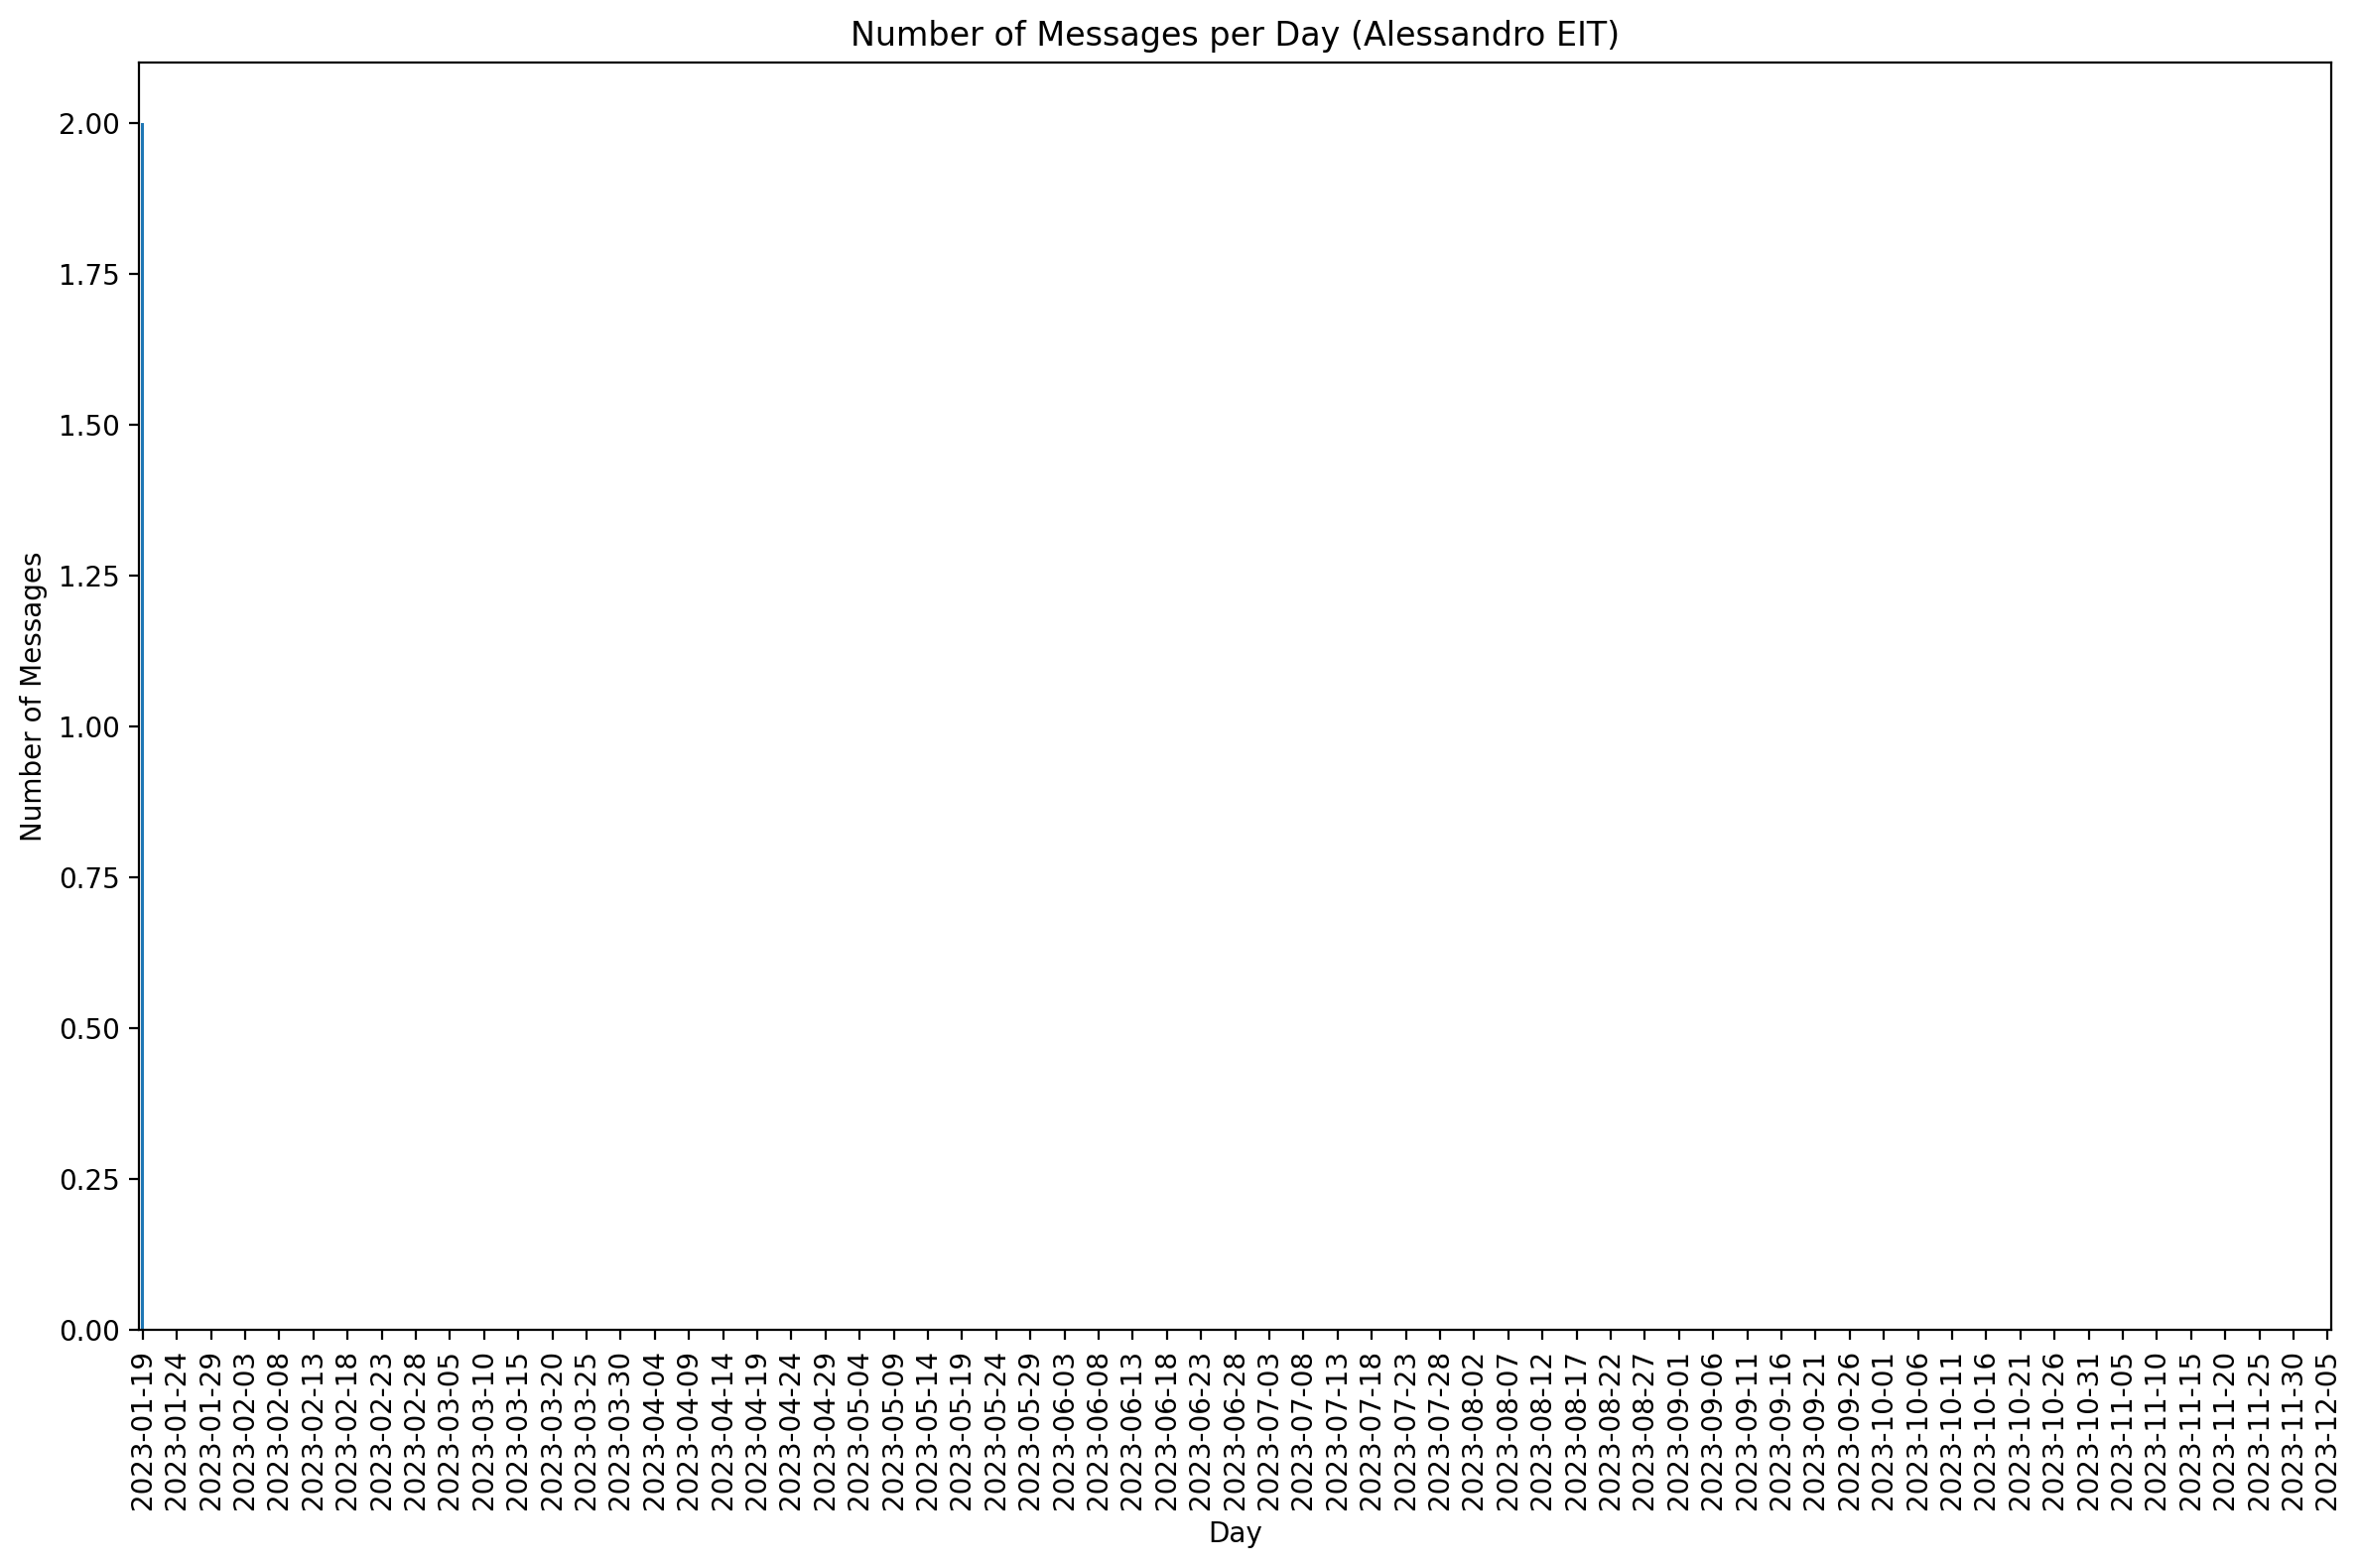

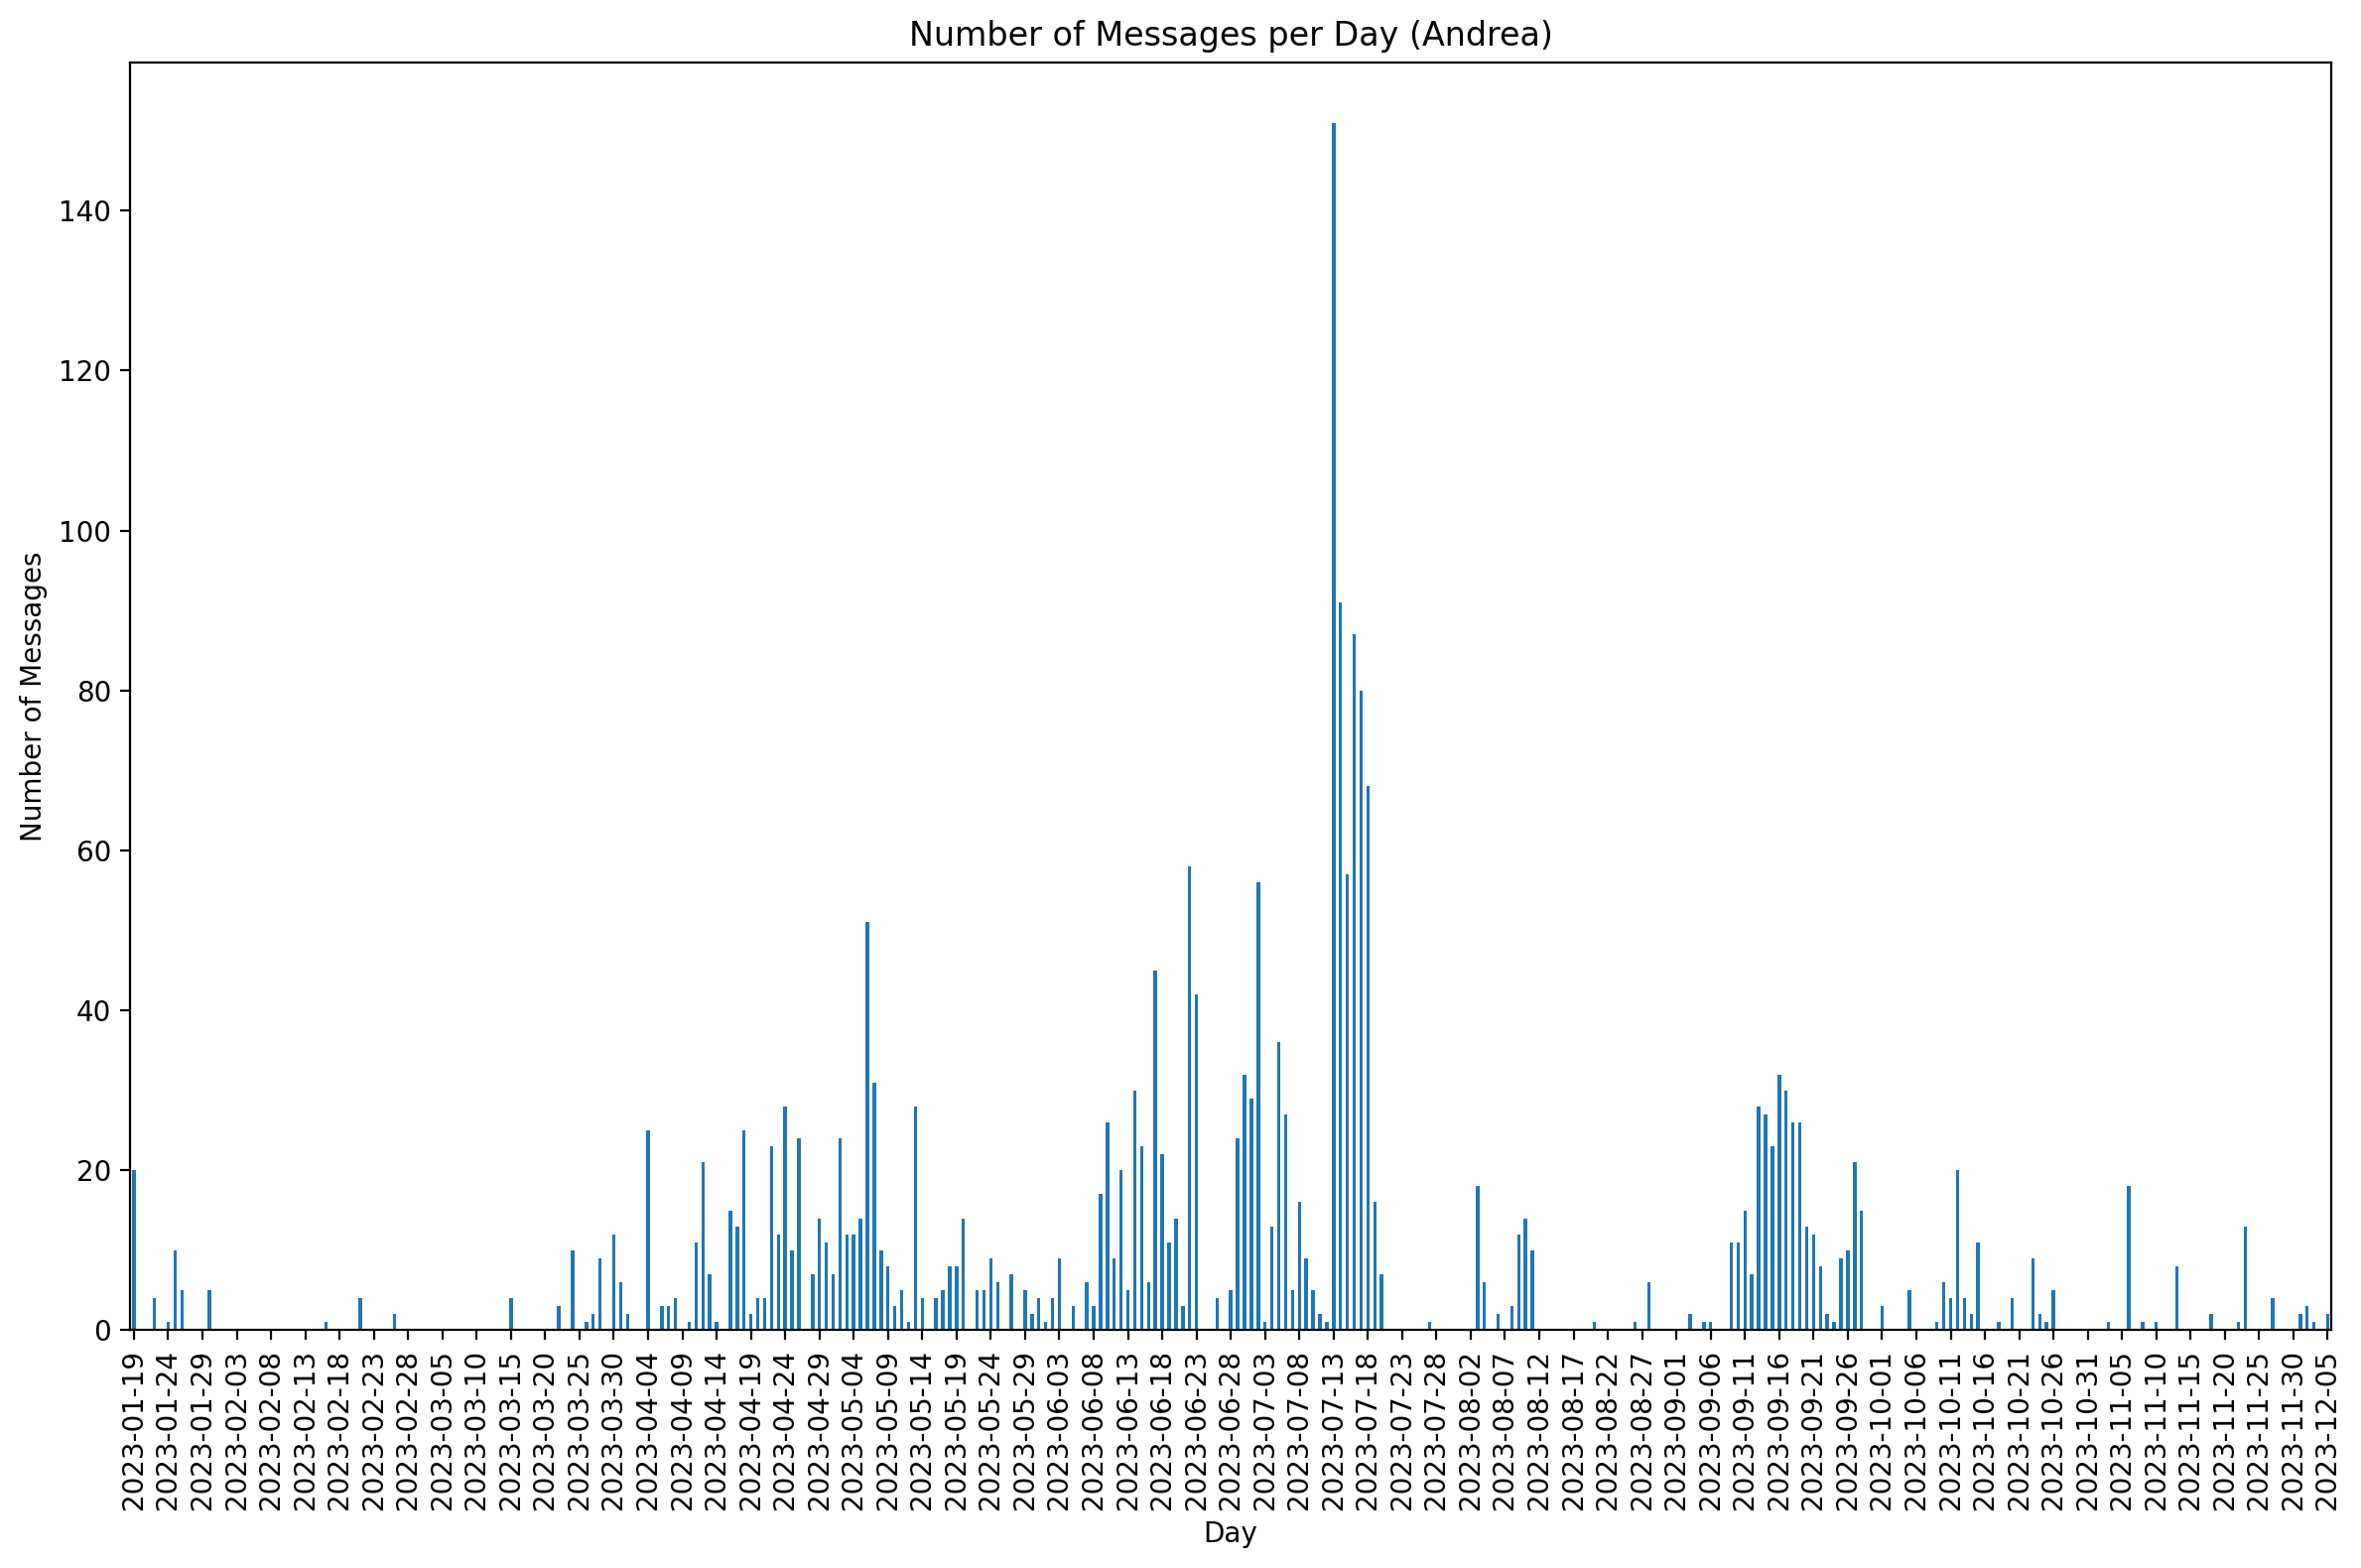

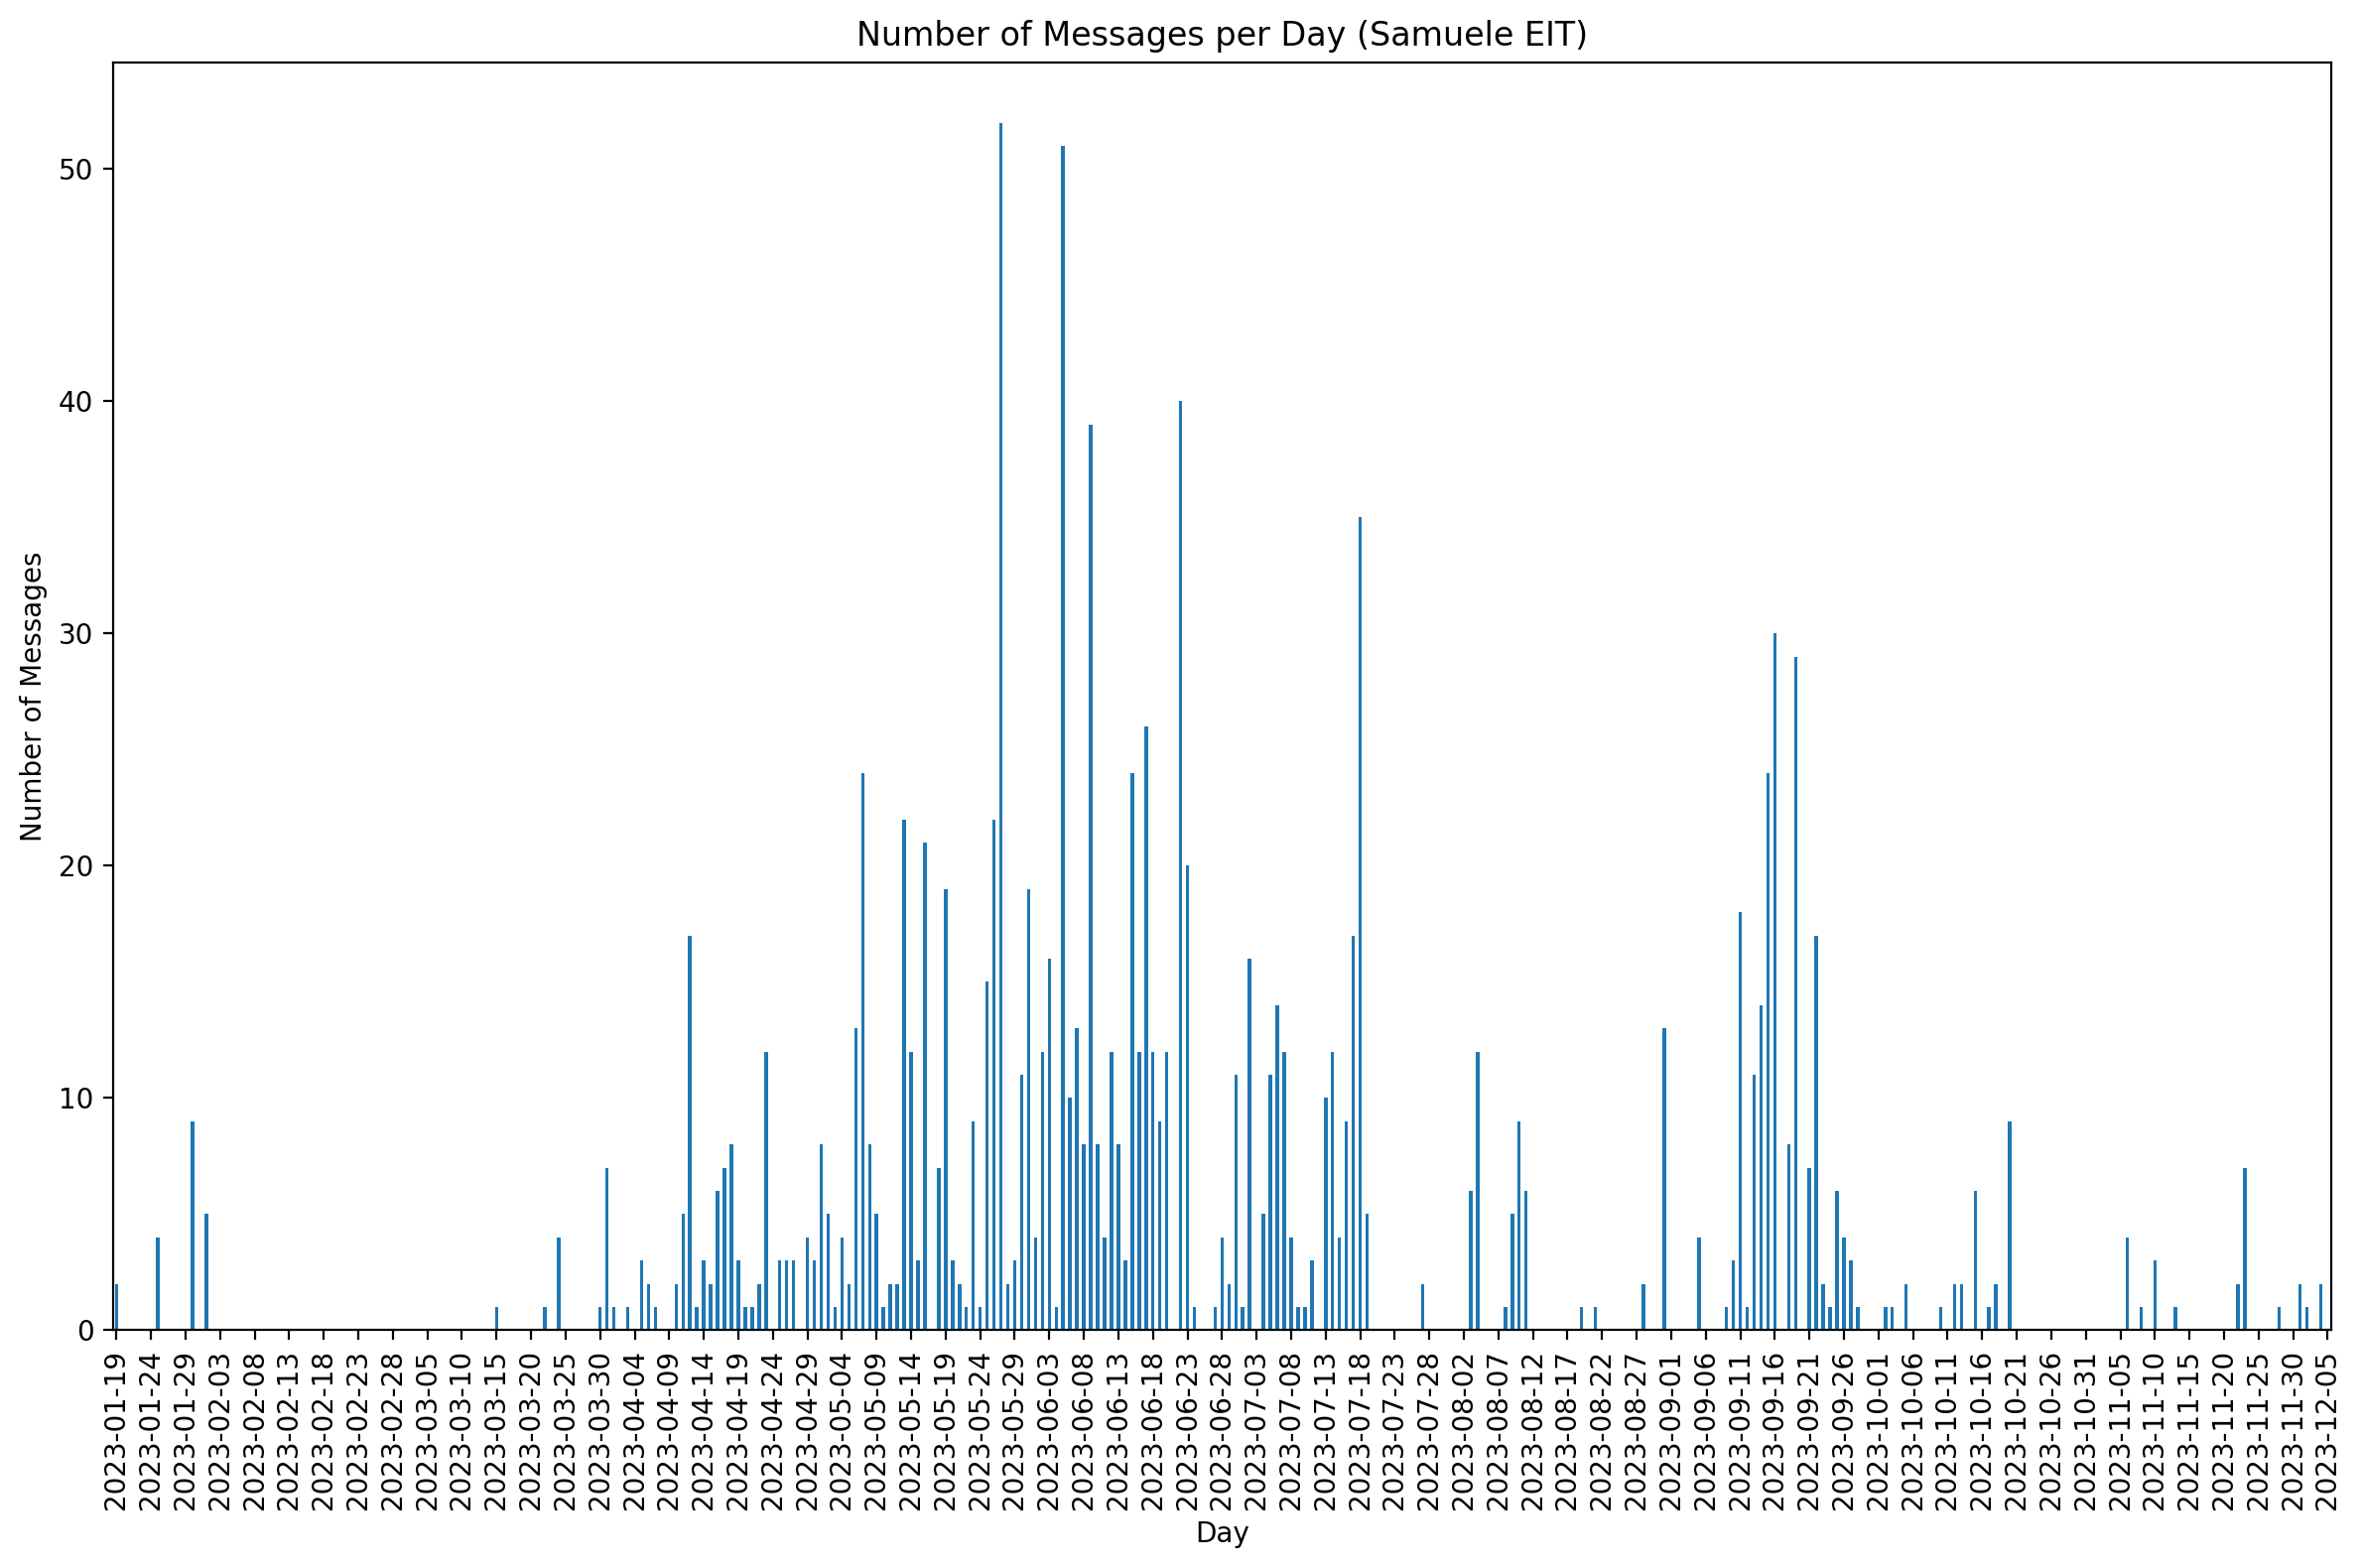

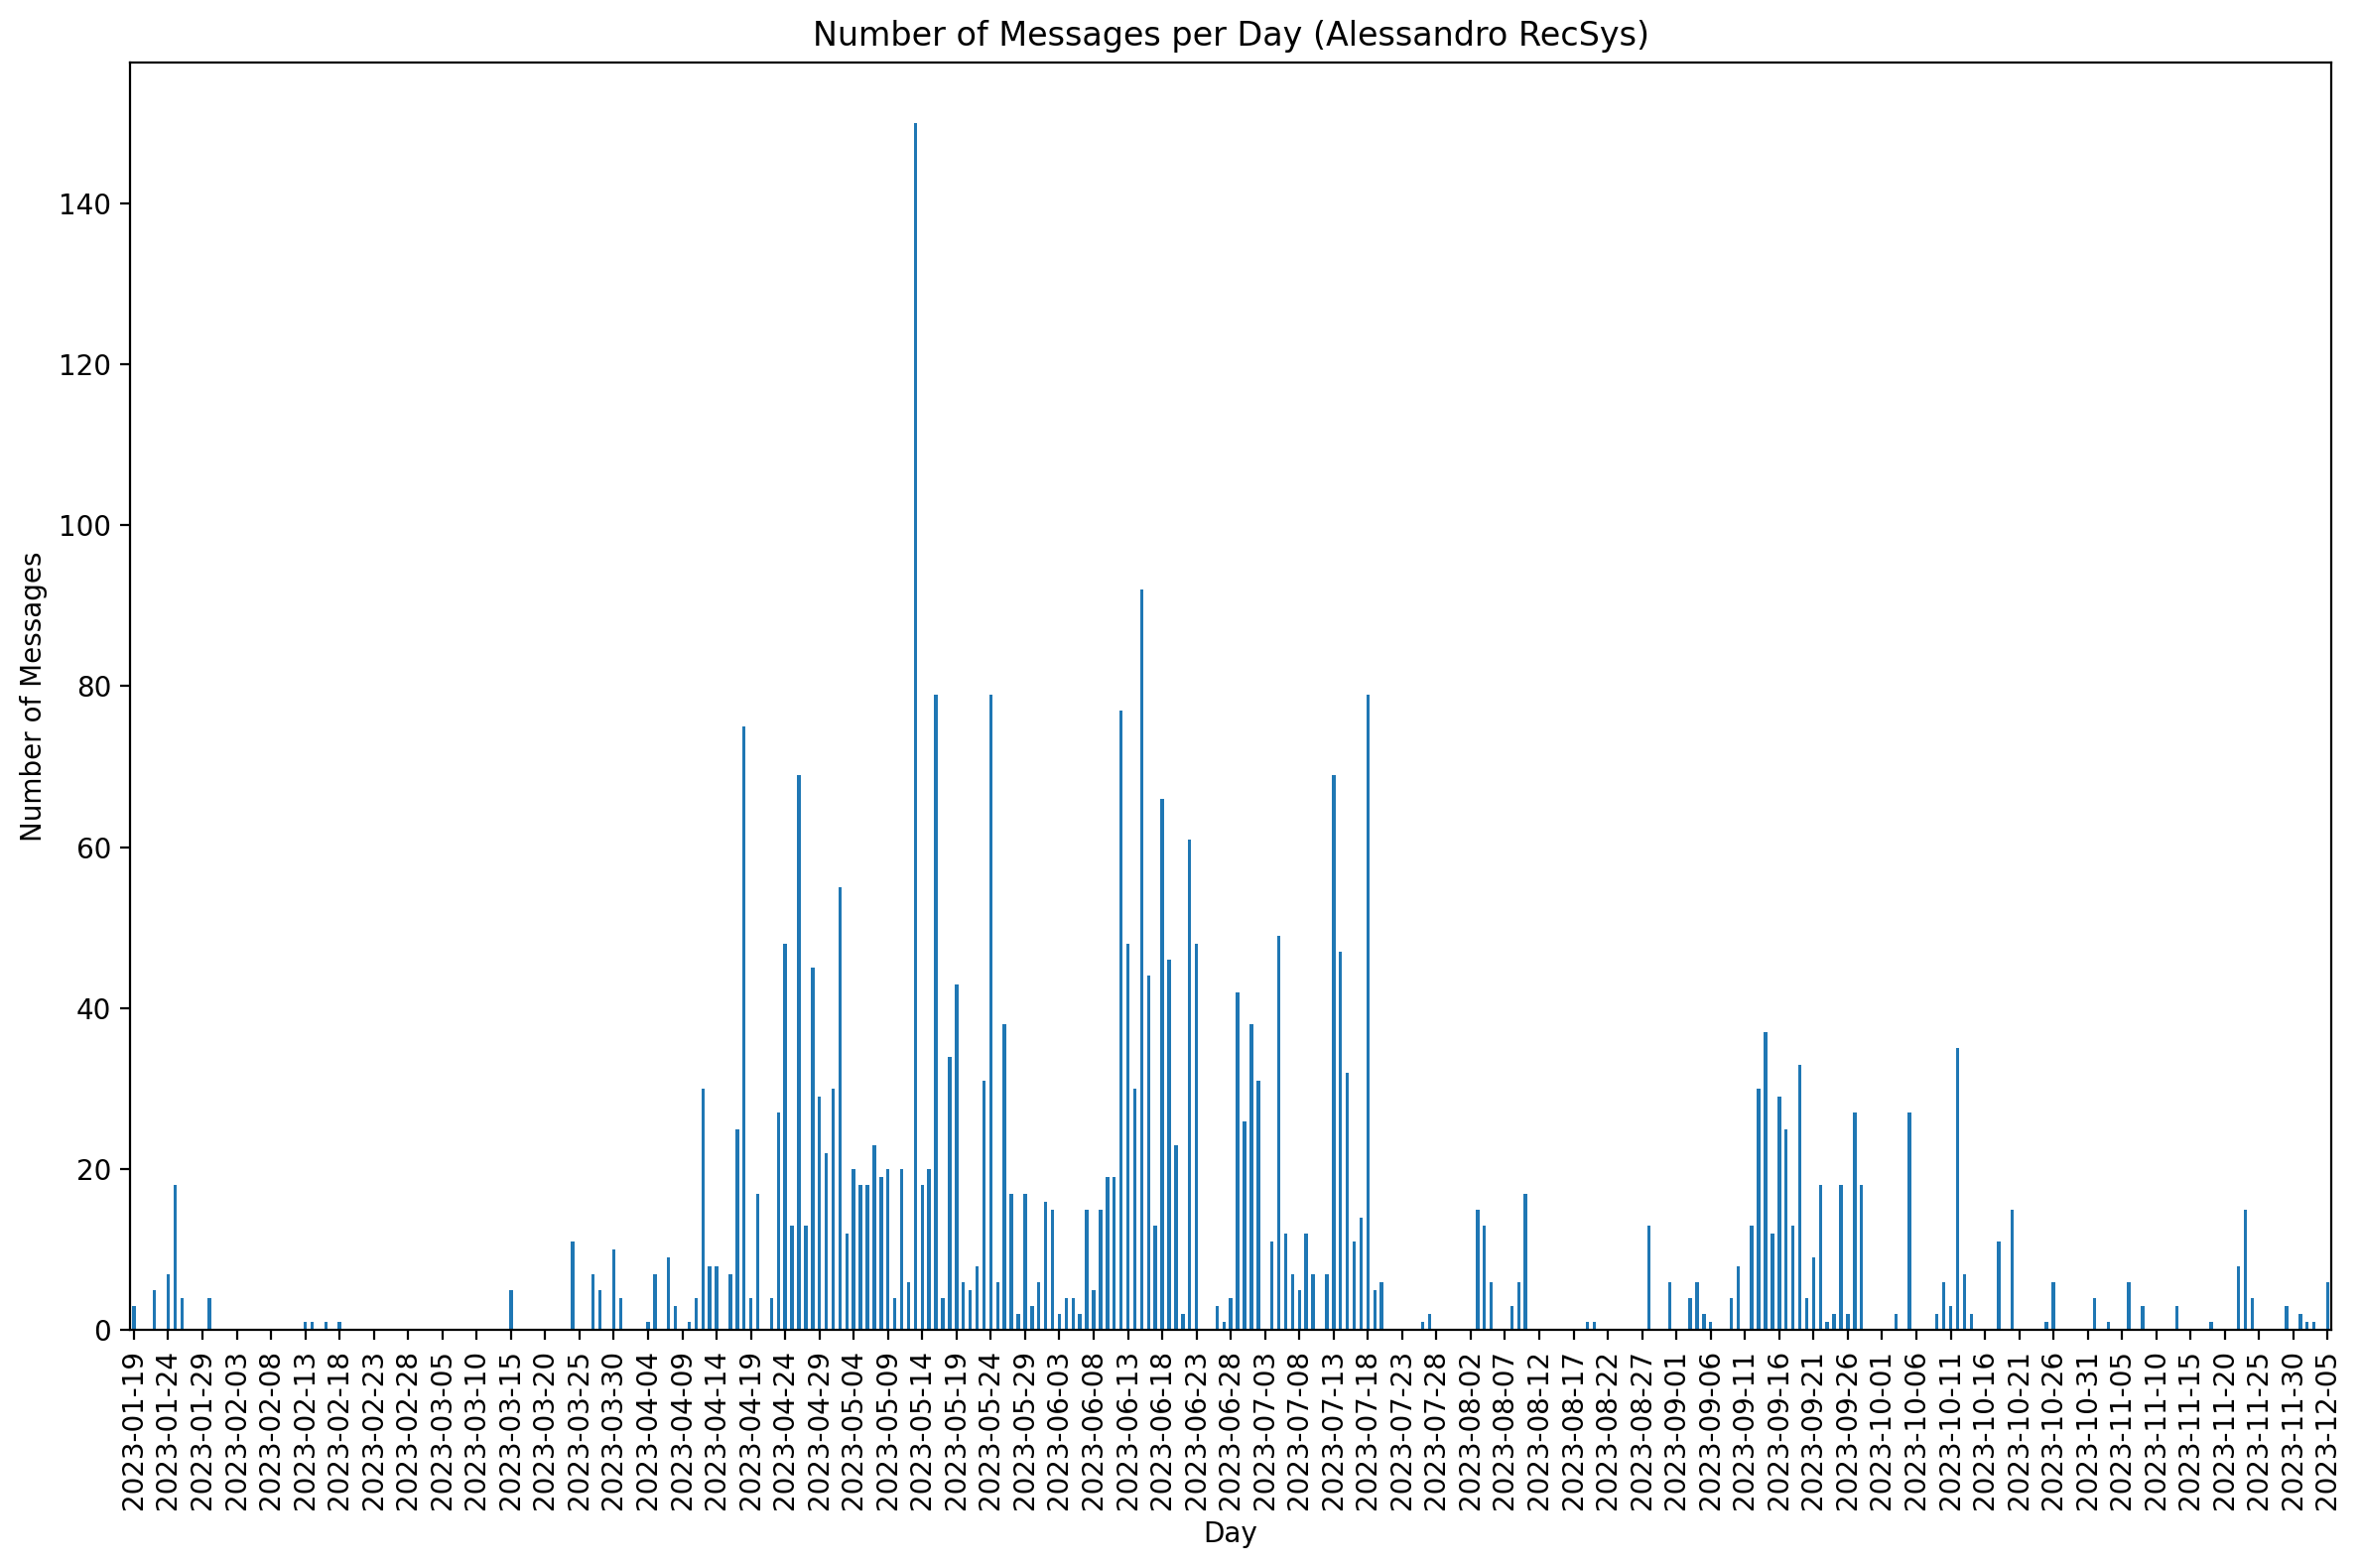

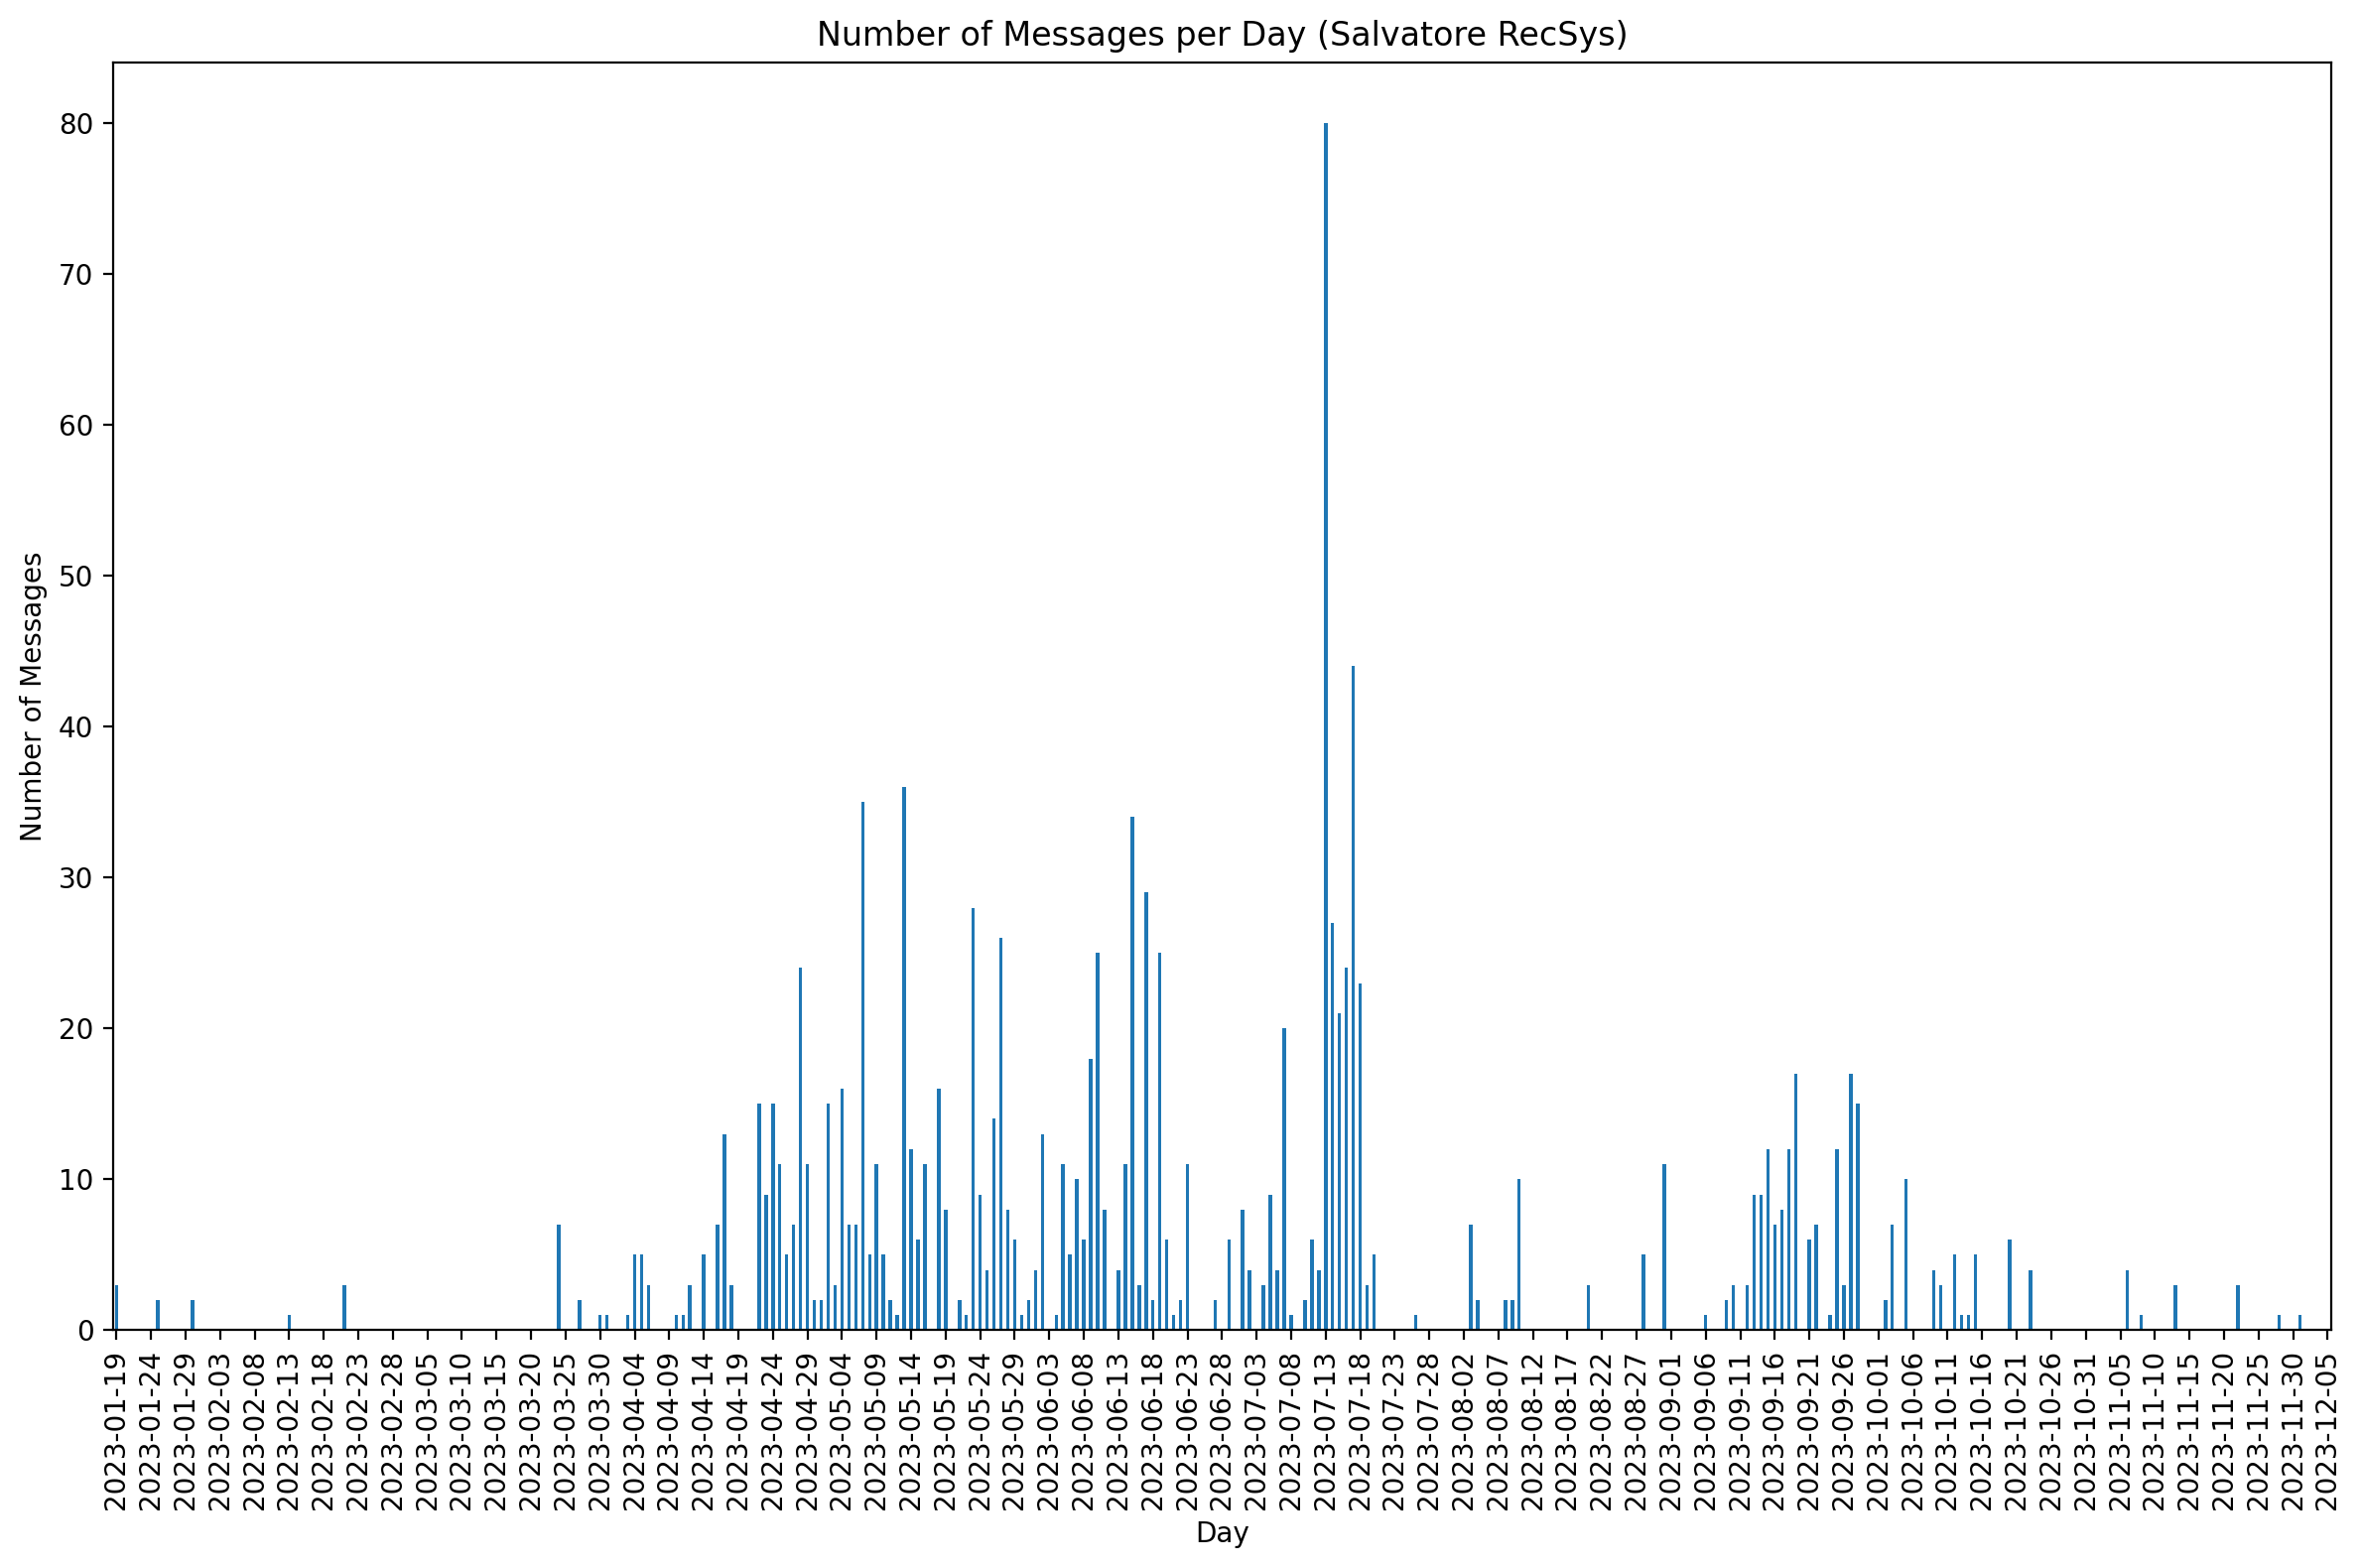

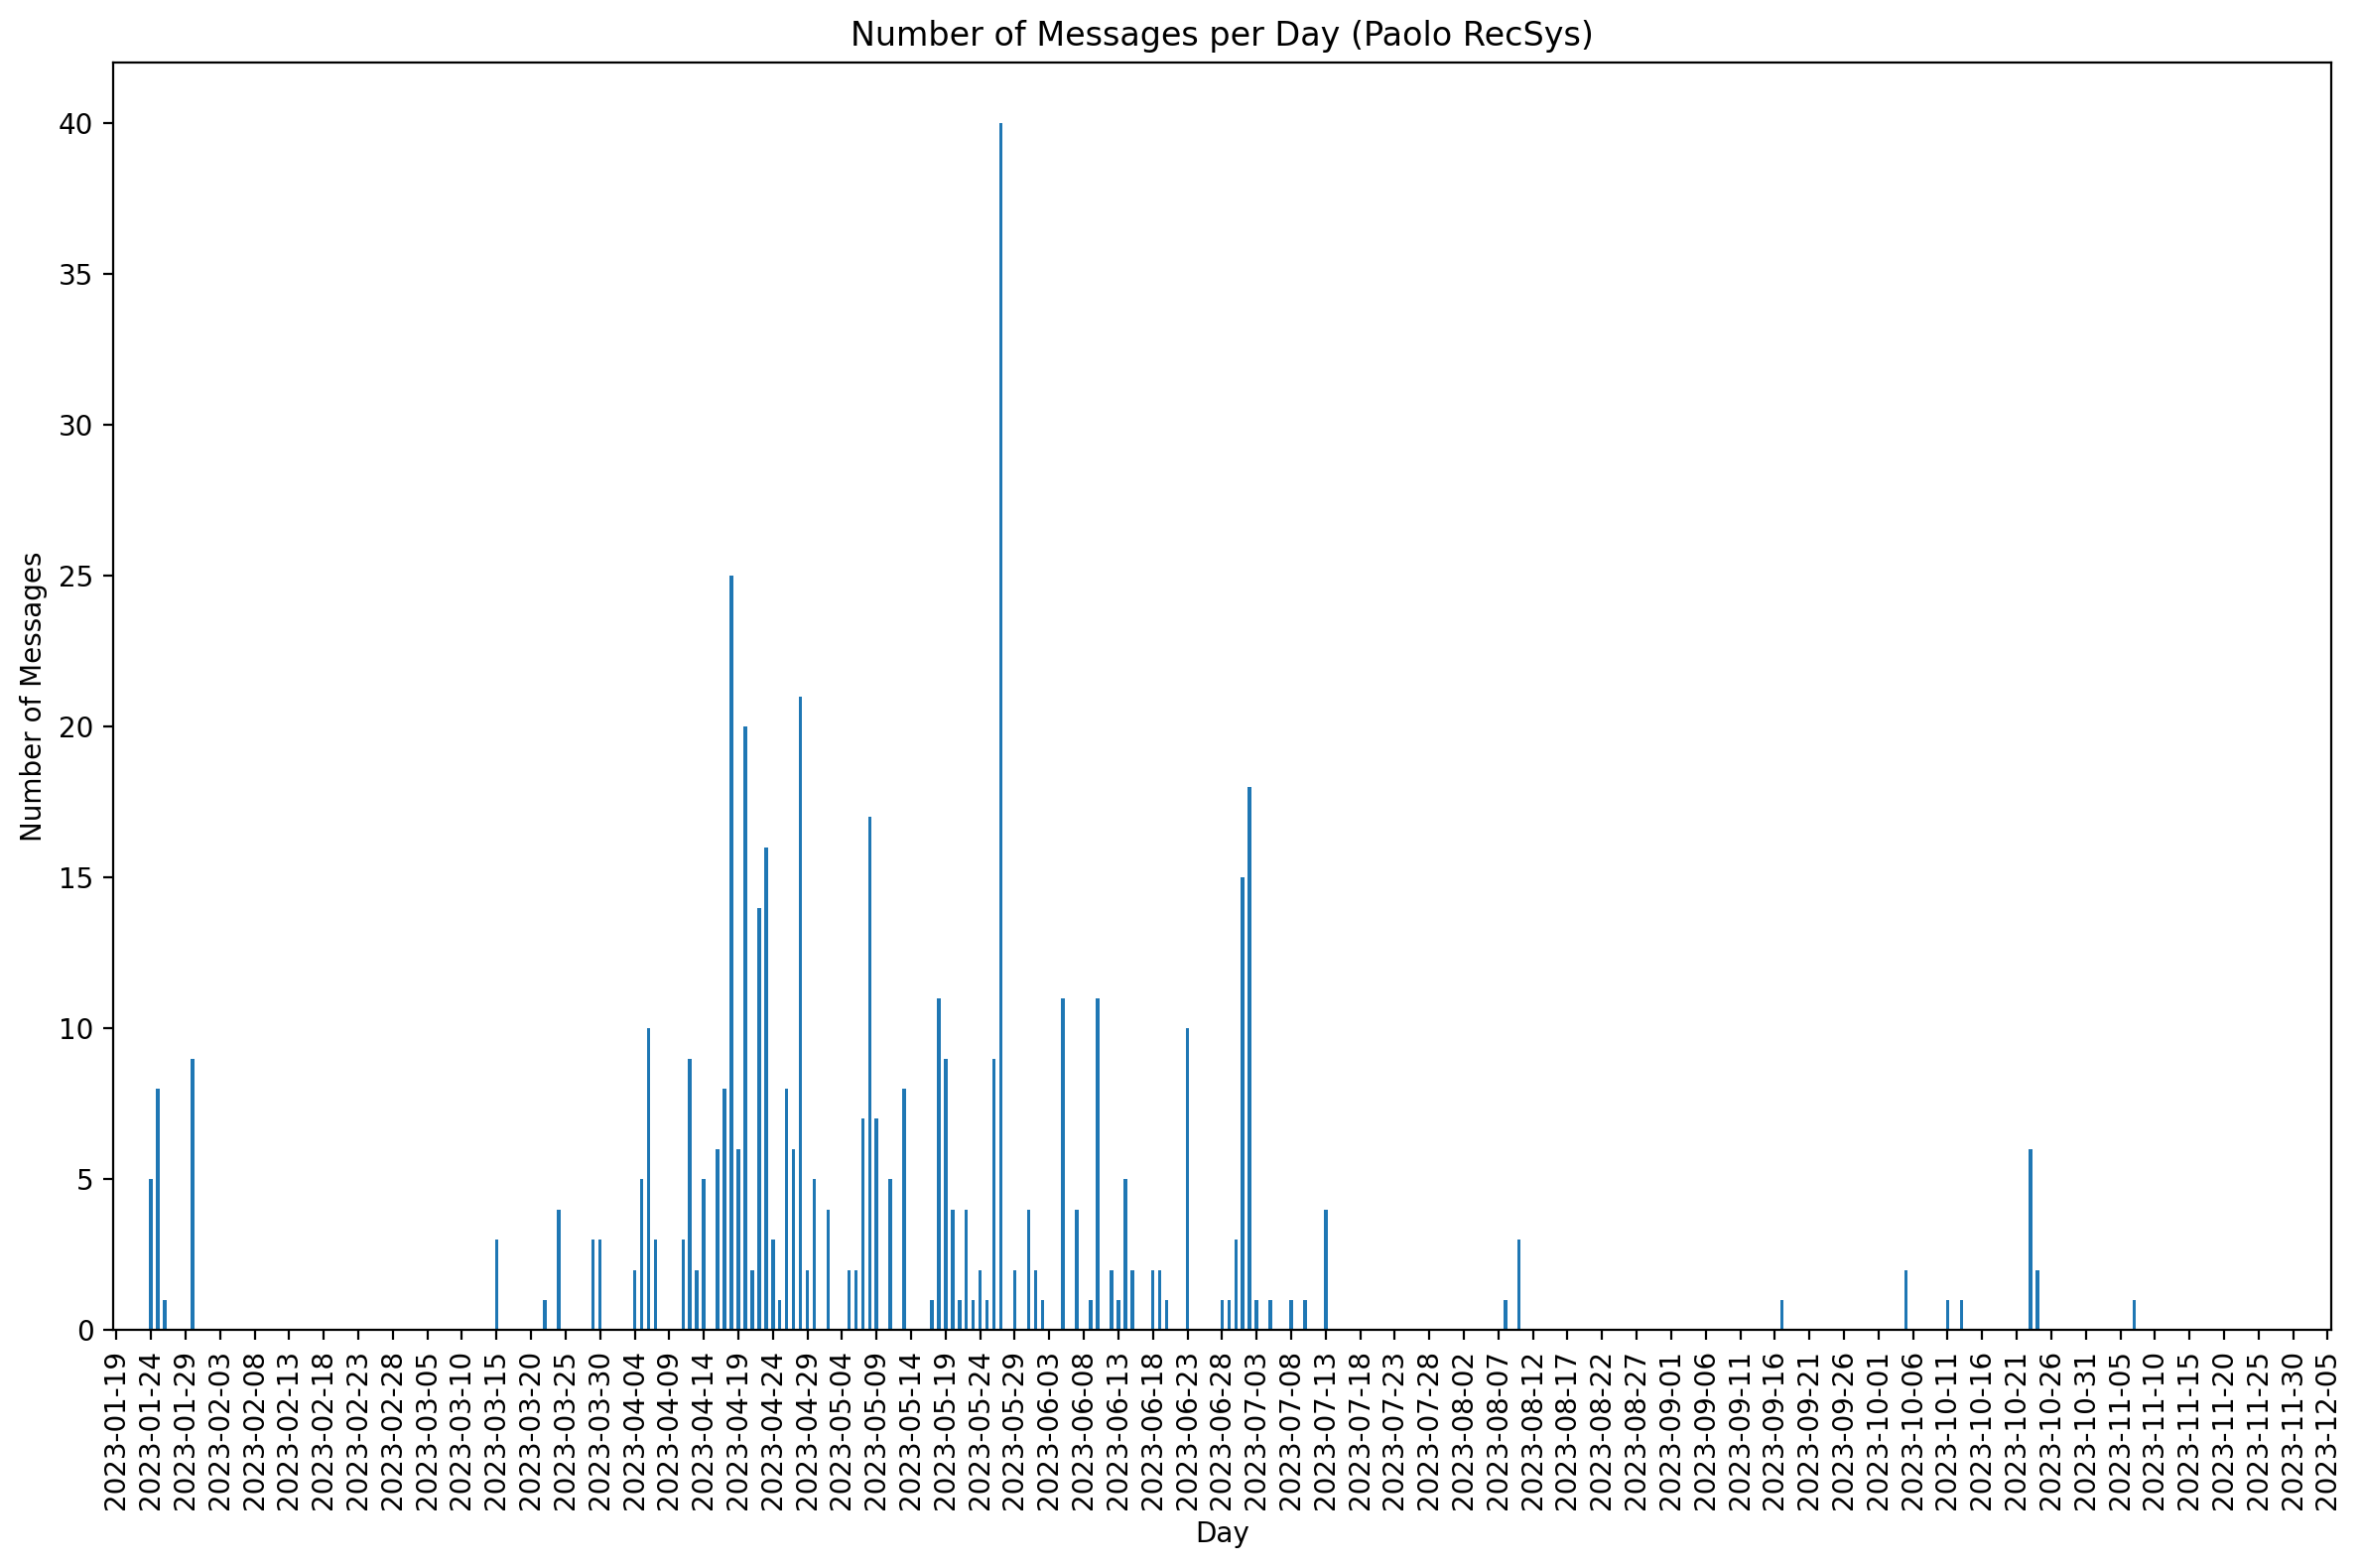

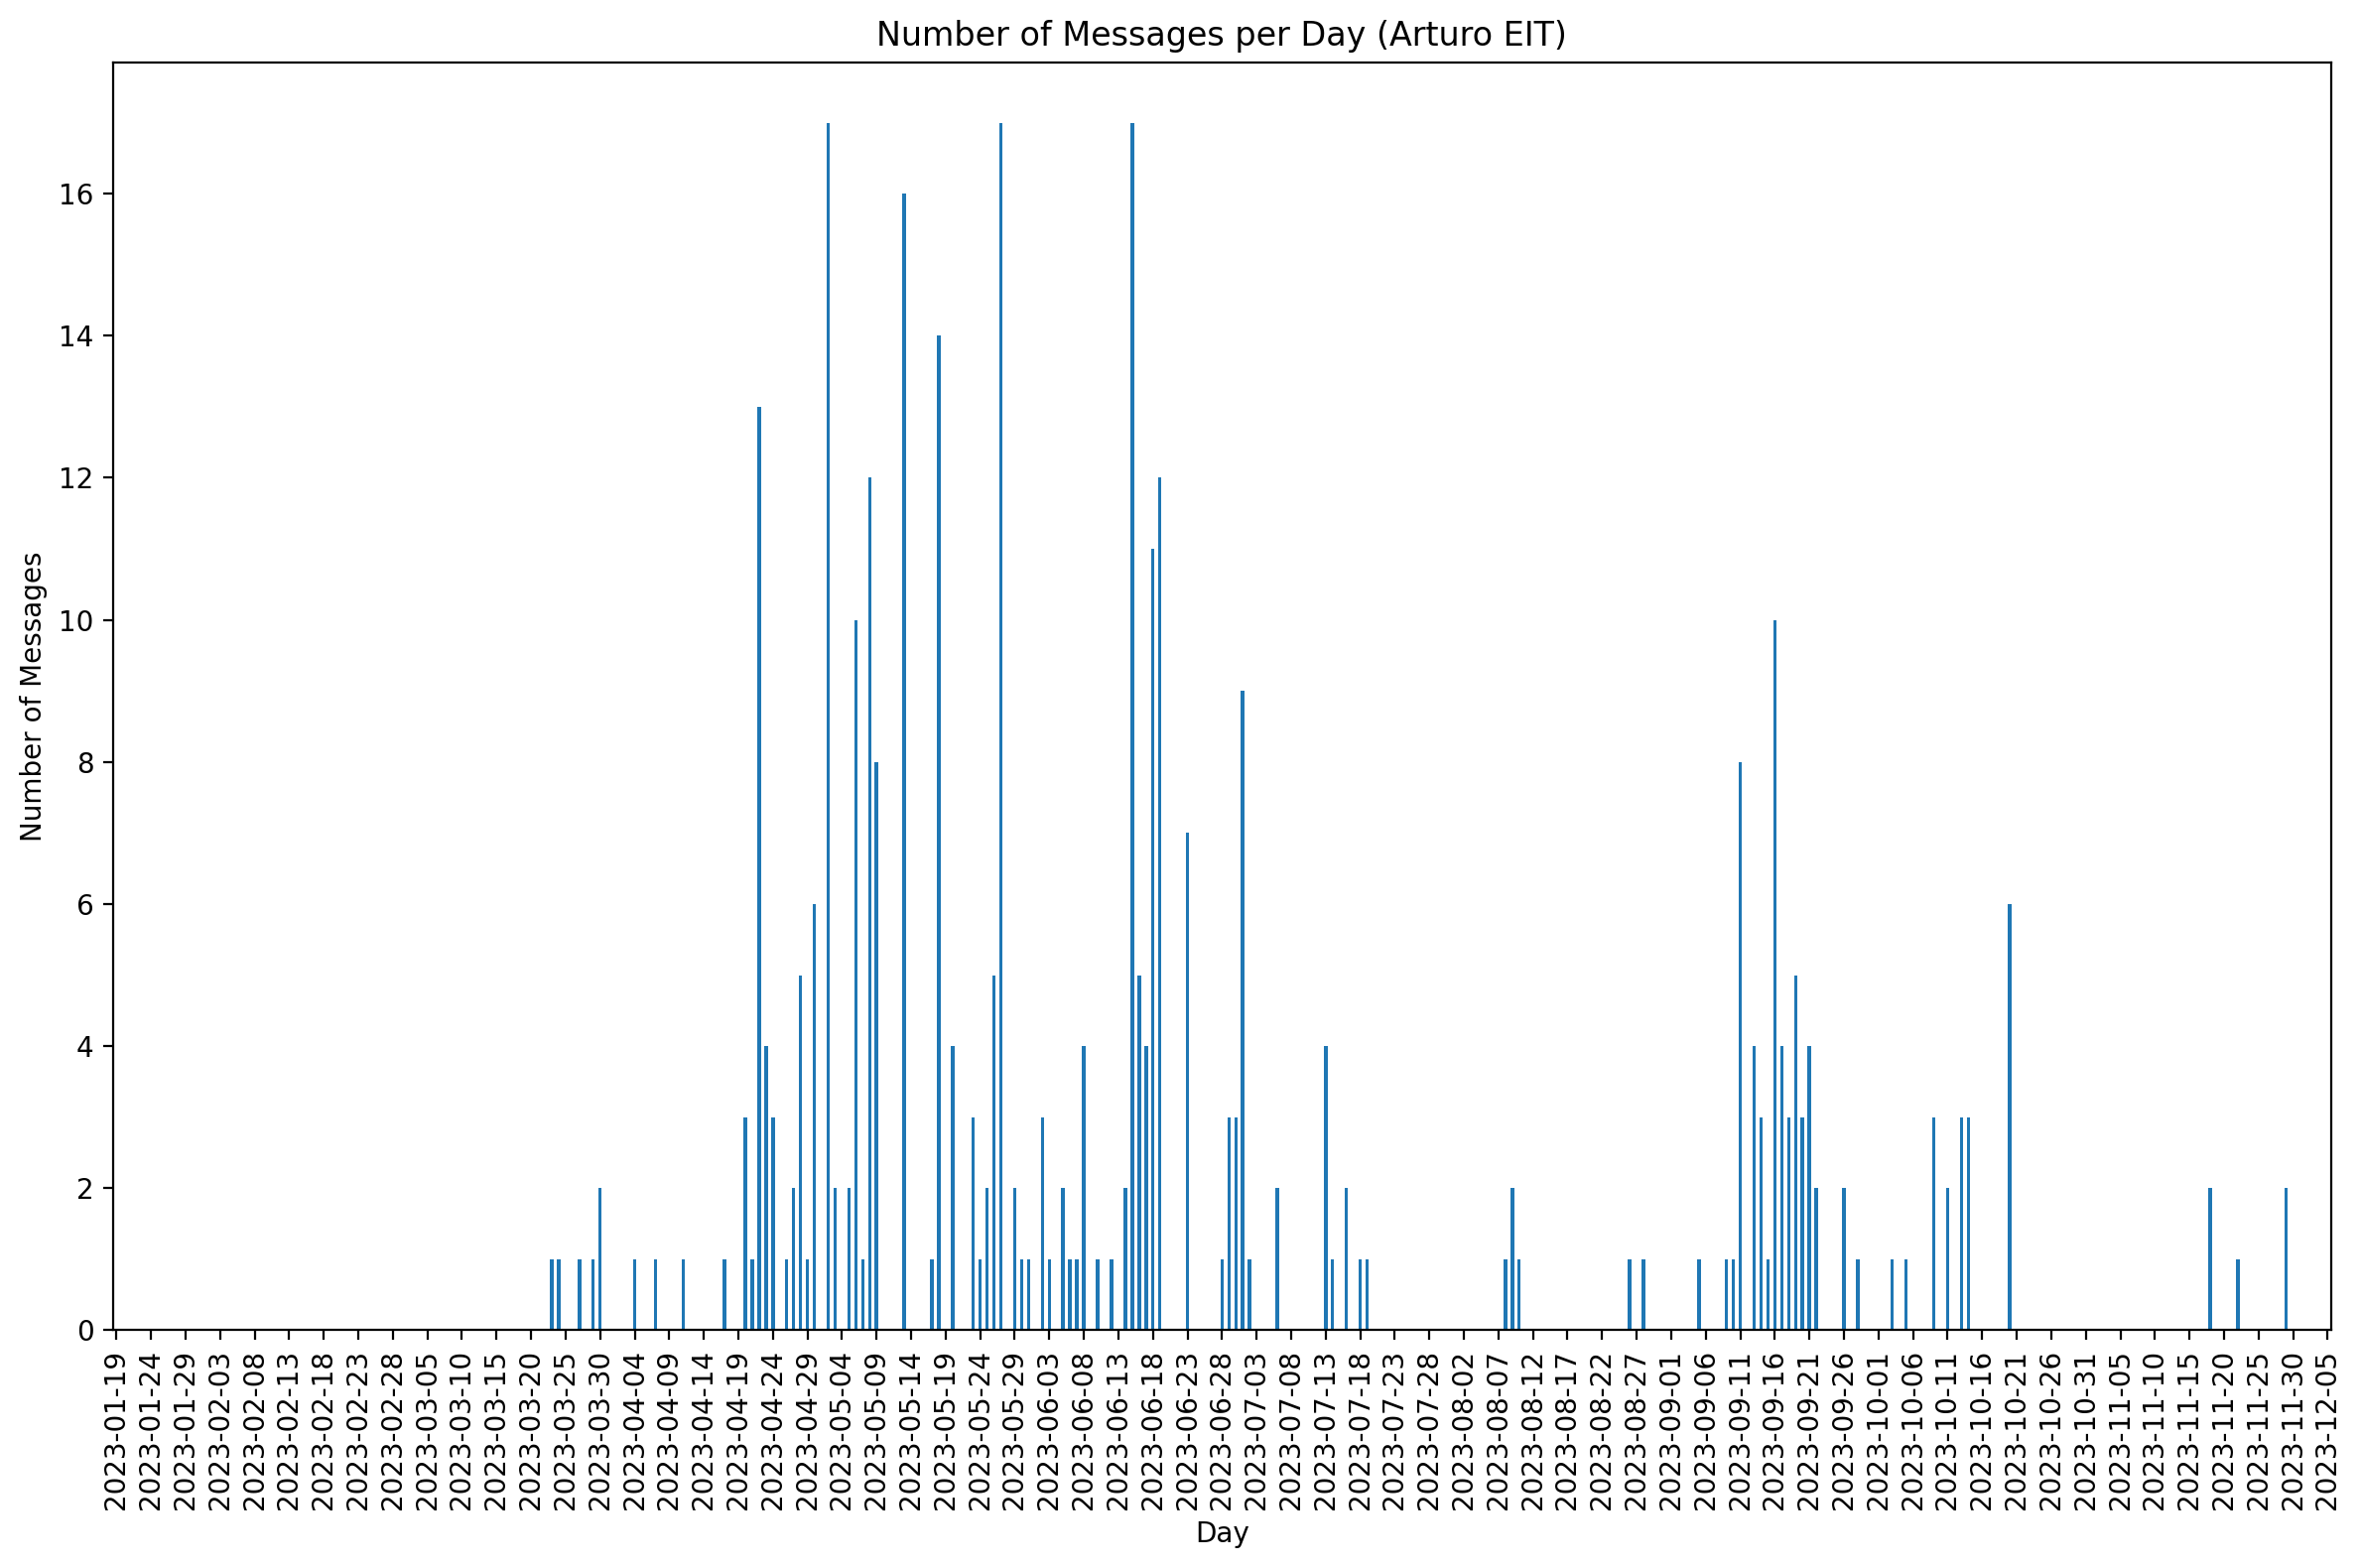

In [65]:
senders = chat['sender'].unique()

for sender in senders:
    sender_messages = chat[chat['sender'] == sender]

    # Calculate the number of messages per day for the sender
    messages_per_day_sender = sender_messages.groupby('day')['msg_id'].count()

    # Create a DatetimeIndex with all dates in the range
    date_range = pd.date_range(start=chat['day'].min(), end=chat['day'].max())

    # Reindex the data to include all dates and fill missing dates with zeros
    messages_per_day_sender = messages_per_day_sender.reindex(date_range, fill_value=0)

    plt.figure(figsize=(12, 8), dpi=200)
    messages_per_day_sender.plot(kind='bar')
    plt.xlabel('Day')
    plt.ylabel('Number of Messages')
    plt.title(f'Number of Messages per Day ({sender})')
    date_labels = messages_per_day_sender.index.strftime('%Y-%m-%d')
    plt.xticks(range(0, len(messages_per_day_sender), 5), date_labels[::5], rotation=90)

    plt.tight_layout()
    plt.show()

### Messages per day: general statistics
- Minimum number of messages in a day
- Maximum number of messages in a day
- Average number of messages in a day
- Standard deviation of the number of messages in a day

In [66]:
messages_per_day.min(), messages_per_day.max(), messages_per_day.mean(), messages_per_day.std()

(0, 523, 44.71028037383178, 73.09394759645727)

### Dates with most/least messages
We consider the 5 dates with the highest number of messages and the 5 dates with the lowest non-zero number of messages

In [67]:
messages_per_day = chat.groupby('day')['msg_id'].count()
messages_per_day = messages_per_day[messages_per_day > 0]

sorted_dates_most = messages_per_day.sort_values(ascending=False)
sorted_dates_least = messages_per_day.sort_values(ascending=True)

top_5_most = sorted_dates_most.head(5)
top_5_least = sorted_dates_least.head(5)

print("Top 5 Dates with the Most Messages:")
print(top_5_most)
print("\nTop 5 Dates with the Least Messages:")
print(top_5_least)

Top 5 Dates with the Most Messages:
day
2023-07-13    523
2023-05-13    462
2023-07-17    448
2023-05-27    322
2023-07-18    282
Name: msg_id, dtype: int64

Top 5 Dates with the Least Messages:
day
2023-01-21    1
2023-11-07    1
2023-02-20    1
2023-06-24    1
2023-10-25    2
Name: msg_id, dtype: int64


The same analysis can be portrayed for every sender

In [68]:
senders = chat['sender'].unique()

for sender in senders:
    sender_messages = chat[chat['sender'] == sender]

    messages_per_day = sender_messages.groupby('day')['msg_id'].count()
    messages_per_day = messages_per_day[messages_per_day > 0]

    sorted_dates_most = messages_per_day.sort_values(ascending=False)
    sorted_dates_least = messages_per_day.sort_values(ascending=True)

    top_5_most = sorted_dates_most.head(5)
    top_5_least = sorted_dates_least.head(5)

    print(f"\nTop 5 Dates with the Most Messages for {sender}:")
    print(top_5_most)
    print("\nTop 5 Dates with the Least Messages for {sender}:")
    print(top_5_least)


Top 5 Dates with the Most Messages for Davide EIT:
day
2023-07-17    92
2023-07-13    35
2023-09-15    23
2023-01-19    19
2023-09-28    17
Name: msg_id, dtype: int64

Top 5 Dates with the Least Messages for {sender}:
day
2023-07-02    1
2023-05-03    1
2023-10-20    1
2023-05-11    1
2023-05-26    1
Name: msg_id, dtype: int64

Top 5 Dates with the Most Messages for Nicola EIT:
day
2023-05-13    202
2023-07-17    201
2023-07-13    170
2023-05-27    163
2023-07-16    113
Name: msg_id, dtype: int64

Top 5 Dates with the Least Messages for {sender}:
day
2023-11-03    1
2023-10-02    1
2023-08-19    1
2023-02-26    1
2023-02-20    1
Name: msg_id, dtype: int64

Top 5 Dates with the Most Messages for Alessandro EIT:
day
2023-01-19    2
Name: msg_id, dtype: int64

Top 5 Dates with the Least Messages for {sender}:
day
2023-01-19    2
Name: msg_id, dtype: int64

Top 5 Dates with the Most Messages for Andrea:
day
2023-07-13    151
2023-07-14     91
2023-07-16     87
2023-07-17     80
2023-07-18

### Who sends more messages?
We can analyze the sender distribution

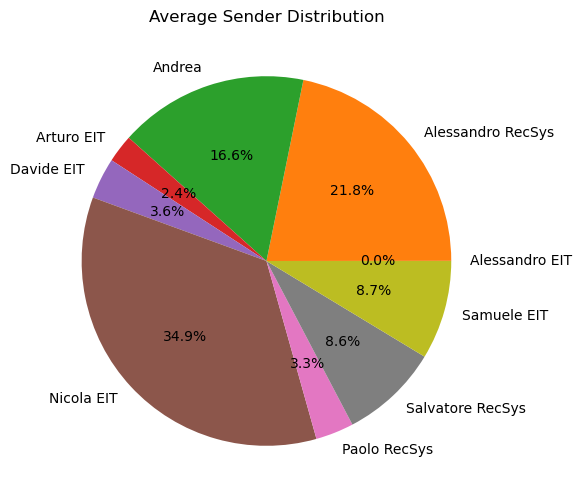

In [69]:
messages_per_sender = chat.groupby('sender')['msg_id'].count()

# Plot a pie chart of the average sender distribution
plt.figure(figsize=(6, 6))
plt.pie(messages_per_sender, labels=messages_per_sender.index, autopct='%1.1f%%')
plt.title("Average Sender Distribution")
plt.show()

### Messages per month
We check the message count per month

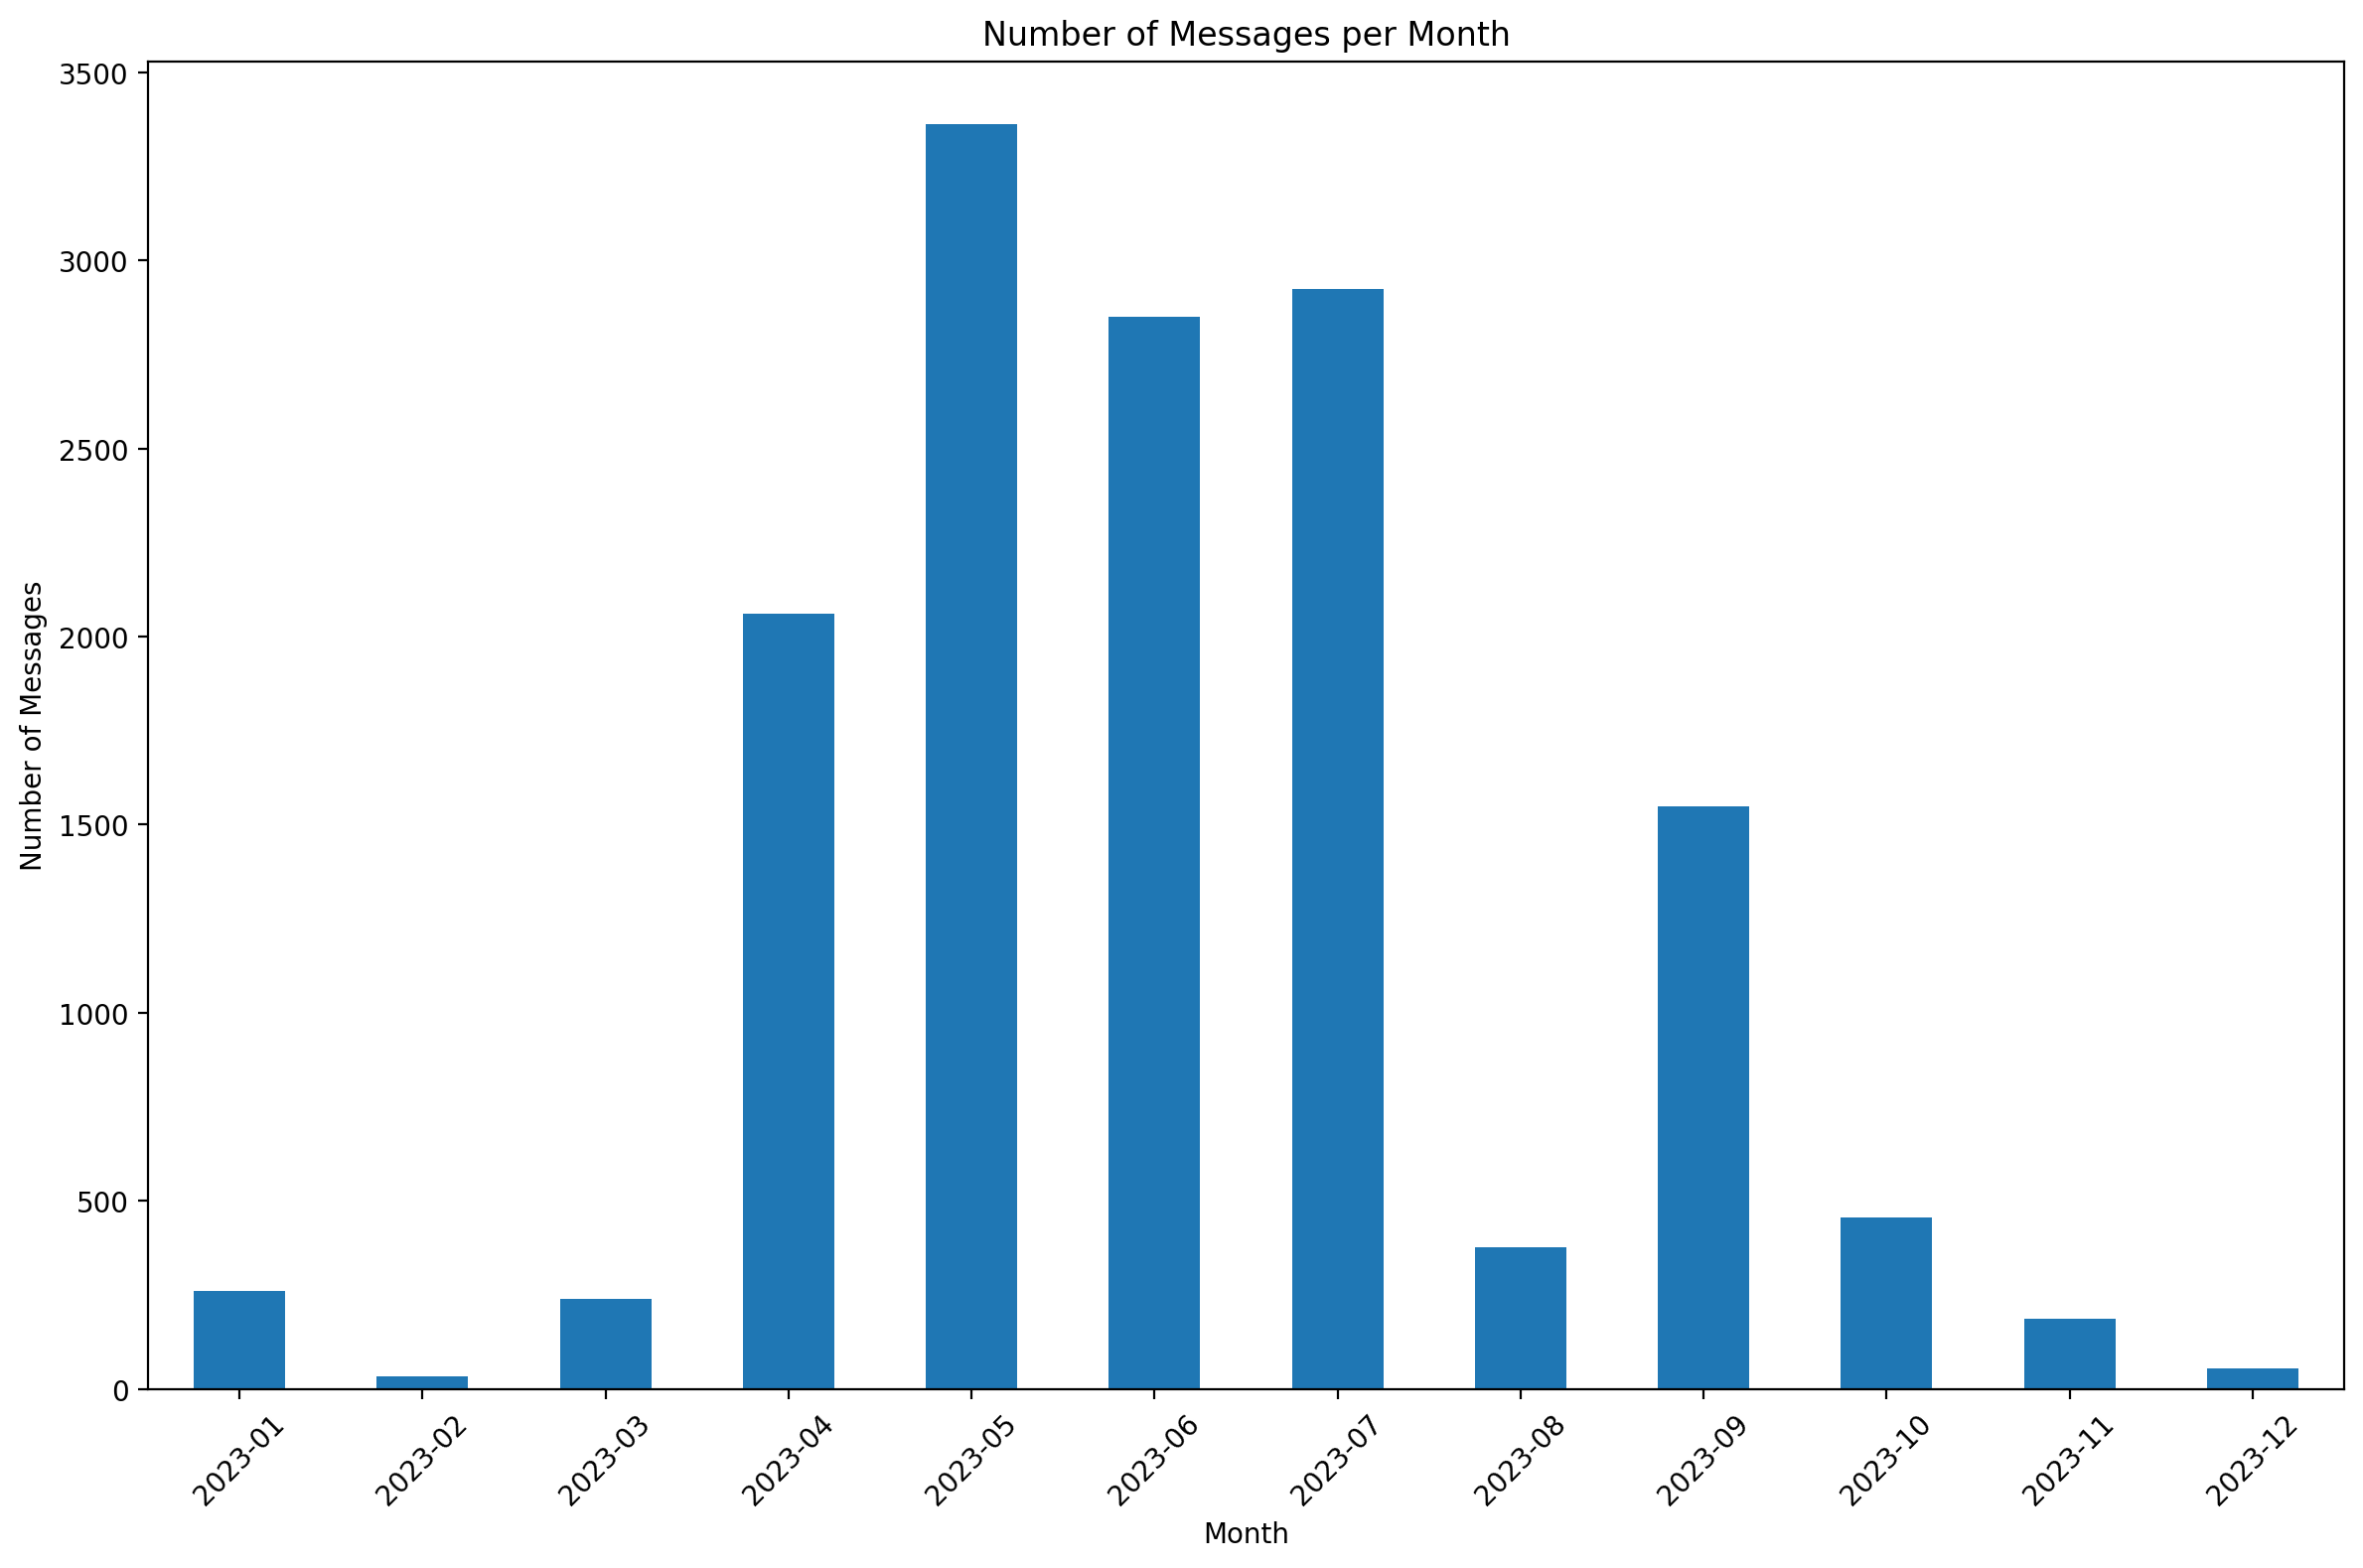

In [70]:
messages_per_month = chat.groupby(chat['day'].dt.to_period('M'))['msg_id'].count()

plt.figure(figsize=(12, 8), dpi=200)
messages_per_month.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Number of Messages')
plt.title('Number of Messages per Month')
plt.xticks(range(len(messages_per_month)), messages_per_month.index.strftime('%Y-%m'), rotation=45)
plt.tight_layout()
plt.show()

### Messages per day of the week
We check the message count per day of the week

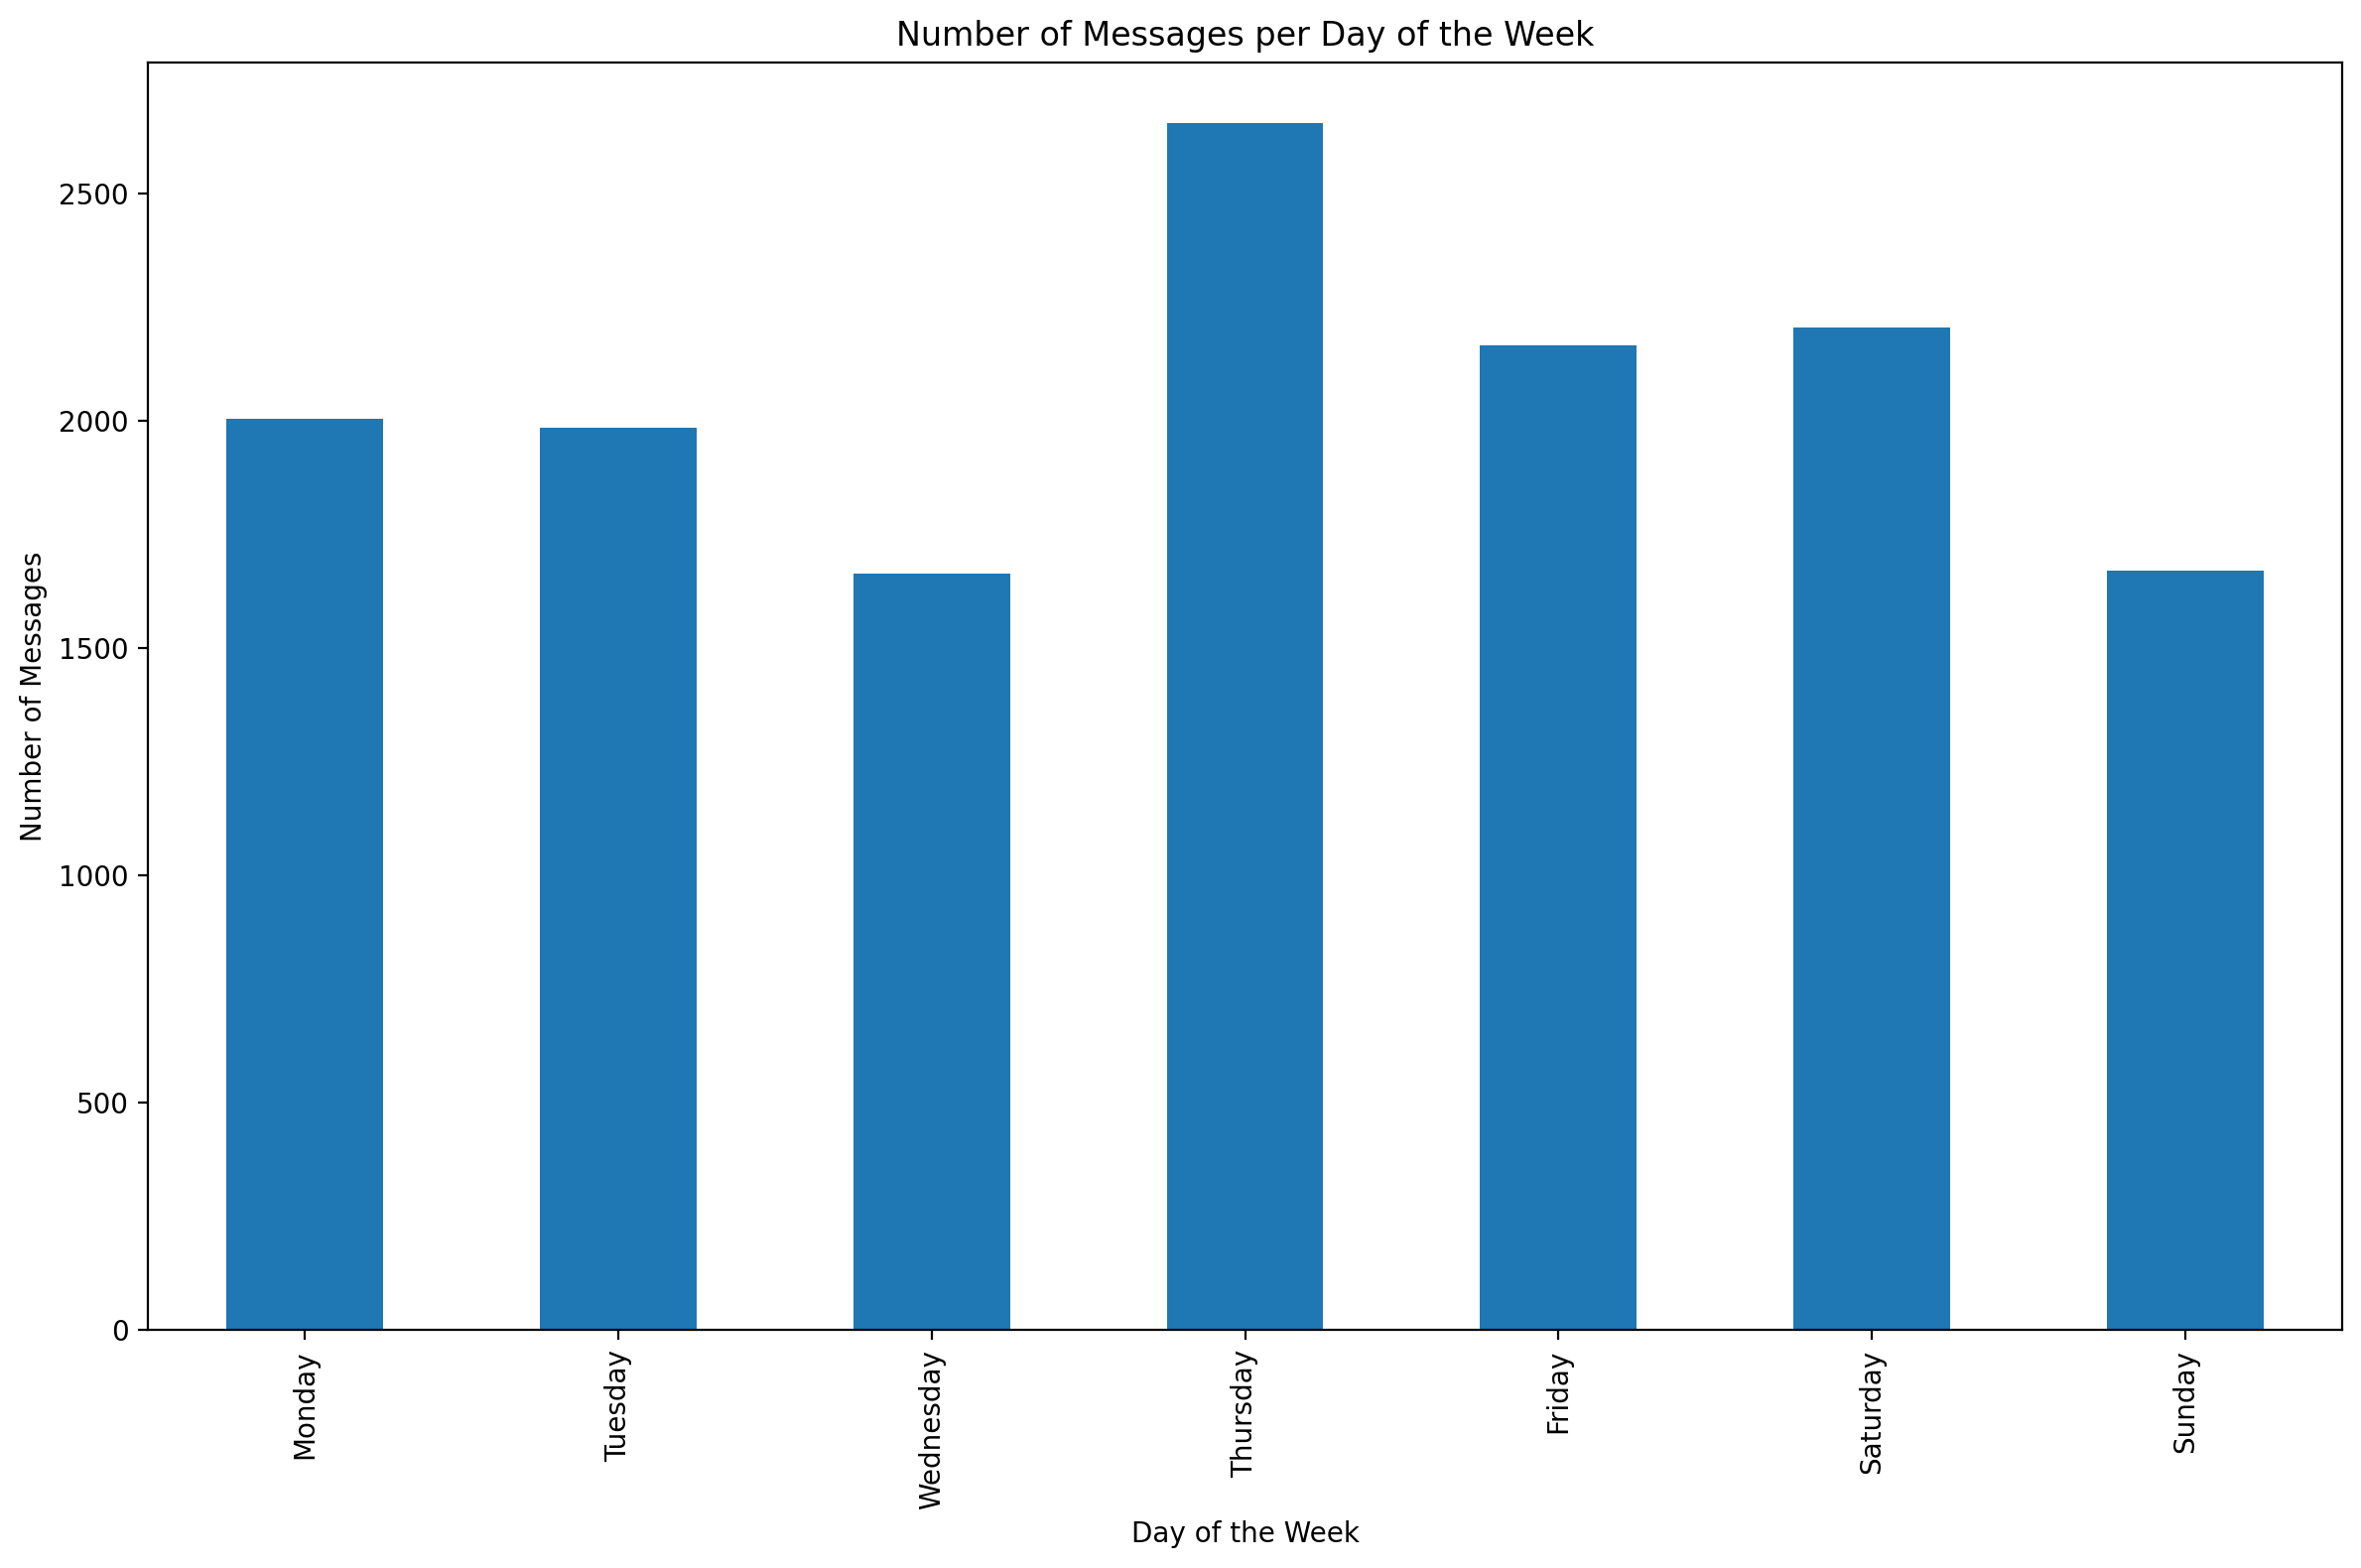

In [71]:
messages_per_day_of_week = chat.groupby(chat['day'].dt.day_name())['msg_id'].count()

days_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 8), dpi=200)
messages_per_day_of_week.loc[days_of_week_order].plot(kind='bar')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Messages')
plt.title('Number of Messages per Day of the Week')
plt.tight_layout()
plt.show()

### Messages per hour of the day
We check the message count per hour of the day

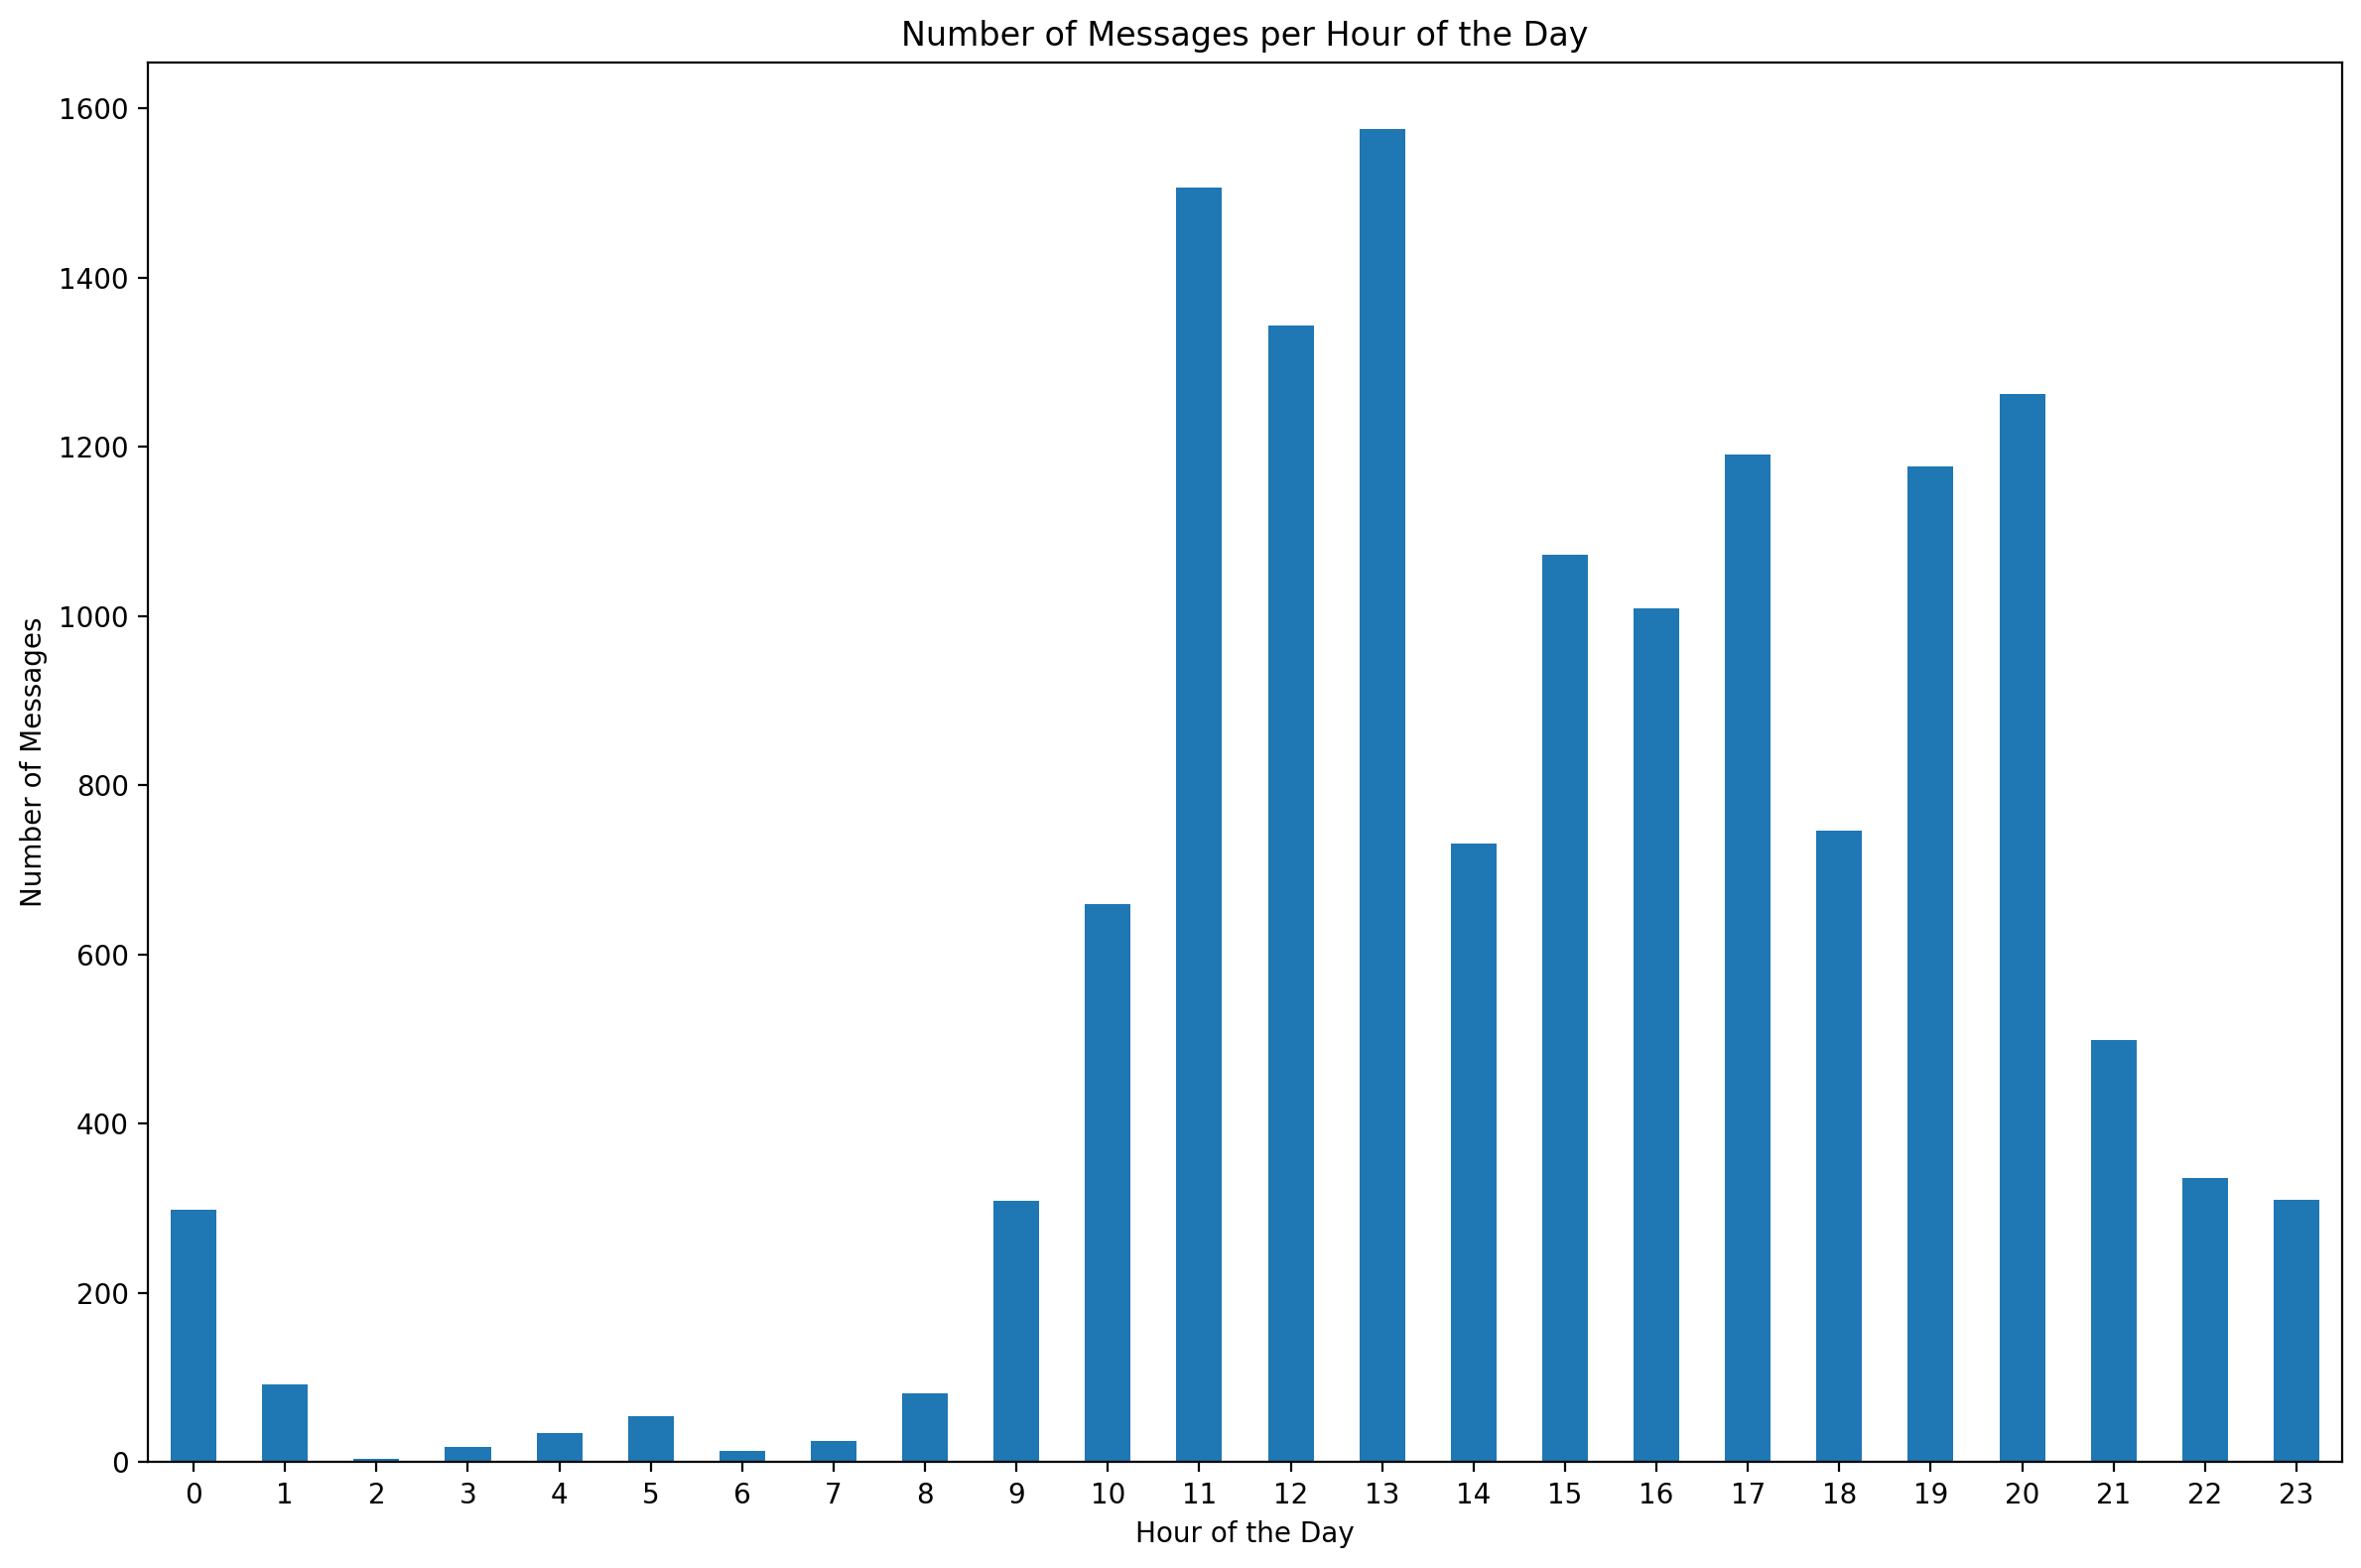

In [72]:
chat['hour'] = pd.to_datetime(chat['time']).dt.hour 

messages_per_hour = chat.groupby('hour')['msg_id'].count()

plt.figure(figsize=(12, 8), dpi=200)
messages_per_hour.plot(kind='bar', x='Hour', y='Number of Messages')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.title('Number of Messages per Hour of the Day')
plt.xticks(rotation=0) 
plt.tight_layout()
plt.show()

### By minute of hour
We check the message count by minute of hour. This rarely leads to interesting trend, but who knows!

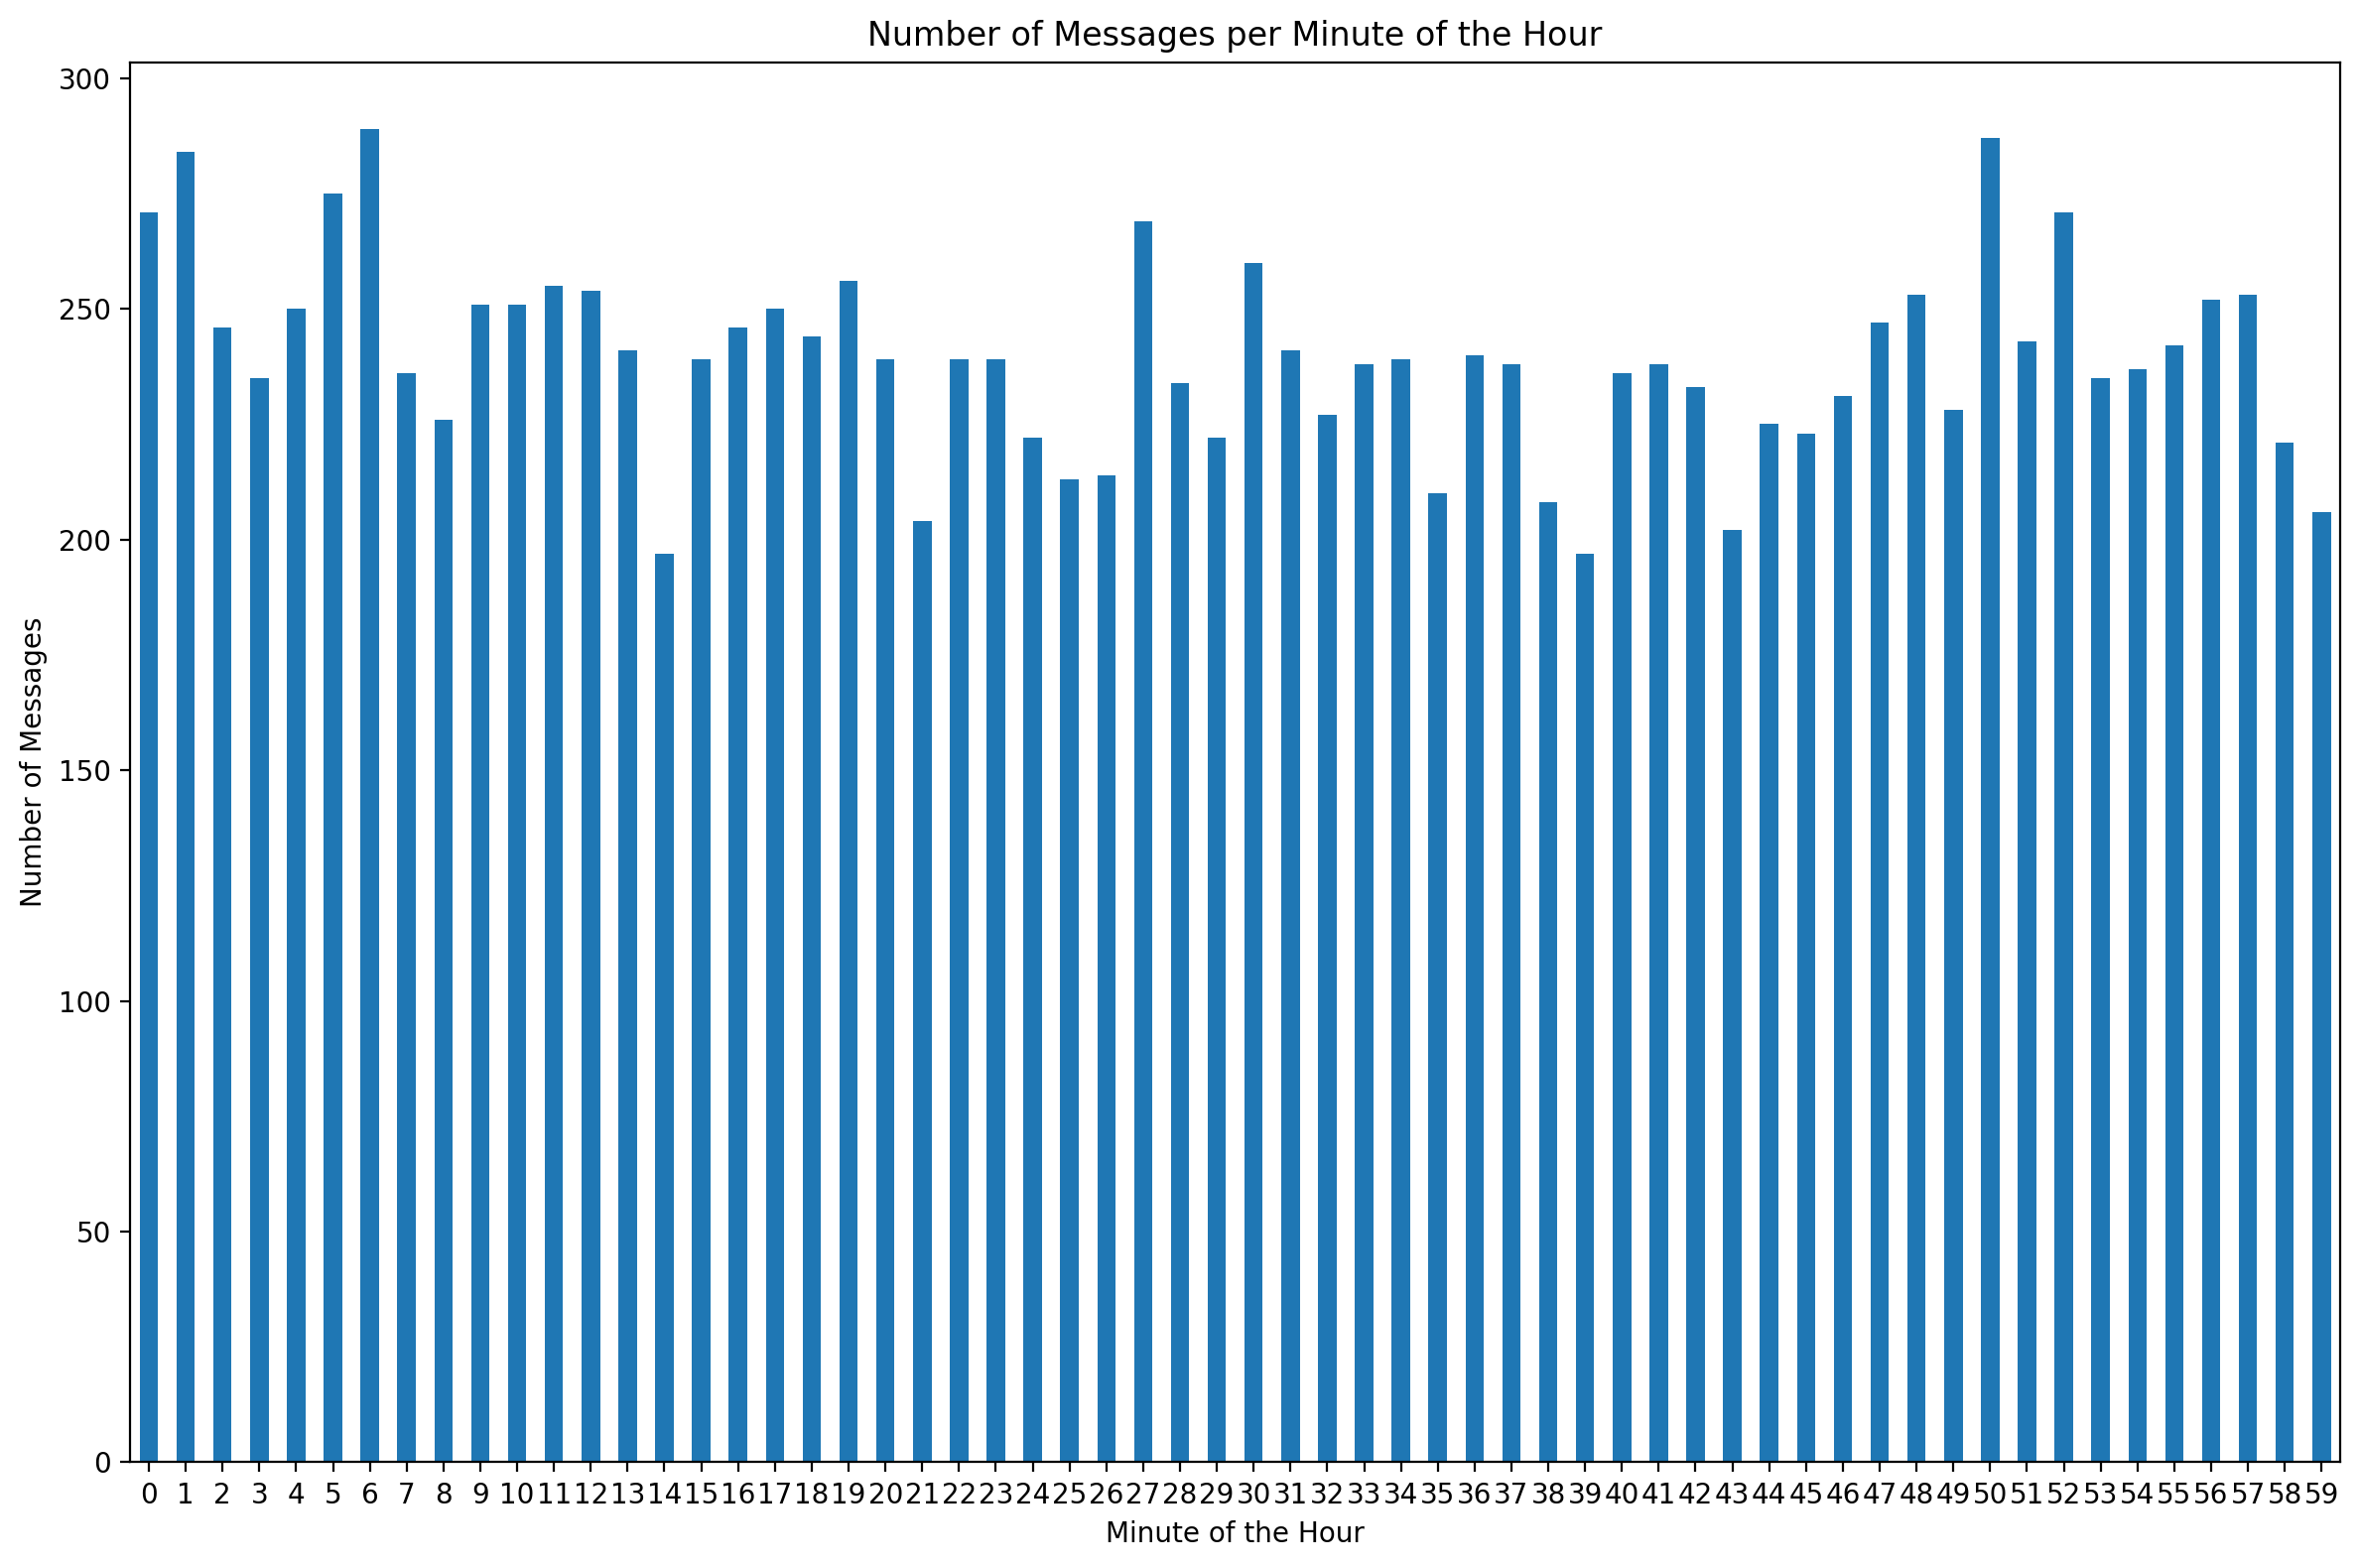

In [73]:
chat['minute'] = pd.to_datetime(chat['time']).dt.minute

messages_per_minute = chat.groupby('minute')['msg_id'].count()

plt.figure(figsize=(12, 8), dpi=200)
messages_per_minute.plot(kind='bar', x='Minute', y='Number of Messages')
plt.xlabel('Minute of the Hour')
plt.ylabel('Number of Messages')
plt.title('Number of Messages per Minute of the Hour')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Common words
This analysis has been portrayed considering the italian language. We are about to discover what are the most common words in the chat, globally.

It is possible (and advised) to add custom stopwords (words to exclude)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Average Word Count per Message: 4.44


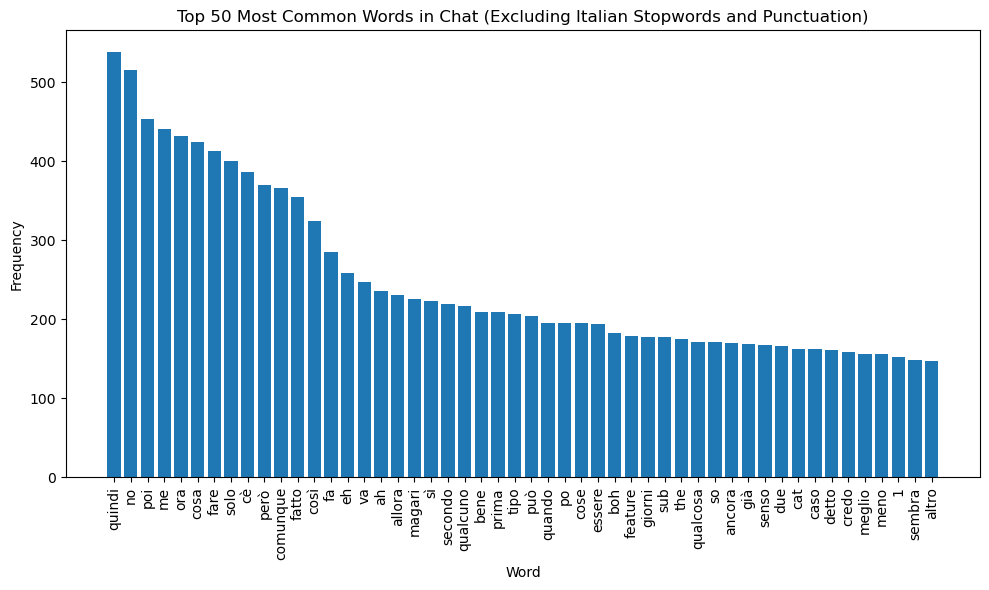

In [94]:
custom_stopwords = ['file', 'not', 'included', 'change', 'data', 'exporting', 'settings', 'to', 'download'] # add yours! (lowercase)

italian_stopwords = set(stopwords.words('italian')).union(set(custom_stopwords))

chat['msg_content'] = chat['msg_content'].apply(lambda x: str(x))
chat['msg_content_lower'] = chat['msg_content'].str.lower()

nltk.download('stopwords')


def remove_stopwords_punctuation(text):
    if not isinstance(text, str):
        text = ''
    
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = word_tokenize(text)
    custom_filter_list = ['’', '`']
    filtered_tokens = [word for word in tokens if word.lower() not in italian_stopwords and word not in custom_filter_list]
    
    return ' '.join(filtered_tokens)

chat['msg_content_lower'] = chat['msg_content_lower'].apply(remove_stopwords_punctuation)

chat['word_count'] = chat['msg_content_lower'].apply(lambda x: len(word_tokenize(x)))

average_word_count = chat['word_count'].mean()
print(f'Average Word Count per Message: {average_word_count:.2f}')

all_words = word_tokenize(' '.join(chat['msg_content_lower']))
word_count_dict = Counter(all_words)

top_words = word_count_dict.most_common(50)

top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(10, 6))
plt.bar(top_words_df['Word'], top_words_df['Frequency'])
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 50 Most Common Words in Chat (Excluding Italian Stopwords and Punctuation)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

And you can do the same per sender

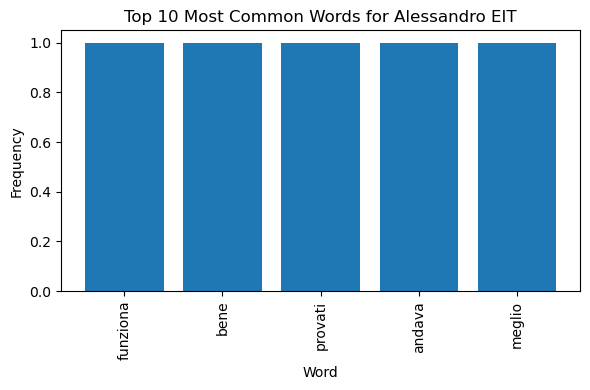

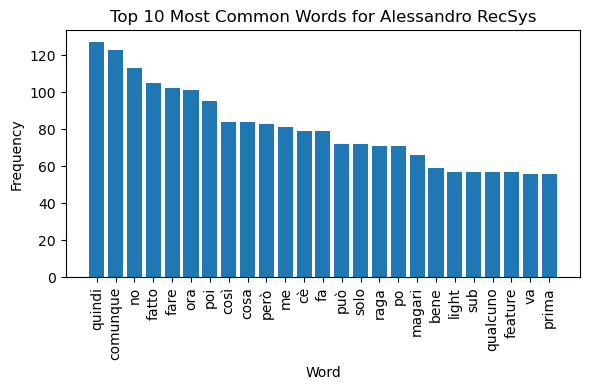

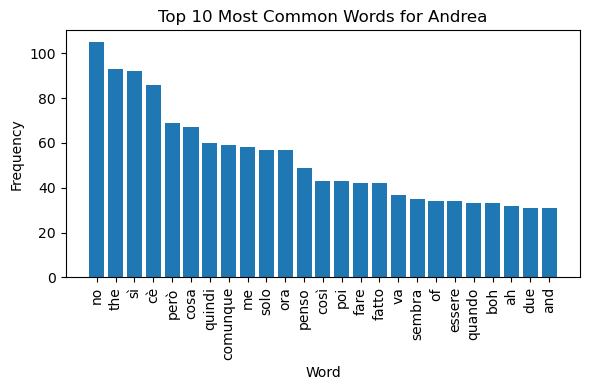

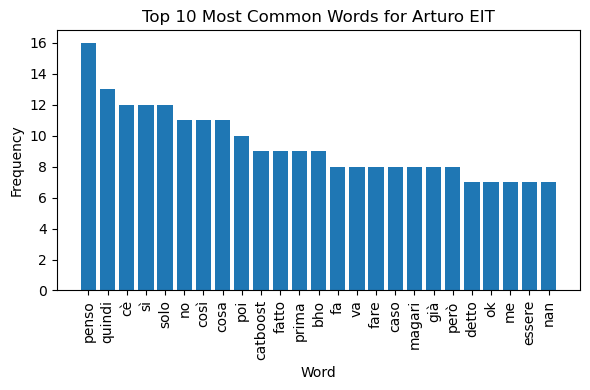

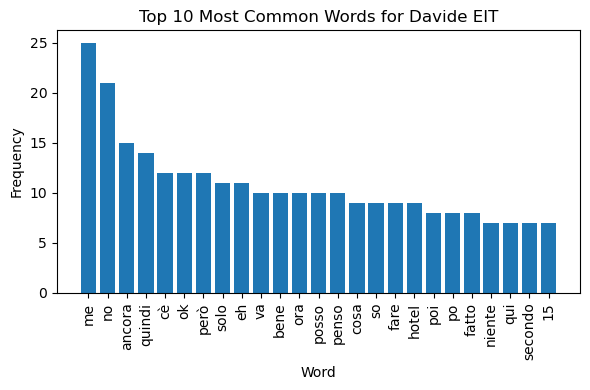

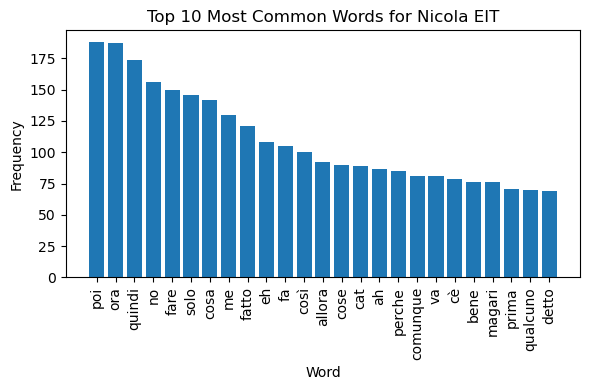

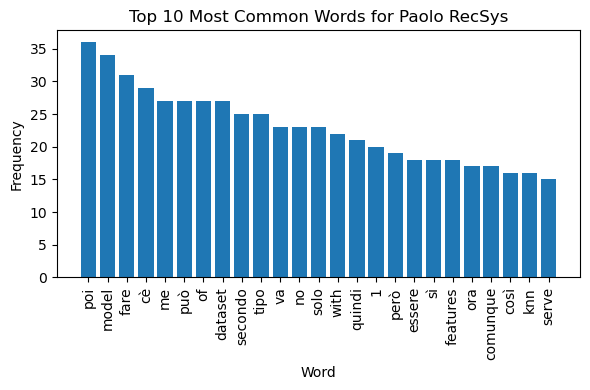

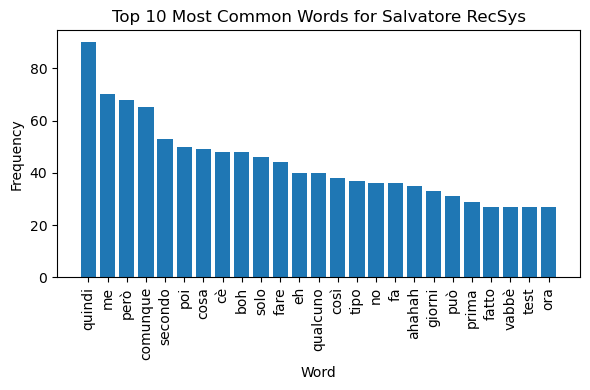

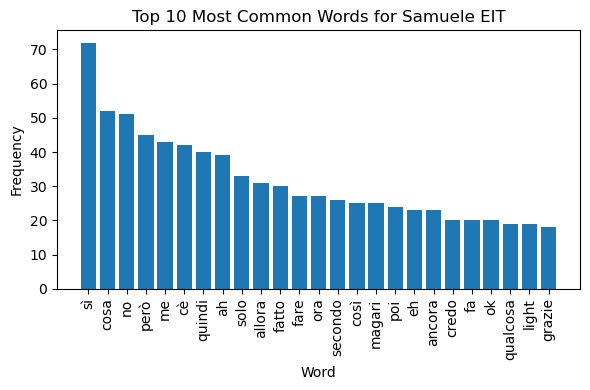

In [95]:
grouped_chat = chat.groupby('sender')['msg_content_lower'].apply(lambda x: ' '.join(x))

sender_word_counts = {}
for sender, messages in grouped_chat.items():
    messages_cleaned = remove_stopwords_punctuation(messages)
    tokens = word_tokenize(messages_cleaned)
    word_count_dict = Counter(tokens)
    sender_word_counts[sender] = word_count_dict

for sender, word_count_dict in sender_word_counts.items():
    top_words = word_count_dict.most_common(25)
    top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
    plt.figure(figsize=(6, 4))
    plt.bar(top_words_df['Word'], top_words_df['Frequency'])
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Most Common Words for {sender}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

### Message length
The message length can be measured in two ways
- Counting the words
- Counting the characters

We are using a logarithmic scale to highlight the differences

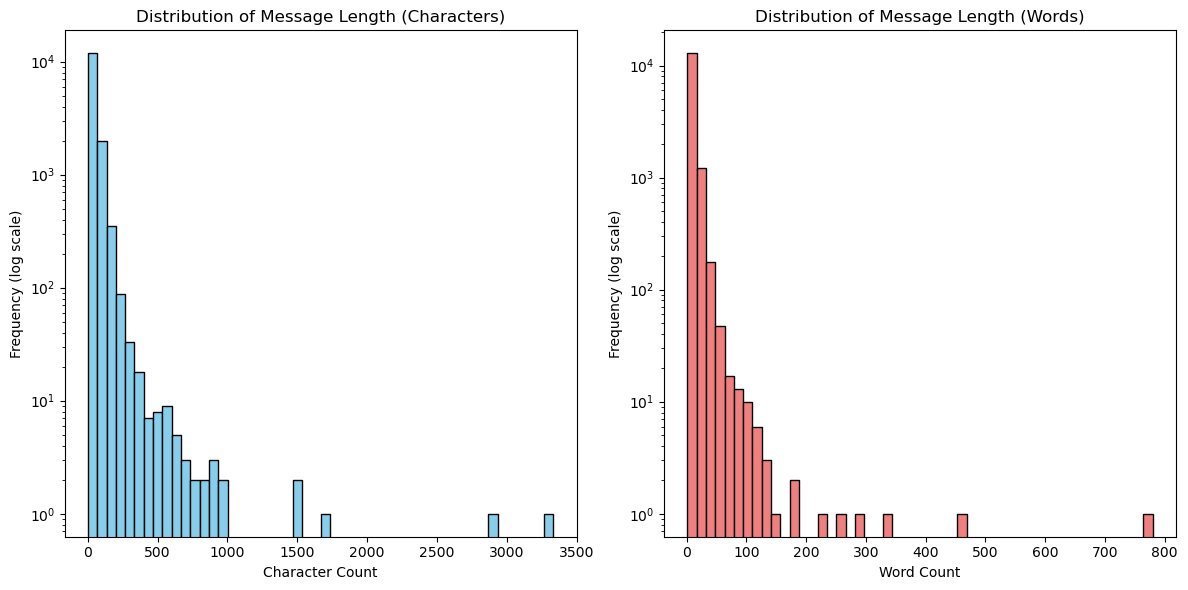

In [76]:
chat['char_count'] = chat['msg_content'].apply(len)
chat['word_count'] = chat['msg_content'].apply(lambda x: len(word_tokenize(x)))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(chat['char_count'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Character Count')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Message Length (Characters)')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.hist(chat['word_count'], bins=50, color='lightcoral', edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Message Length (Words)')
plt.yscale('log')

plt.tight_layout()
plt.show()

And we plot it also for each sender

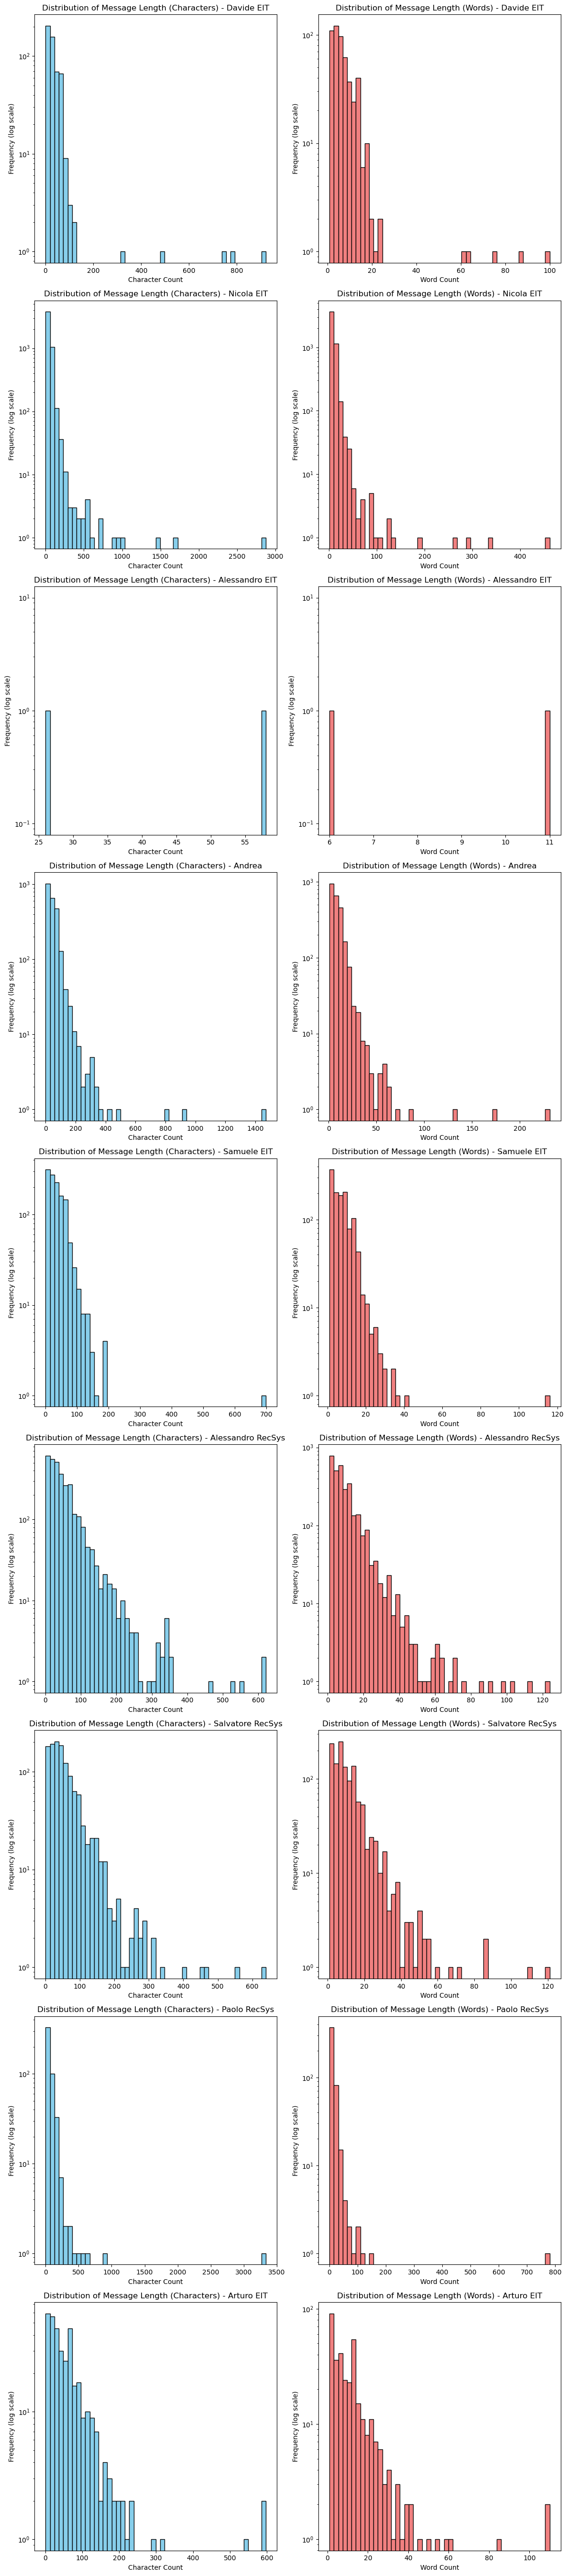

In [77]:
senders = chat['sender'].unique()

plt.figure(figsize=(12, 6 * len(senders)))

for i, sender in enumerate(senders):
    sender_chat = chat[chat['sender'] == sender]

    plt.subplot(len(senders), 2, i * 2 + 1)
    plt.hist(sender_chat['char_count'], bins=50, color='skyblue', edgecolor='black')
    plt.xlabel('Character Count')
    plt.ylabel('Frequency (log scale)')
    plt.title(f'Distribution of Message Length (Characters) - {sender}')
    plt.yscale('log')

    plt.subplot(len(senders), 2, i * 2 + 2)
    plt.hist(sender_chat['word_count'], bins=50, color='lightcoral', edgecolor='black')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency (log scale)')
    plt.title(f'Distribution of Message Length (Words) - {sender}')
    plt.yscale('log')

plt.tight_layout()
plt.show()

### Response time
The response time indicates how long it took to answer

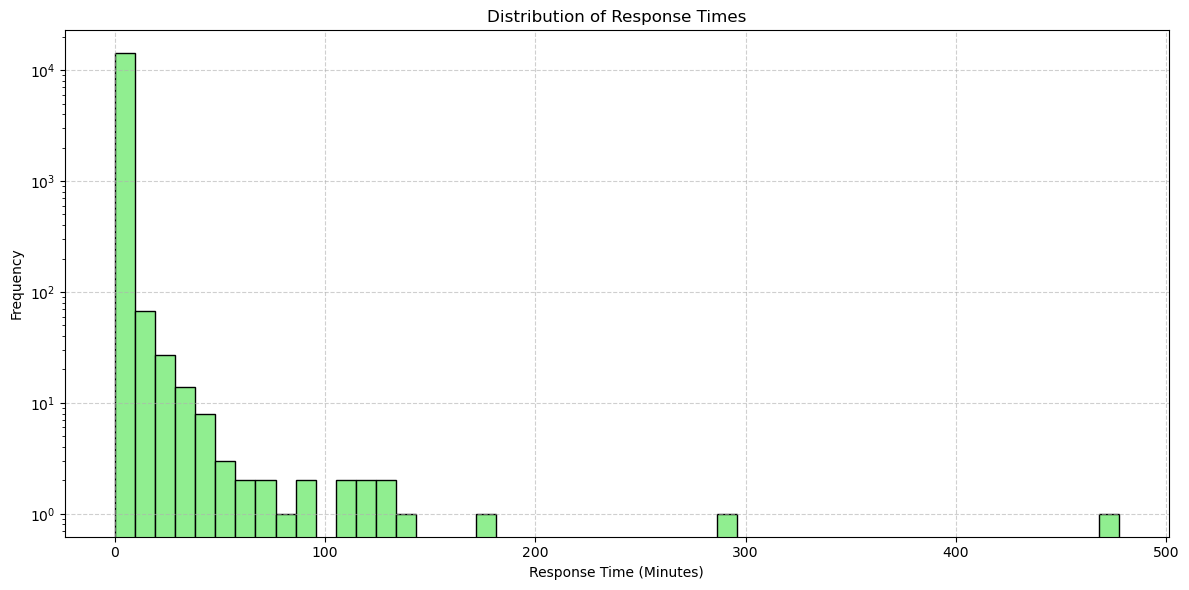

In [78]:
chat['time'] = pd.to_datetime(chat['time'])

chat = chat.sort_values(['sender', 'time'])

chat['response_time'] = chat.groupby('sender')['time'].diff()

chat['response_time_minutes'] = chat['response_time'].dt.total_seconds() / 60

plt.figure(figsize=(12, 6))
plt.hist(chat['response_time_minutes'].dropna(), bins=50, color='lightgreen', edgecolor='black')
plt.xlabel('Response Time (Minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Times')
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

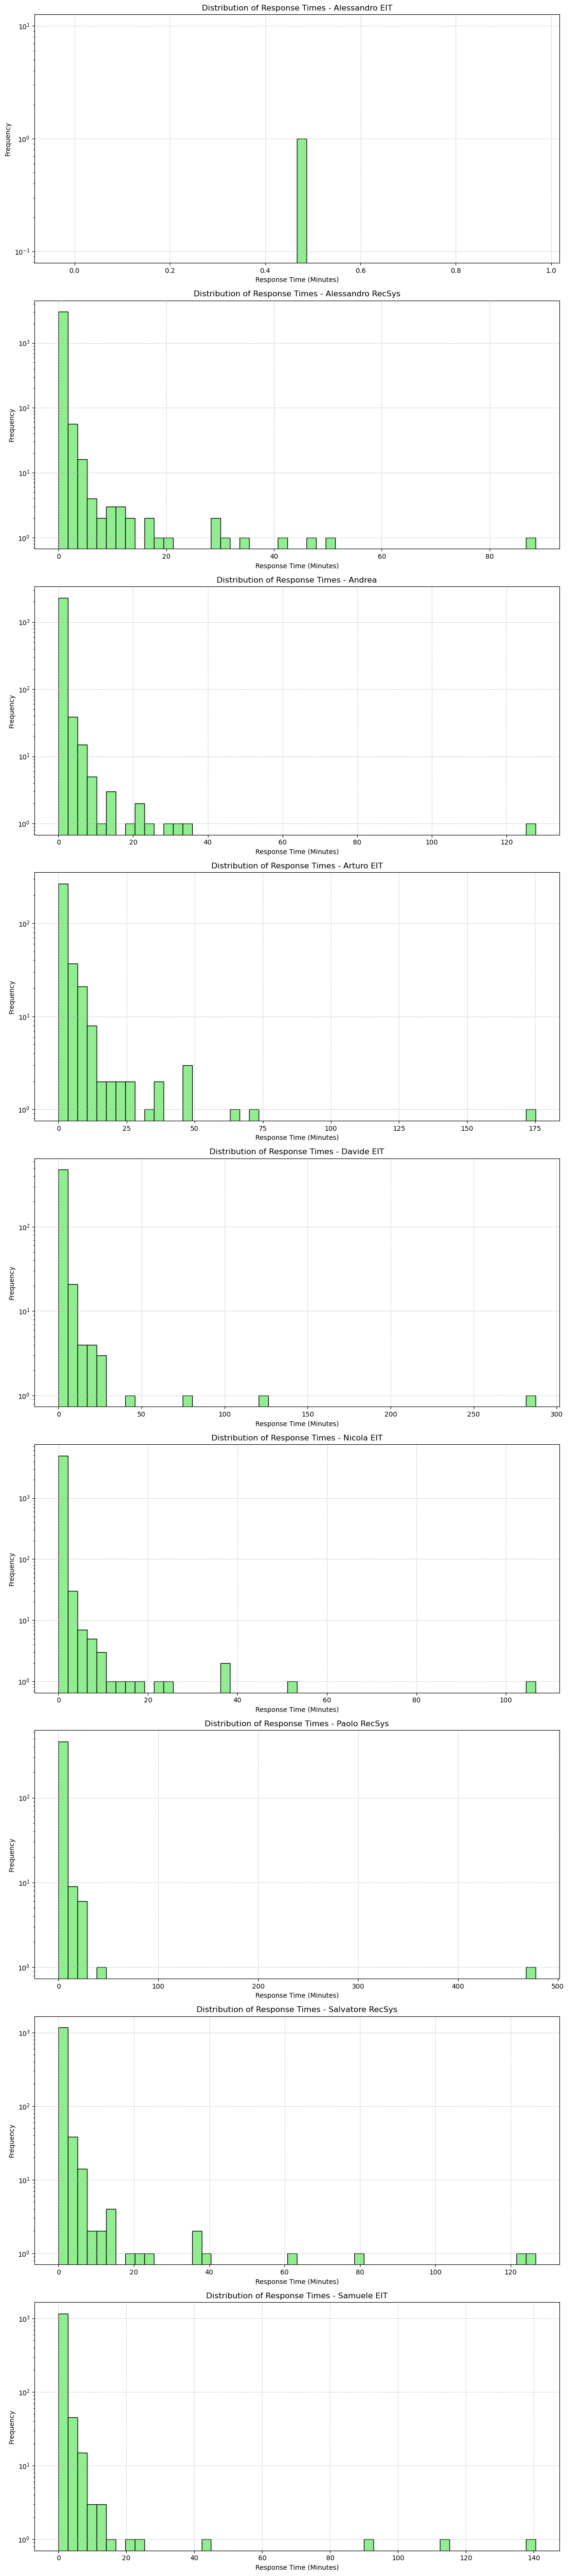

In [79]:
senders = chat['sender'].unique()

plt.figure(figsize=(12, 6 * len(senders)))

for i, sender in enumerate(senders):
    sender_chat = chat[chat['sender'] == sender]

    plt.subplot(len(senders), 1, i+1)
    plt.hist(sender_chat['response_time_minutes'].dropna(), bins=50, color='lightgreen', edgecolor='black')
    plt.xlabel('Response Time (Minutes)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Response Times - {sender}')
    plt.yscale('log')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

plt.show()

### Topic Identification
Topic modelling using LDA.

In the context of natural language processing and topic modeling, a _topic_ represents a coherent and meaningful theme or subject that emerges from the analysis of a collection of text documents.

In [80]:
nltk.download('punkt')
chat['tokens'] = chat['msg_content_lower'].apply(lambda x: word_tokenize(x))

nltk.download('stopwords')
stop_words = set(stopwords.words('italian'))
chat['filtered_tokens'] = chat['tokens'].apply(lambda tokens: [remove_stopwords_punctuation(word) for word in tokens if word.lower() not in stop_words])

dictionary = corpora.Dictionary(chat['filtered_tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in chat['filtered_tokens']]

lda_model = gensim.models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

topics = lda_model.print_topics(num_words=10)
topics

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrea\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[(0,
  '0.033*"solo" + 0.027*"essere" + 0.024*"quindi" + 0.021*"domani" + 0.019*"qualcuno" + 0.016*"può" + 0.016*"dovrebbe" + 0.012*"oggi" + 0.012*"beh" + 0.011*"pare"'),
 (1,
  '0.020*"scritto" + 0.020*"tanto" + 0.019*"poi" + 0.018*"capito" + 0.017*"te" + 0.015*"comunque" + 0.014*"già" + 0.013*"boh" + 0.012*"dato" + 0.011*"ce"'),
 (2,
  '0.096*"file" + 0.083*"data" + 0.076*"settings" + 0.076*"download" + 0.076*"change" + 0.076*"exporting" + 0.076*"included" + 0.031*"sì" + 0.014*"the" + 0.011*"vero"'),
 (3,
  '0.018*"posso" + 0.016*"giusto" + 0.015*"invece" + 0.015*"validation" + 0.013*"cera" + 0.011*"basta" + 0.010*"stesso" + 0.010*"comunque" + 0.010*"sì" + 0.010*"possono"'),
 (4,
  '0.035*"ah" + 0.025*"test" + 0.025*"però" + 0.023*"tipo" + 0.021*"eh" + 0.017*"problema" + 0.016*"solo" + 0.016*"1" + 0.014*"2" + 0.012*"train"'),
 (5,
  '0.024*"fare" + 0.020*"magari" + 0.018*"detto" + 0.016*"qualcosa" + 0.015*"poi" + 0.013*"modo" + 0.012*"dataset" + 0.012*"po" + 0.012*"serve" + 0.011*"se

### Sentiment analysis
This model works for the italian language. However, it has no "neutral" class and therefore each message will be considered as either "positive" or "negative"

In [81]:
emotion_classifier = EmotionClassifier()
sentiment_classifier = SentimentClassifier()

sentiments = []

for msg in tqdm(chat['msg_content']):
    sentiment = sentiment_classifier.predict([msg])[0]
    sentiments.append(sentiment)

chat['sentiment'] = sentiments

100%|██████████| 14352/14352 [13:55<00:00, 17.19it/s]


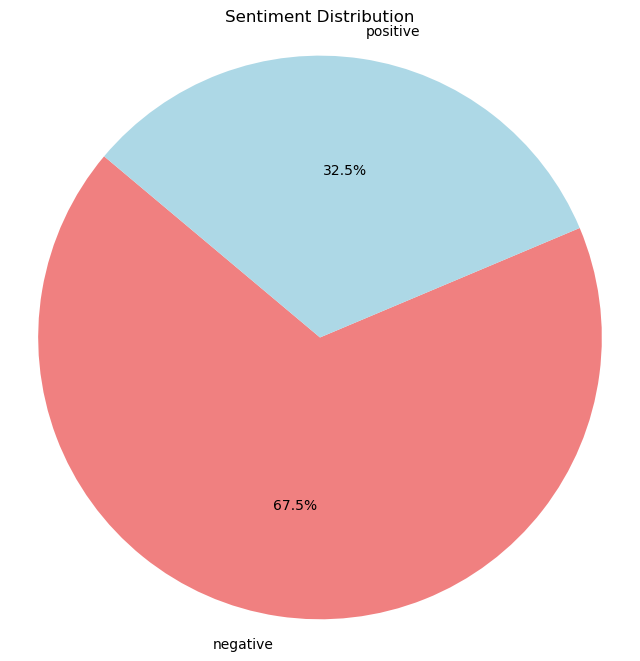

In [82]:
sentiment_counts = chat['sentiment'].value_counts()

sentiment_colors = {
    'positive': 'lightblue',
    'negative': 'lightcoral',
    'joy': 'lightgreen',
    'fear': 'lightyellow',
    'anger': 'lightsalmon',
    'sadness': 'lightpink'
}

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=[sentiment_colors.get(sentiment, 'lightgray') for sentiment in sentiment_counts.index])
plt.axis('equal')
plt.title('Sentiment Distribution')
plt.show()


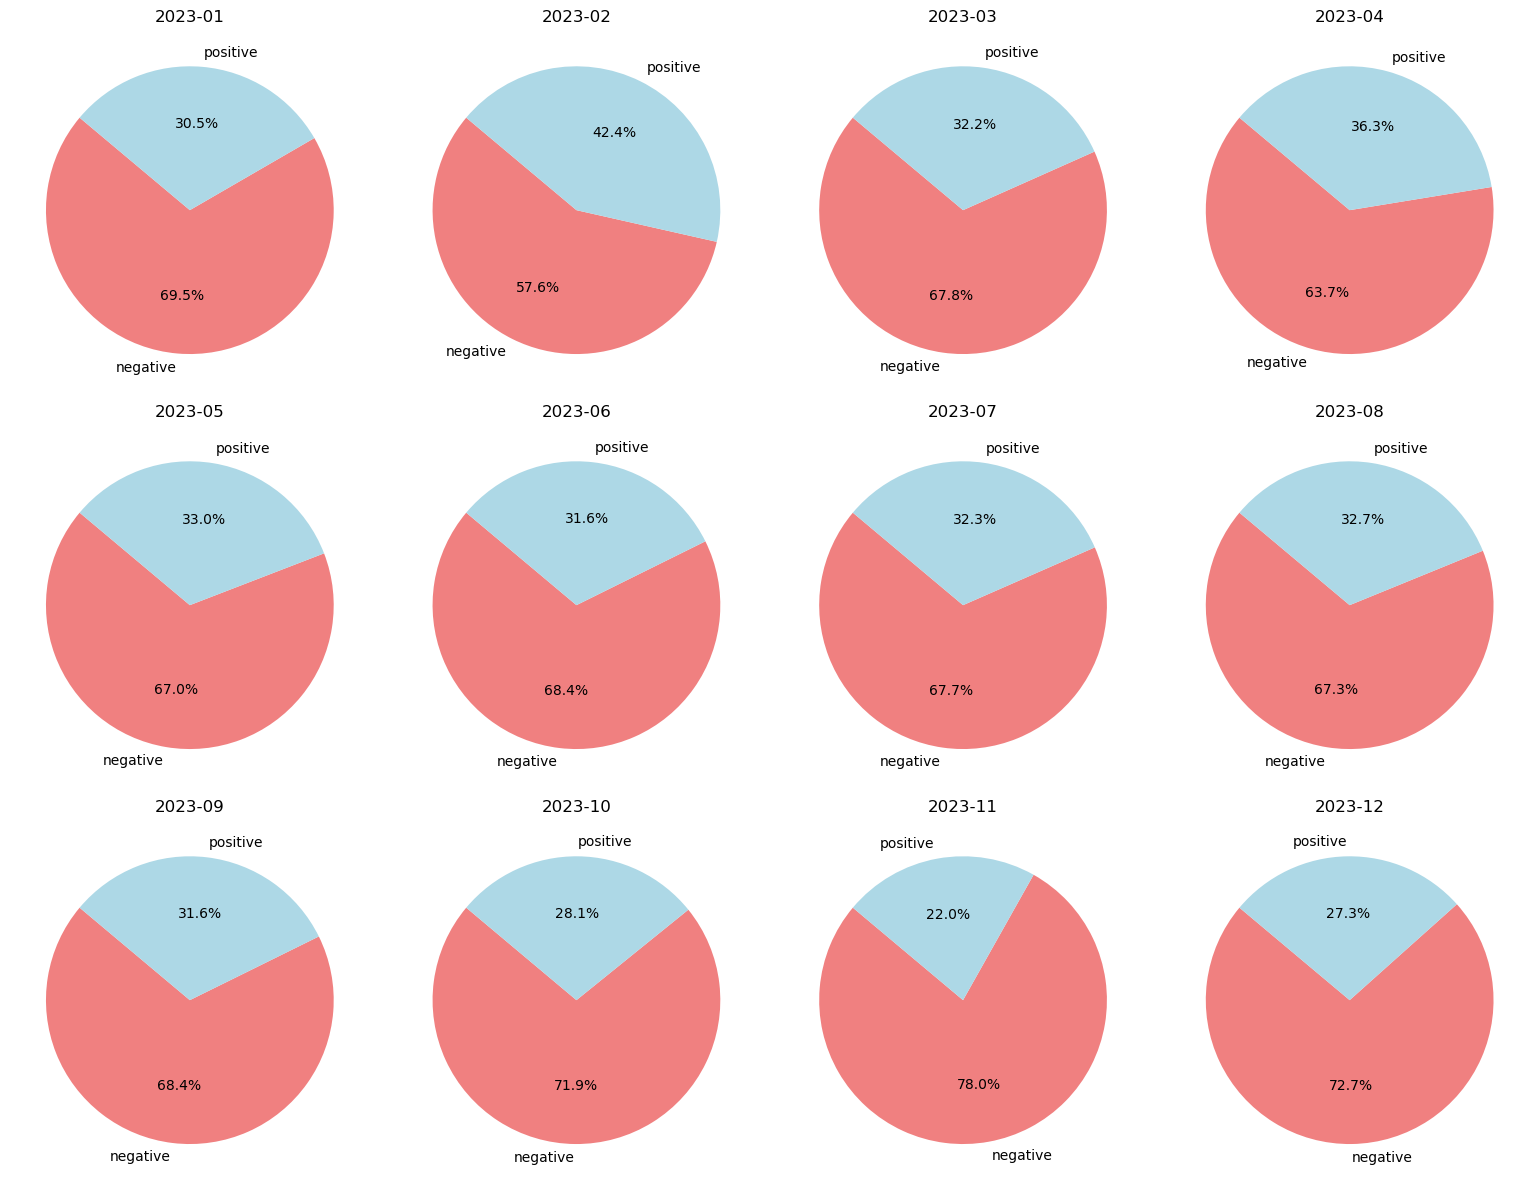

In [83]:
chat['month'] = chat['day'].dt.strftime('%Y-%m')

unique_months = sorted(chat['month'].unique())

fig, axs = plt.subplots(3, 4, figsize=(16, 12))
fig.subplots_adjust(hspace=0.5)
axs = axs.ravel()

for i, month in enumerate(unique_months):
    data_month = chat[chat['month'] == month]
    
    sentiment_counts = data_month['sentiment'].value_counts()
    
    axs[i].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=[sentiment_colors.get(sentiment, 'lightgray') for sentiment in sentiment_counts.index], startangle=140)
    axs[i].set_title(month)
    
plt.tight_layout()
plt.show()


In [84]:
emotions = []

for msg in tqdm(chat['msg_content']):
    emotion = emotion_classifier.predict([msg])[0]
    emotions.append(emotion)

chat['emotion'] = emotions

100%|██████████| 14352/14352 [13:17<00:00, 17.99it/s]


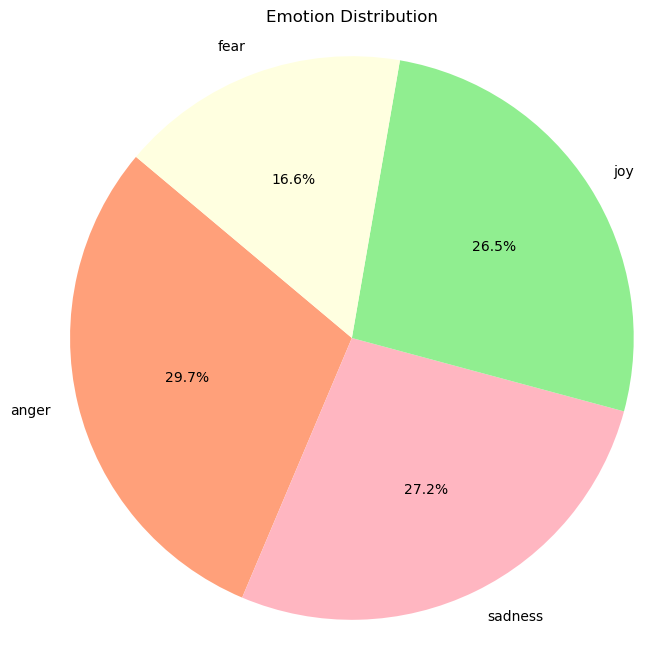

In [85]:
sentiment_counts = chat['emotion'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=[sentiment_colors.get(sentiment, 'lightgray') for sentiment in sentiment_counts.index])
plt.axis('equal')
plt.title('Emotion Distribution')
plt.show()

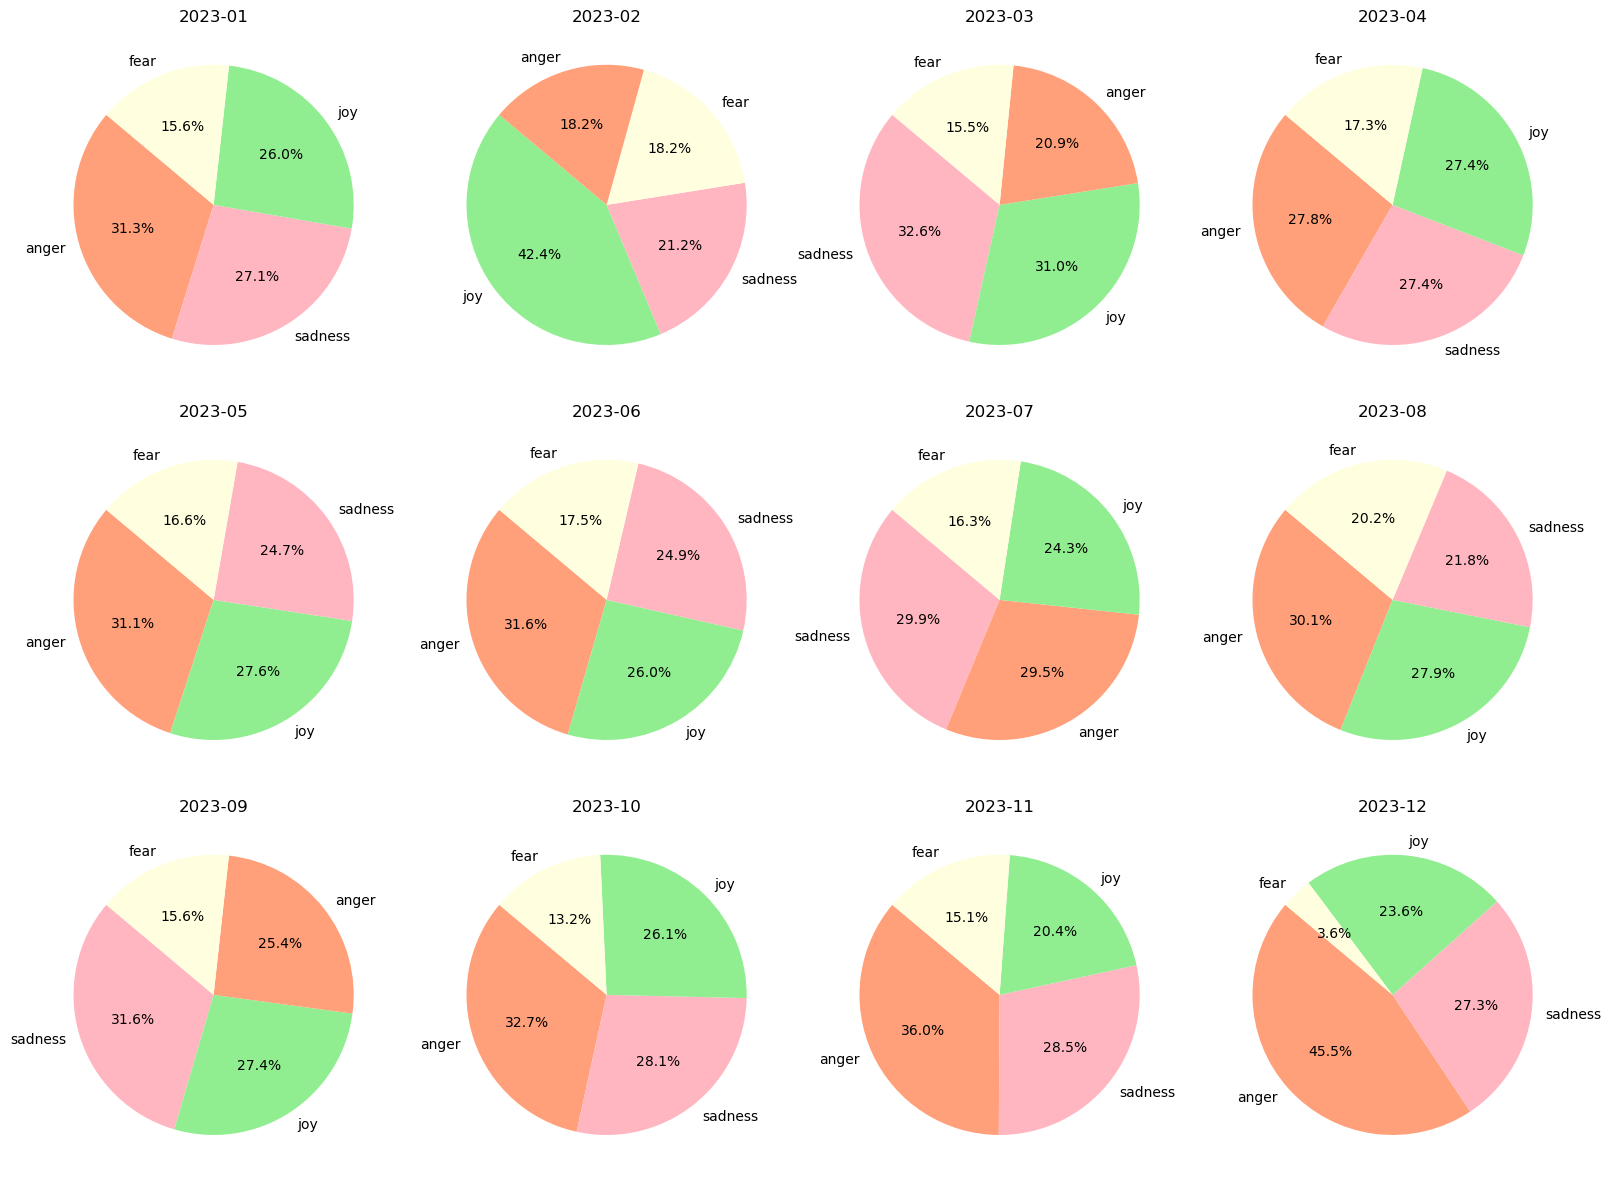

In [86]:
unique_months = sorted(chat['month'].unique())

colors = ['lightcoral', 'lightskyblue', 'lightgreen', 'magenta']

fig, axs = plt.subplots(3, 4, figsize=(16, 12))
fig.subplots_adjust(hspace=0.5)
axs = axs.ravel()

for i, month in enumerate(unique_months):
    data_month = chat[chat['month'] == month]
    
    sentiment_counts = data_month['emotion'].value_counts()
    
    axs[i].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=[sentiment_colors.get(sentiment, 'lightgray') for sentiment in sentiment_counts.index], startangle=140)
    axs[i].set_title(month)

plt.tight_layout()
plt.show()

### Reply analysis
We build a directed graph representing the reply relationships between participants. The relationship is based on the number of replies between the two users.

In [87]:
chat['replied_sender'] = ''

for _, row in chat.iterrows():
    reply_to_msg_id = row['reply_to_msg_id']
    
    if not pd.isnull(reply_to_msg_id) and reply_to_msg_id != -1:
        replied_sender = chat.loc[chat['msg_id'] == reply_to_msg_id, 'sender'].values
        if len(replied_sender) > 0:
            replied_sender = replied_sender[0]
            chat.at[_, 'replied_sender'] = replied_sender

G = nx.DiGraph()

participants = chat['sender'].unique()
G.add_nodes_from(participants)

reply_counts = {}

for _, row in chat.iterrows():
    sender = row['sender']
    replied_sender = row['replied_sender']
    
    if replied_sender != '':
        G.add_edge(replied_sender, sender)
        
        edge = (replied_sender, sender)
        reply_counts[edge] = reply_counts.get(edge, 0) + 1

edge_weights = {edge: math.log(count) for edge, count in reply_counts.items()}
edge_widths = [0.5 * edge_weights[edge] for edge in G.edges()]
nx.set_edge_attributes(G, edge_weights, 'weight')

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
average_degree = sum(dict(G.degree()).values()) / num_nodes

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average degree: {average_degree}")

Number of nodes: 9
Number of edges: 63
Average degree: 14.0


The following cell plots the graph. Depending on how many users there are, you might want to increase the value of _k_ for a better visualization.

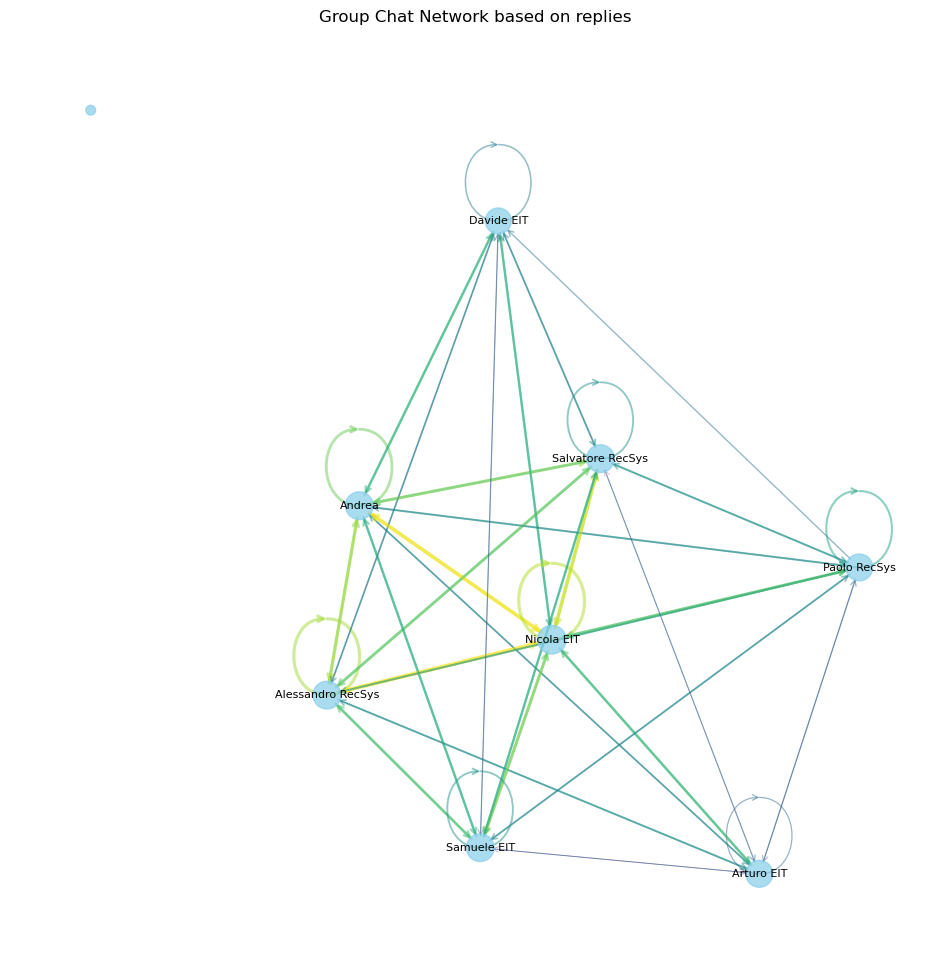

In [93]:
pos = nx.spring_layout(G, k=5, iterations=100)

node_sizes = [G.degree(node) * 50 for node in G.nodes()]
edge_colors = [edge_weights[edge] for edge in G.edges()]
threshold_degree = 1
high_degree_nodes = {node for node, degree in dict(G.degree()).items() if degree > threshold_degree}

scaled_node_sizes = [max(50, size * 0.5) for size in node_sizes]

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=scaled_node_sizes, node_color='skyblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, edge_color=edge_colors, width=edge_widths, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={node: node for node in high_degree_nodes}, font_size=8)

plt.title("Group Chat Network based on replies")
plt.axis('off')
plt.show()

The same can be represented using the adjacency matrix as a heatmap, as if there are too many users the graph gets chaotic fastly

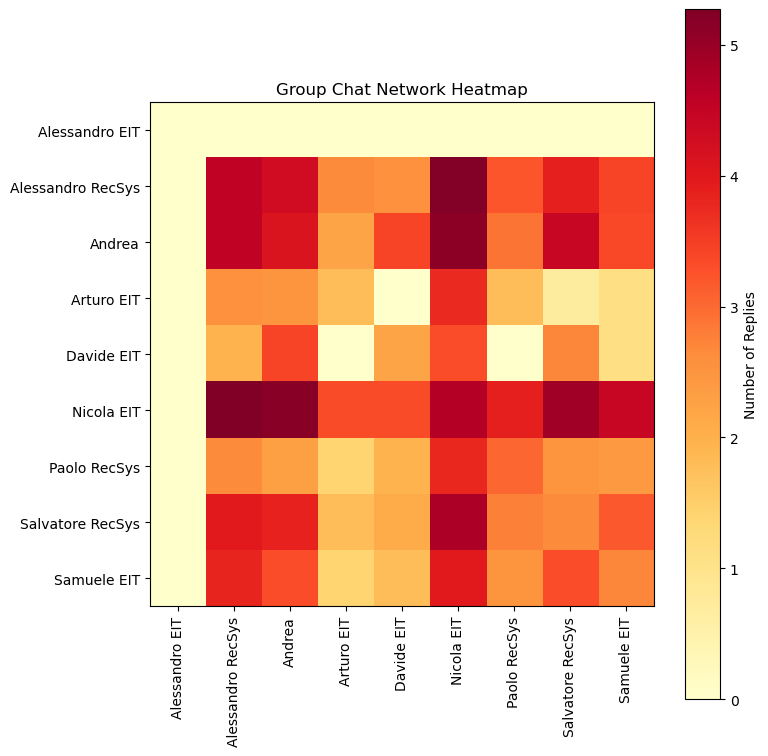

In [89]:
adj_matrix = nx.adjacency_matrix(G, nodelist=participants).todense()

plt.figure(figsize=(8, 8))
plt.imshow(adj_matrix, cmap='YlOrRd', interpolation='nearest')
plt.colorbar(label='Number of Replies')
plt.xticks(np.arange(len(participants)), participants, rotation=90)
plt.yticks(np.arange(len(participants)), participants)
plt.title("Group Chat Network Heatmap")
plt.tight_layout()
plt.show()

And to decrease the visual complexity, we can plot only the top-repliers for each user. In this case, the top 3.

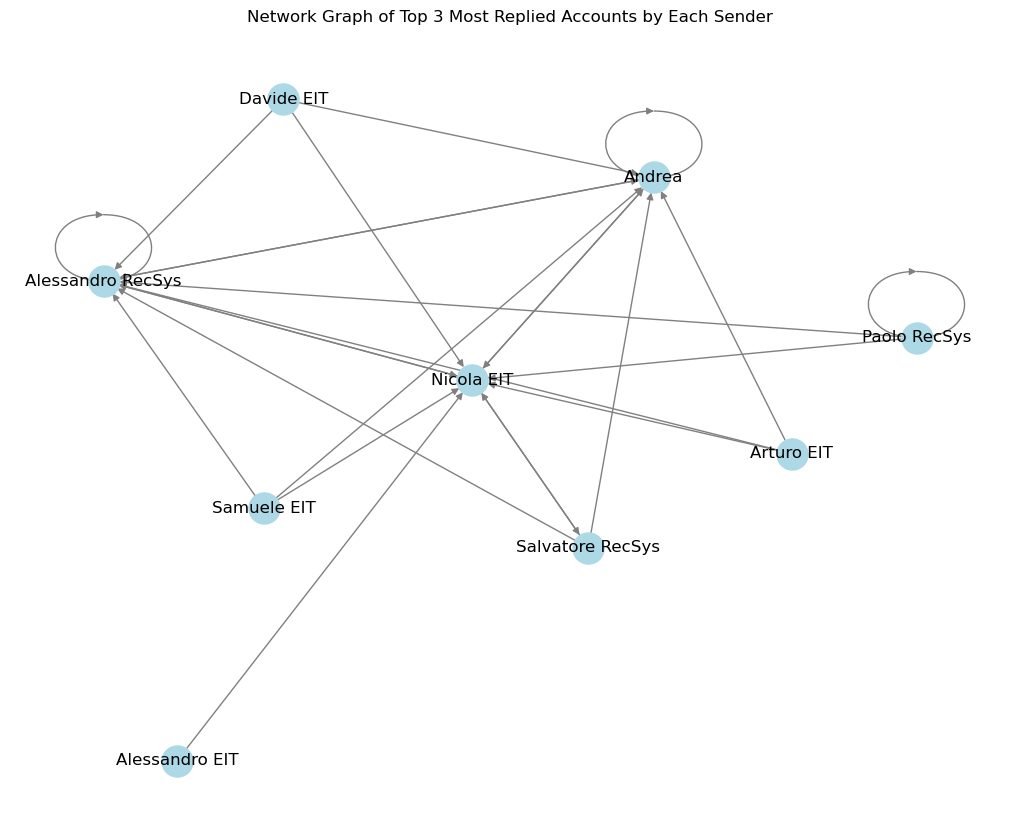

In [90]:
top_n = 3

top_replies = chat[chat['replied_sender'] != ''].groupby('sender')['replied_sender'].value_counts() 

G_top3 = nx.DiGraph()

G_top3.add_nodes_from(participants)

for sender, replied_data in top_replies.groupby(level=0):
    top_3_replied = replied_data.sort_values(ascending=False).head(top_n).index.get_level_values(1)
    for replied_sender in top_3_replied:
        G_top3.add_edge(sender, replied_sender)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_top3)
nx.draw(G_top3, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray', width=1)
plt.title("Network Graph of Top 3 Most Replied Accounts by Each Sender")
plt.show()